# Machine Learning: AllLife Bank Personal Loan Campaign

## Problem Statement

### Context

By Abebaw Masresha July 2024

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [71]:
# Install SHAP library for model interpretability
!pip install shap

# Install Optuna for hyperparameter tuning
!pip install optuna

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np
from scipy import stats

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for pandas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# Libraries for data preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

# Library to split data
from sklearn.model_selection import train_test_split

# Libraries to build models for prediction
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Import Optuna library for hyperparameter optimization
import optuna

# Import the Tree-structured Parzen Estimator (TPE) sampler for efficient hyperparameter search
from optuna.samplers import TPESampler

# Libraries to tune different models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# Libraries to get different metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer
)

# Library for model interpretation
import shap

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

# Check if all necessary libraries are imported
print("All necessary libraries have been imported successfully.")


All necessary libraries have been imported successfully.


**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [72]:
#Read the data from Google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

#path to the data
path="/content/drive/My Drive/AIMLTRAINING/collabdata/Loan_Modelling.csv"

Mounted at /content/drive


## Loading the dataset

In [73]:
#read the data as csv
data=pd.read_csv(path)

#drop Id since it has no meaning in our purpose
df=data.drop('ID',axis=1)
df2=df.copy()

## Data Overview

* Observations
* Sanity checks

In [74]:
# sanity checks
def data_sanity(df):
    print("\nData Information:\n")
    display(df.info())
    print("\n========================\n")
    print("Descriptive Statistics:\n")
    display(df.describe())
    print("\n========================\n")
    print("Null Values Check:\n")
    display(df.isnull().sum())
    print("\n========================\n")
    print("Data Types:\n")
    display(df.dtypes)
    print("\n========================\n")
    print("Duplicate Records Check:\n")
    display(df.duplicated().sum())

data_sanity(df)


Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


None



Descriptive Statistics:



Age  Experience     Income     ZIPCode     Family      CCAvg  \
count 5000.00000  5000.00000 5000.00000  5000.00000 5000.00000 5000.00000   
mean    45.33840    20.10460   73.77420 93169.25700    2.39640    1.93794   
std     11.46317    11.46795   46.03373  1759.45509    1.14766    1.74766   
min     23.00000    -3.00000    8.00000 90005.00000    1.00000    0.00000   
25%     35.00000    10.00000   39.00000 91911.00000    1.00000    0.70000   
50%     45.00000    20.00000   64.00000 93437.00000    2.00000    1.50000   
75%     55.00000    30.00000   98.00000 94608.00000    3.00000    2.50000   
max     67.00000    43.00000  224.00000 96651.00000    4.00000   10.00000   

       Education   Mortgage  Personal_Loan  Securities_Account  CD_Account  \
count 5000.00000 5000.00000     5000.00000          5000.00000  5000.00000   
mean     1.88100   56.49880        0.09600             0.10440     0.06040   
std      0.83987  101.71380        0.29462             0.30581     0.23825   
min      1.00000    0.00000        0.00000             0.00000     0.00000   
25%      1.00000    0.00000        0.00000             0.00000     0.00000   
50%      2.00000    0.00000        0.00000             0.00000     0.00000   
75%      3.00000  101.00000        0.00000             0.00000     0.00000   
max      3.00000  635.00000        1.00000             1.00000     1.00000   

          Online  CreditCard  
count 5000.00000  5000.00000  
mean     0.59680     0.29400  
std      0.49059     0.45564  
min      0.00000     0.00000  
25%      0.00000     0.00000  
50%      1.00000     0.00000  
75%      1.00000     1.00000  
max      1.00000     1.00000



Null Values Check:



Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64



Data Types:



Age                     int64
Experience              int64
Income                  int64
ZIPCode                 int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal_Loan           int64
Securities_Account      int64
CD_Account              int64
Online                  int64
CreditCard              int64
dtype: object



Duplicate Records Check:



0

In [75]:
#keep copy of the original data
df_original=df.copy()

**Data Overview**
- Mean age of customers is 45.34 years.
- Average professional experience is 20.10 years, with some negative values indicating potential errors.
- Customers have a mean annual income of \$73,774.
- Average family size of customers is 2.40 members meaning the typical customer has a family size of about 2 to 3 members.
- Mean monthly credit card spending is \$1,938.
- Most customers have an education level around 1.88, indicating a mix of undergraduate and graduate degrees.
- Mean mortgage value is \$56,499.
- 9.6% of customers accepted a personal loan in the last campaign.
- 10.4% of customers have a securities account.
- 6% of customers have a certificate of deposit account.
- 59.7% of customers use online banking facilities.

**Data Quality Checks**
- Experience has a minimum value of -3, which suggests potential data errors; these should be treated as missing values..
- Data Types: All columns have appropriate data types (integers and floats).
- Duplicate Records: No duplicate records found in the dataset.
- Negative Values: Negative values in the "Experience" column should be treated as incorrect data and addressed.

## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
2. How many customers have credit cards?
3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
4. How does a customer's interest in purchasing a loan vary with their age?
5. How does a customer's interest in purchasing a loan vary with their education?

**Univariate Analysis**

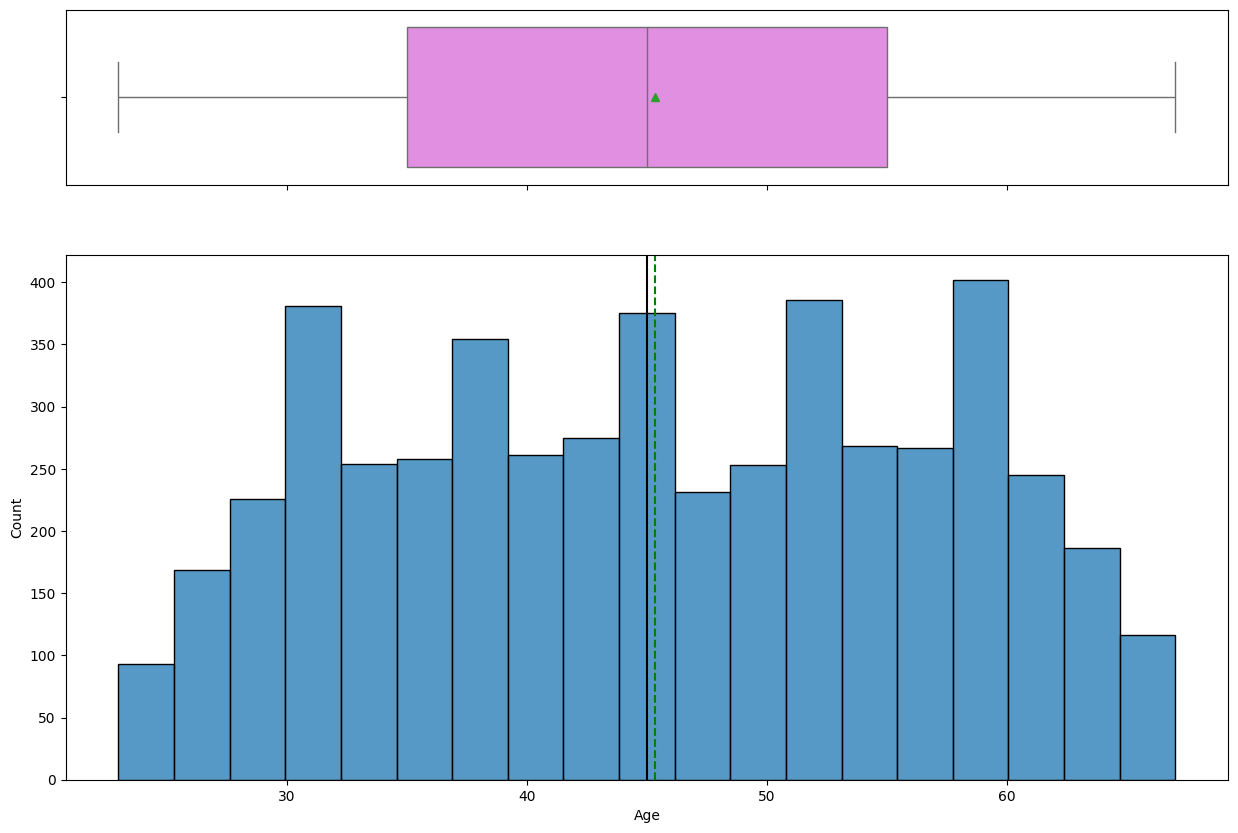

 - No significant outliers detected in Age.


----------------------------------------------------------------------------------------------------



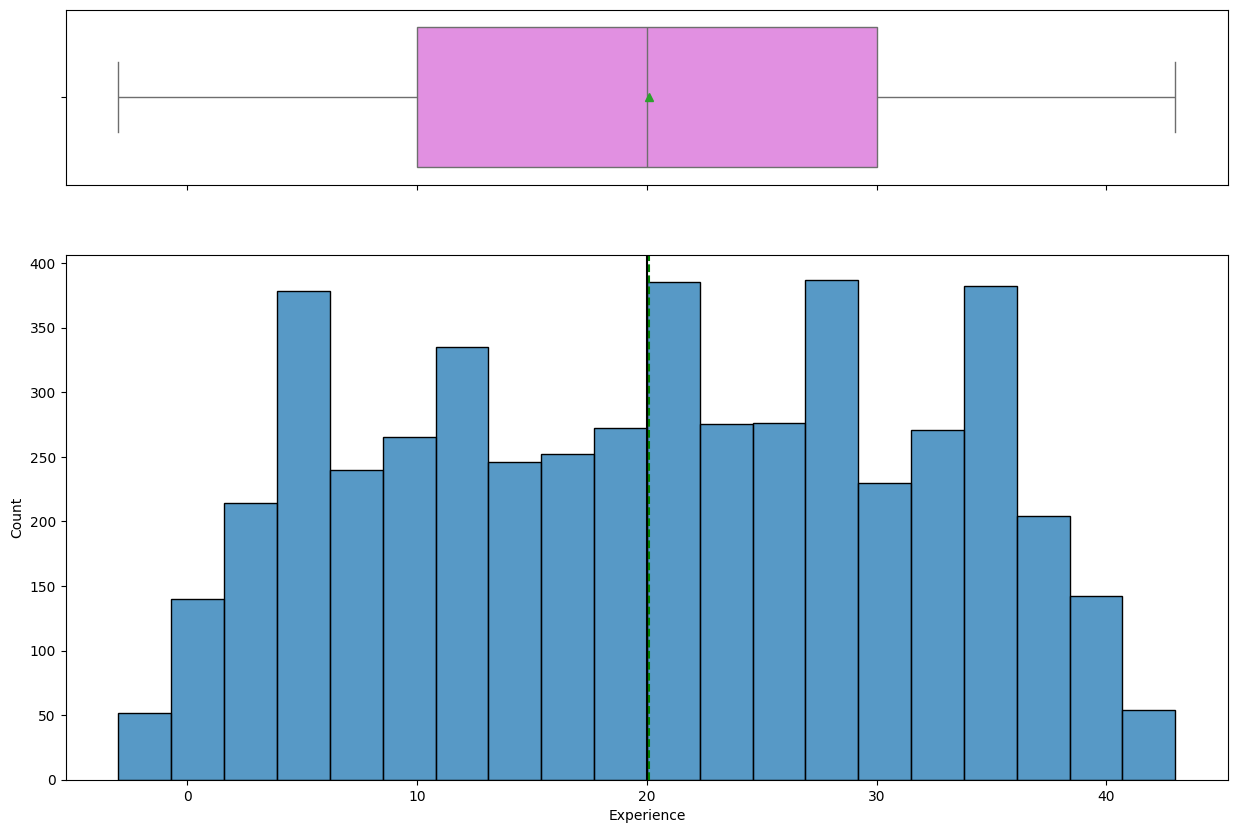

 - No significant outliers detected in Experience.


----------------------------------------------------------------------------------------------------



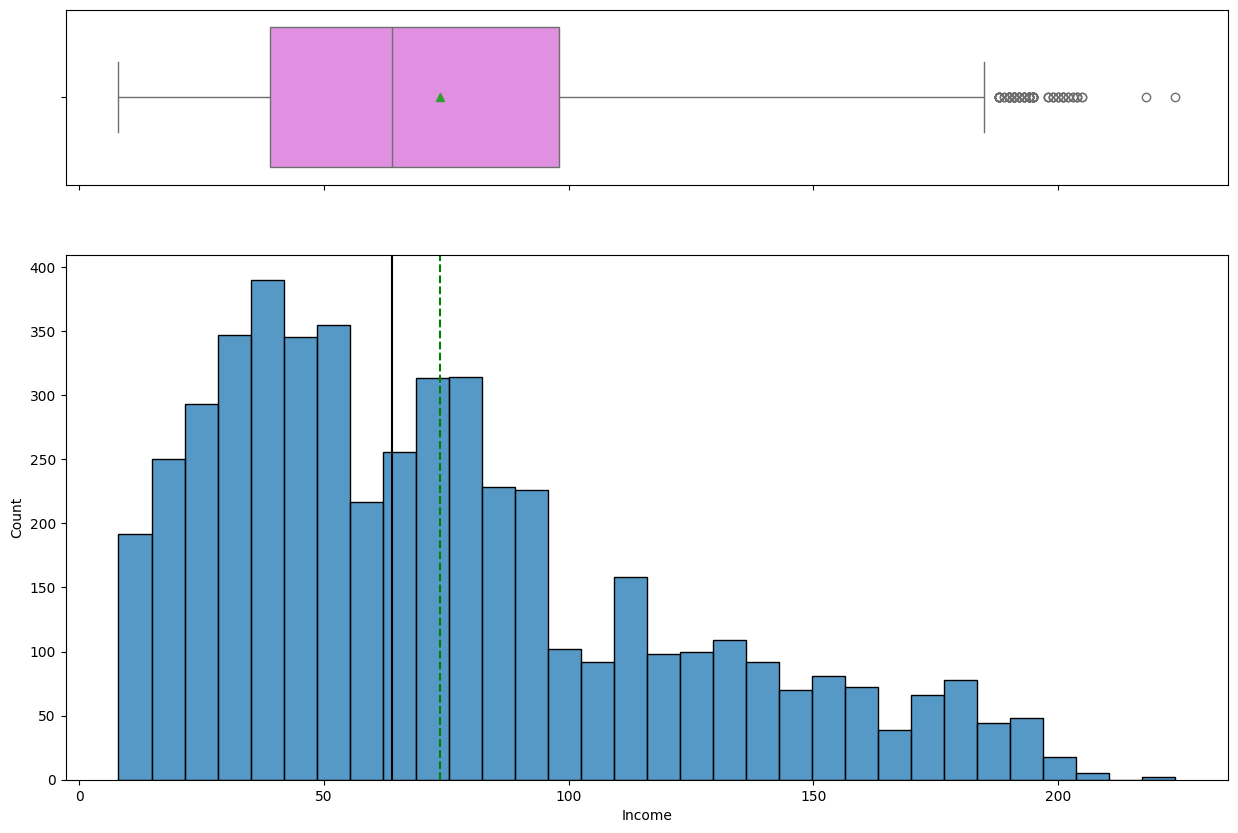

 - Outliers detected in Income:



----------------------------------------------------------------------------------------------------



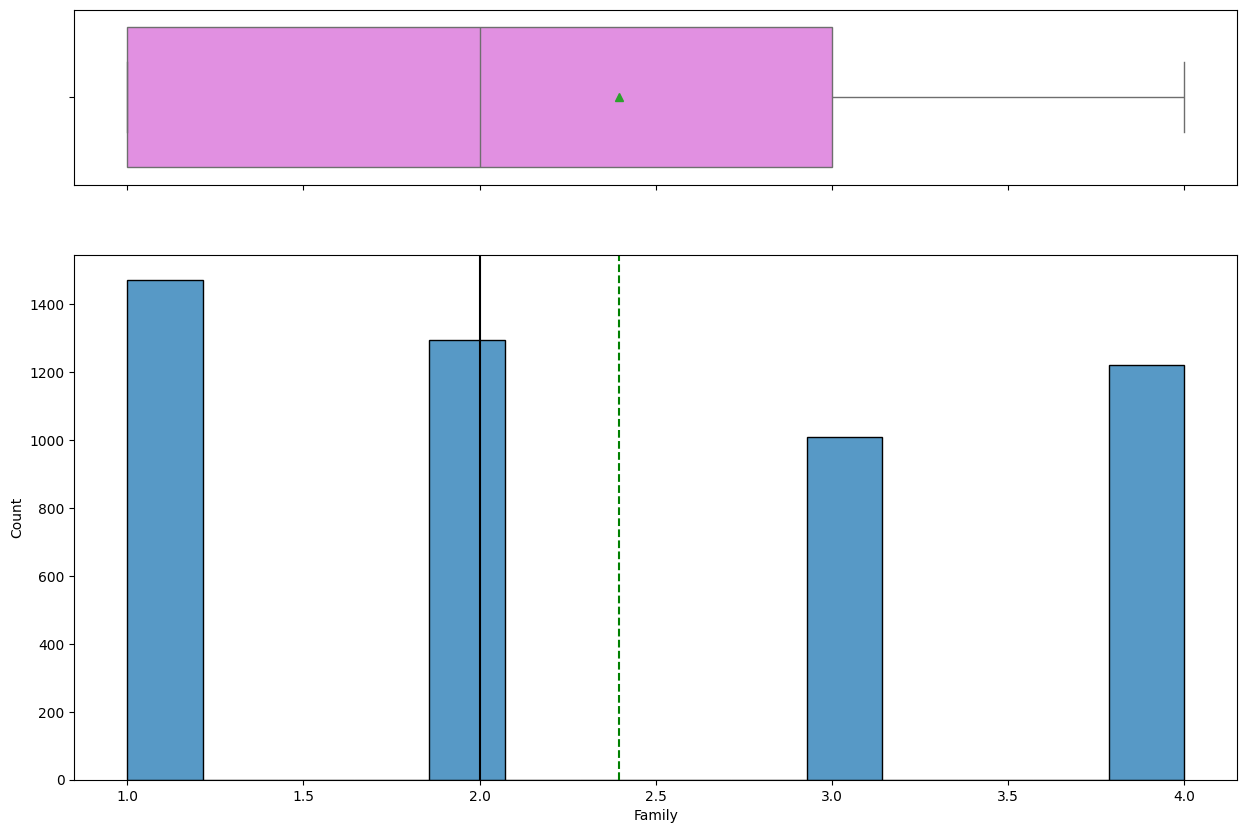

 - No significant outliers detected in Family.


----------------------------------------------------------------------------------------------------



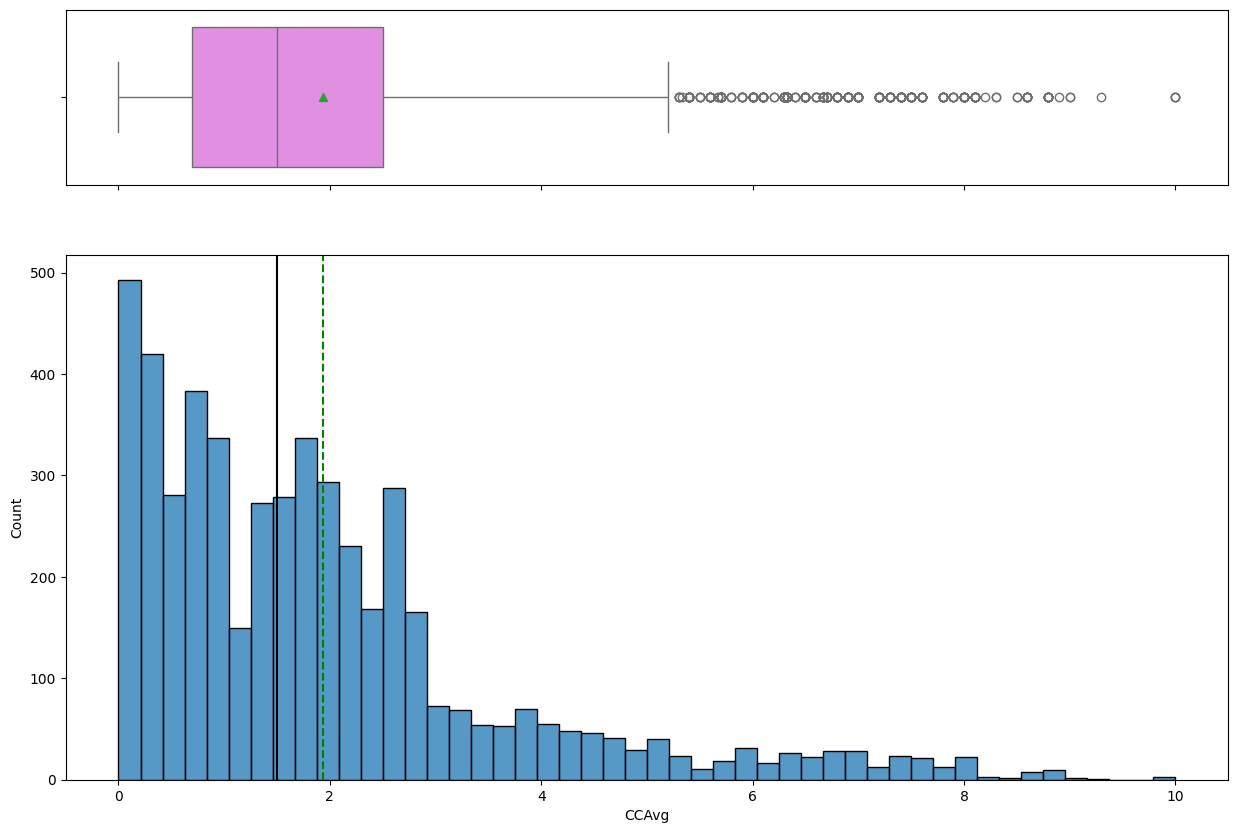

 - Outliers detected in CCAvg:



----------------------------------------------------------------------------------------------------



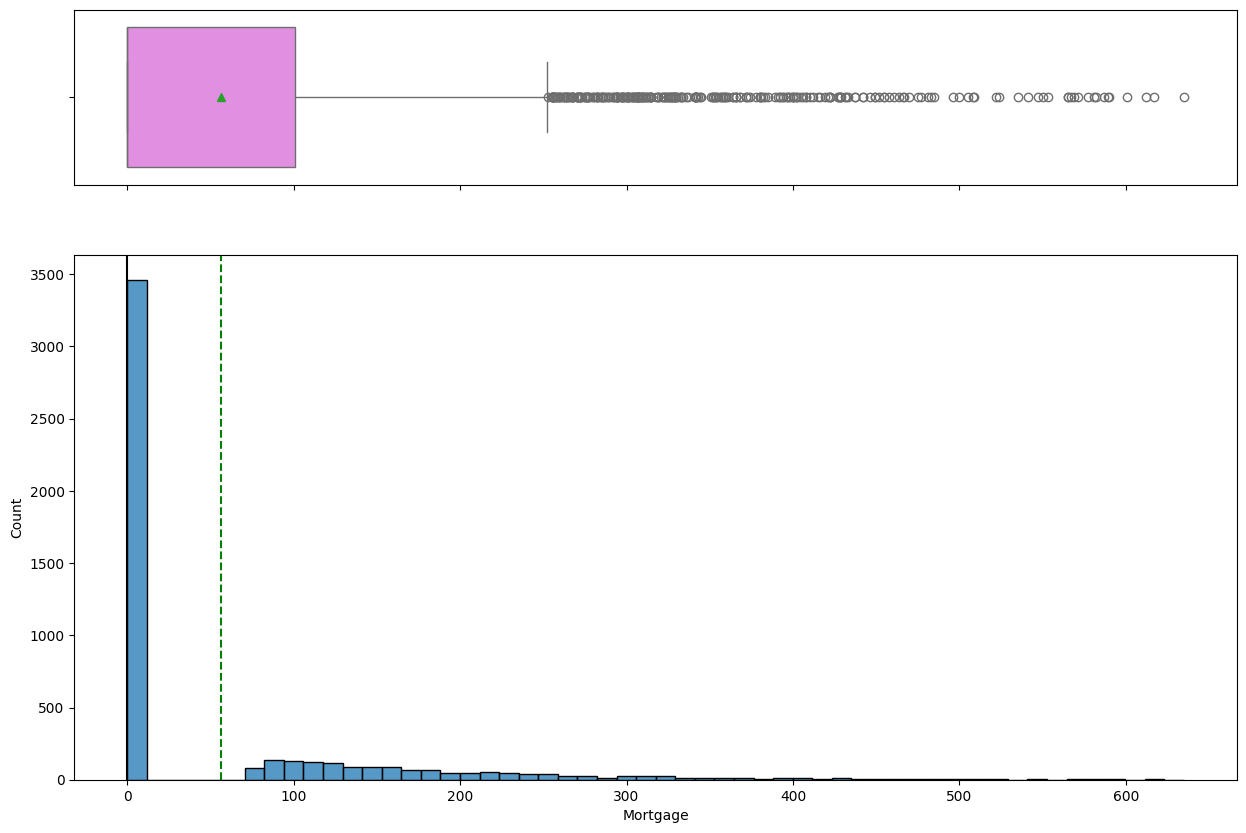

 - Outliers detected in Mortgage:



----------------------------------------------------------------------------------------------------





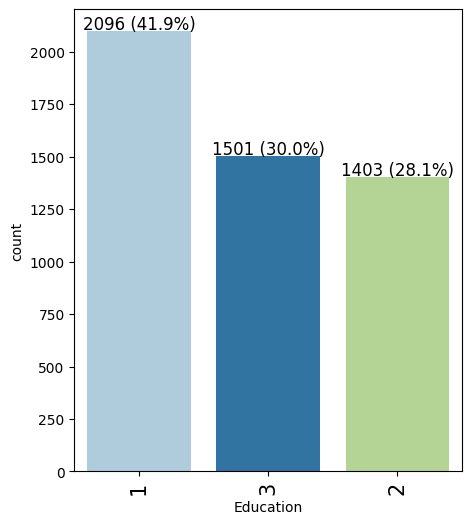

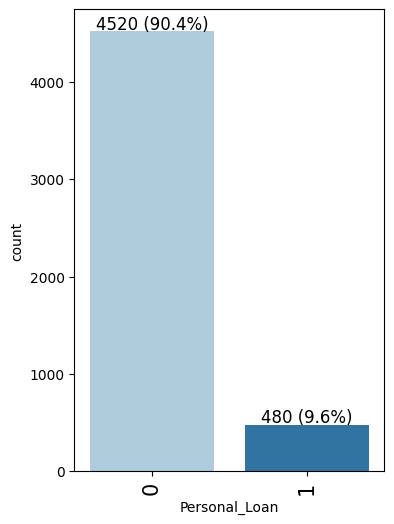

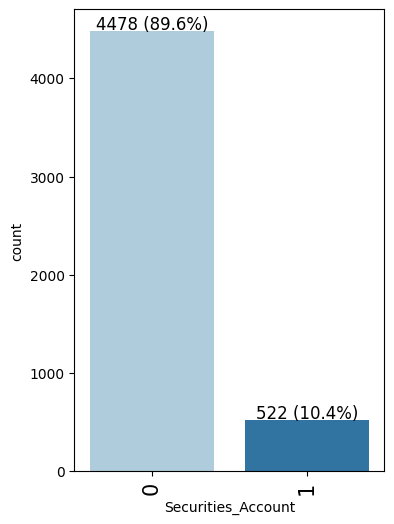

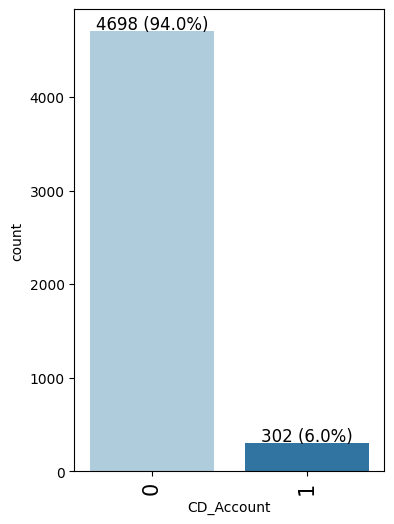

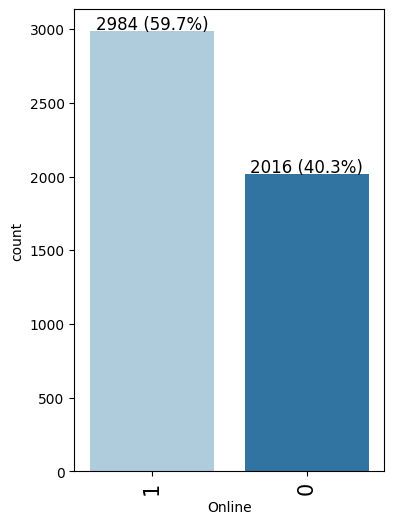

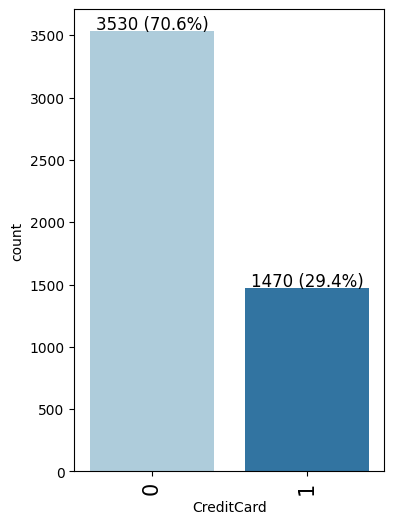



Summary of ZIPCode:
Total unique ZIP codes: 467

Top ZIP codes by count:
   ZIPCode  Count
0    94720    169
1    94305    127
2    95616    116
3    90095     71
4    93106     57
5    92037     54
6    93943     54
7    91320     53
8    94025     52
9    91711     52
10   92093     51
11   90024     50
12   90245     50
13   91330     46
14   90089     46
15   92121     45
16   94304     45
17   94143     37
18   94608     34
19   95051     34


In [76]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined.

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with count (percentage) at the top.

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages along with count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        label = "{} ({:.1f}%)".format(int(p.get_height()), 100 * p.get_height() / total)

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

def distribution_plot_wrt_target(data, predictor, target):
    """
    Plot distributions with respect to target variable.

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

def univariate_analysis(df, numerical_features, categorical_features):
    # Analyzing numerical features
    for feature in numerical_features:
        # print(f"\n\033[1m\033[4m\033[16mUnivariate Analysis for {feature}:\033[0m\n")
        # print(df[feature].describe())

        histogram_boxplot(df, feature)
        plt.show()

        # Detect outliers
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR))]
        if not outliers.empty:
            print(f" - Outliers detected in {feature}:")
            # print(outliers[feature].describe())
            print("\n")
        else:
            print(f" - No significant outliers detected in {feature}.\n")

        print("\n" + "-"*100 + "\n")  # Separation between variables

    # Analyzing categorical features
    for feature in categorical_features:
        # print(f"\033[1m\033[4m\033[16mFrequency counts for {feature}:\033[0m")
        # print(df[feature].value_counts())
        print("\n")

        labeled_barplot(df, feature)
        plt.show()

        print("\n" + "="*50 + "\n")  # Separation between variables


def summarize_zipcode_distribution(df, zipcode_column='ZIPCode', top_n=20):
    """
    Provides a summary of the distribution of the ZIPCode attribute.

    Parameters:
    df (pd.DataFrame): The dataset containing the ZIPCode column.
    zipcode_column (str): The column name for ZIPCode.
    top_n (int): Number of top ZIP codes to display in the plot.

    Returns:
    None
    """

    # Ensure ZIPCode is treated as a categorical variable
    df[zipcode_column] = df[zipcode_column].astype('category')

    # Get summary statistics
    summary = df[zipcode_column].value_counts().reset_index()
    summary.columns = [zipcode_column, 'Count']

    # Print summary statistics
    print(f"Summary of {zipcode_column}:")
    print(f"Total unique ZIP codes: {len(summary)}")
    print("\nTop ZIP codes by count:")
    print(summary.head(top_n))  # Display top N ZIP codes for brevity


numerical_features = ['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']
categorical_features = ['Education', 'Personal_Loan', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']
univariate_analysis(df, numerical_features, categorical_features)

summarize_zipcode_distribution(df)



# Univariate Analysis for Numerical Variables

**Age**

- Data Insight: Customers range from 23 to 67 years old, with an average age of 45 years, indicating a mature customer base.
- Skewness: Slightly right-skewed, with fewer younger customers compared to older ones.
- Outliers: No significant outliers detected in Age.

**Experience**

- Data Insight: Experience ranges from -3 to 43 years, with an average of 20 years, showing a diverse range of professional backgrounds.
- Skewness: Right-skewed, with a higher concentration of customers having less experience.
- Outliers: Negative work experience values indicate data errors that should be treated as missing values.

**Income**

- Data Insight: Average income is \$73,774 (replace with actual dollar sign if necessary), with values ranging from \$8,000 to \$224,000, indicating a broad income distribution among customers.
- Skewness: Right-skewed, with a concentration of lower incomes and a few high-income outliers.
- Outliers: 96 rows with high income (\$188,000 to \$224,000) are identified as outliers.

**Family**

- Data Insight: The average family size is 2.4 members, with most customers having family sizes between 2 and 3 members.
- Skewness: Approximately symmetrical, with no significant skewness.
- Outliers: No significant outliers detected in Family.

**CCAvg (Average spending on credit cards per month)**

- Data Insight: Average credit card spending is \$1,938, with values ranging from \$0 to\ $10,000, reflecting a wide range of spending behaviors.
- Skewness: Right-skewed, with most customers having lower spending and a few high spenders.
- Outliers: 324 rows with high spending (\$5,300 to \$10,000) are identified as outliers.

**Mortgage**

- Data Insight: The average mortgage amount is \$56,499, with a broad range from \$0 to \$635,000.
- Skewness: The distribution is highly right-skewed, with most customers having low to no mortgages, while a smaller group has significantly higher mortgage amounts.
- Outliers: There are 291 outliers with high mortgage amounts ranging from \$253,000 to \$635,000, indicating that a few customers have exceptionally large mortgages compared to the majority.


# Univariate Analysis for Categorical Variables

**ZIPCode**

- Data Insight: ZIP code 94720 has the highest count of occurrences, with 169 entries, indicating a high concentration of customers in this area.
- Skewness: The distribution of ZIP codes is highly skewed towards a few ZIP codes with significantly higher counts.
- Outliers: None of the ZIP codes are classified as outliers, but a wide range of unique ZIP codes reflects diverse geographical coverage.

**Education**

- Data Insight: The majority of customers hold an undergraduate degree (Education level 1), comprising 42% of the dataset, while advanced degree holders (Education level 3) make up 30%.
- Skewness: The distribution is somewhat skewed towards lower education levels, with fewer advanced degree holders.
- Outliers: No significant outliers in Education.

**Personal_Loan**

- Data Insight: Only 10% of customers have accepted a personal loan, indicating a low uptake of this product.
- Skewness: Highly skewed towards non-loan customers, with a small percentage having accepted loans.
- Outliers: No significant outliers in Personal_Loan.

**Securities_Account**

- Data Insight: Approximately 10% of customers have a securities account, indicating limited adoption of this financial product.
- Skewness: Highly skewed towards customers without a securities account.
- Outliers: No significant outliers in Securities_Account.

**CD_Account**

- Data Insight: Only about 6% of customers have a CD account, reflecting low interest in this product.
- Skewness: Skewed towards customers without a CD account.
- Outliers: No significant outliers in CD_Account.

**Online**

- Data Insight: Approximately 60% of customers use online banking, showing a strong preference for digital services.
- Skewness: Skewed towards online banking users.
- Outliers: No significant outliers in Online.

**CreditCard**

- Data Insight: Approximately 29% of customers (1,470) use a credit card from another bank, indicating a potential opportunity for cross-selling.
- Skewness: Skewed towards customers without a credit card from another bank.
-Outliers: No significant outliers in CreditCard.

# Bivariate Analysis

In [77]:
#Bivariate Analysis for Categorical vs. Categorical
def bivariate_cat_cat(df, var1, var2):
    summary = pd.crosstab(df[var1], df[var2])

    # Plot
    crosstab = summary
    crosstab.plot(kind='bar', figsize=(12, 8), cmap='viridis')

    # Add counts on bars
    for p in plt.gca().patches:
        plt.text(p.get_x() + p.get_width() / 2., p.get_height() + 10, int(p.get_height()),
                 ha='center', va='bottom')

    plt.ylabel('Count')
    plt.title(f'Bivariate Analysis: {var1} vs {var2}')
    plt.xticks(rotation=45)
    plt.show()

# Import the f_oneway function from scipy.stats for performing one-way ANOVA
from scipy.stats import f_oneway
# Bivariate analysis for categorical vs continuous variables
def bivariate_cat_cont(df, cat_var, cont_var):
    """
    This function plots the relationship between a categorical variable and a continuous variable.
    It also prints data summaries and statistics for the variables involved.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    cat_var (str): The name of the categorical variable.
    cont_var (str): The name of the continuous variable.
    """
    # Check if the variables exist in the DataFrame
    if cat_var not in df.columns or cont_var not in df.columns:
        print(f"Error: One or both variables '{cat_var}' and '{cont_var}' are not in the DataFrame.")
        return

    # Print detailed statistics for the continuous variable grouped by the categorical variable
    grouped_data = df.groupby(cat_var)[cont_var].describe()


    # Perform ANOVA test to check if the differences between groups are statistically significant
    groups = [df[df[cat_var] == category][cont_var] for category in df[cat_var].unique()]
    anova_result = f_oneway(*groups)
    print(f"ANOVA test result: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")
    print("\n")

    # Create a plot
    plt.figure(figsize=(14, 7))

    # Plot using seaborn
    sns.boxplot(x=cat_var, y=cont_var, data=df, palette="Set2")

    plt.title(f'Boxplot of {cont_var} by {cat_var}', fontsize=16)
    plt.xlabel(cat_var, fontsize=14)
    plt.ylabel(cont_var, fontsize=14)

    # Display the plot
    plt.show()


#Bivariate Analysis for Continuous vs. Continuous
def bivariate_cont_cont(df, var1, var2):
    # Data Summary
    # print(f"\nData Summary for {var1} and {var2}:")
    summary = df[[var1, var2]].describe()
    correlation = df[[var1, var2]].corr().loc[var1, var2]
    # print(summary)
    # print(f'\nCorrelation between {var1} and {var2}: {correlation:.2f}')

    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(x=var1, y=var2, data=df)

    plt.title(f'Bivariate Analysis: {var1} vs {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

def correlation_heatmap(df):
    """
    Generate a heatmap of the correlation matrix for the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the data.

    Returns:
    None
    """
    corr_matrix = df.corr()
    # print(corr_matrix)
    plt.figure(figsize=(15, 9))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

# Function to perform ZIP code analysis
def zipcode_analysis(df):
    # Group by ZIPCode and calculate meaningful statistics
    zip_analysis = df.groupby('ZIPCode').agg({
        'Age': ['mean', 'count'],
        'Experience': 'mean',
        'Income': 'mean',
        'Family': 'mean',
        'CCAvg': 'mean',
        'Education': lambda x: x.value_counts().idxmax(),  # Most common education level
        'Mortgage': 'mean',
        'Securities_Account': 'sum',
        'CD_Account': 'sum',
        'Online': 'sum',
        'CreditCard': 'sum'
    })

    # Flatten column hierarchy
    zip_analysis.columns = ['_'.join(col).strip() for col in zip_analysis.columns.values]
    zip_analysis = zip_analysis.rename(columns={'Age_count': 'Customer_Count'})

    # Calculate rates for binary variables
    binary_vars = ['Securities_Account', 'CD_Account', 'Online', 'CreditCard']
    for var in binary_vars:
        zip_analysis[f'{var}_Rate'] = zip_analysis[f'{var}_sum'] / zip_analysis['Customer_Count']

    # Function to plot top 5 ZIP codes for a given metric
    def plot_top_5(df, metric, title, xlabel, ylabel):
        top_5 = df.nlargest(5, metric)
        plt.figure(figsize=(10, 6))
        top_5[metric].plot(kind='bar', color='skyblue')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45)
        plt.show()

    # Plot top 5 ZIP codes for each metric
    metrics = {
        'Income_mean': 'Top 5 ZIP Codes by Average Income',
        'CCAvg_mean': 'Top 5 ZIP Codes by Average Credit Card Spending',
        'Mortgage_mean': 'Top 5 ZIP Codes by Average Mortgage',
        'Securities_Account_Rate': 'Top 5 ZIP Codes by Securities Account Ownership Rate',
        'CD_Account_Rate': 'Top 5 ZIP Codes by CD Account Ownership Rate',
        'Online_Rate': 'Top 5 ZIP Codes by Online Banking Usage Rate',
        'CreditCard_Rate': 'Top 5 ZIP Codes by Credit Card Ownership Rate'
    }

    for metric, title in metrics.items():
        plot_top_5(zip_analysis, metric, title, 'ZIP Code', metric.replace('_', ' ').title())

    # Display the top 5 ZIP codes for each metric
    for metric in metrics.keys():
        print(f"Top 5 ZIP Codes by {metric.replace('_', ' ').title()}:")
        print(zip_analysis.nlargest(5, metric)[[metric]])
        print("\n")

    # Calculate the number of ZIP codes with zero personal loans
    zero_personal_loans = (df.groupby('ZIPCode')['Personal_Loan'].sum() == 0).sum()
    print(f"Number of ZIP codes with zero personal loans: {zero_personal_loans}")

# Function to get top 10 ZIP codes that take personal loans and count ZIP codes with zero personal loans
def top_10_zipcodes_personal_loans(df):
    # Group by ZIPCode and calculate the sum of Personal_Loan
    zip_personal_loan = df.groupby('ZIPCode').agg({'Personal_Loan': 'sum'}).reset_index()

    # Get top 10 ZIP codes
    top_10 = zip_personal_loan.nlargest(10, 'Personal_Loan')
    print("Top 10 ZIP Codes by Personal Loan Acceptance:")
    print(top_10)

    # Plot top 10 ZIP codes
    plt.figure(figsize=(10, 6))
    top_10.set_index('ZIPCode')['Personal_Loan'].plot(kind='bar', color='green')
    plt.title('Top 10 ZIP Codes by Personal Loan Acceptance')
    plt.xlabel('ZIP Code')
    plt.ylabel('Personal Loan Acceptance')
    plt.xticks(rotation=45)
    plt.show()

    # Count ZIP codes with zero personal loans
    zero_personal_loans = (zip_personal_loan['Personal_Loan'] == 0).sum()
    print(f"Number of ZIP codes with zero personal loans: {zero_personal_loans}")



**Categorical vs Categorical Variables**

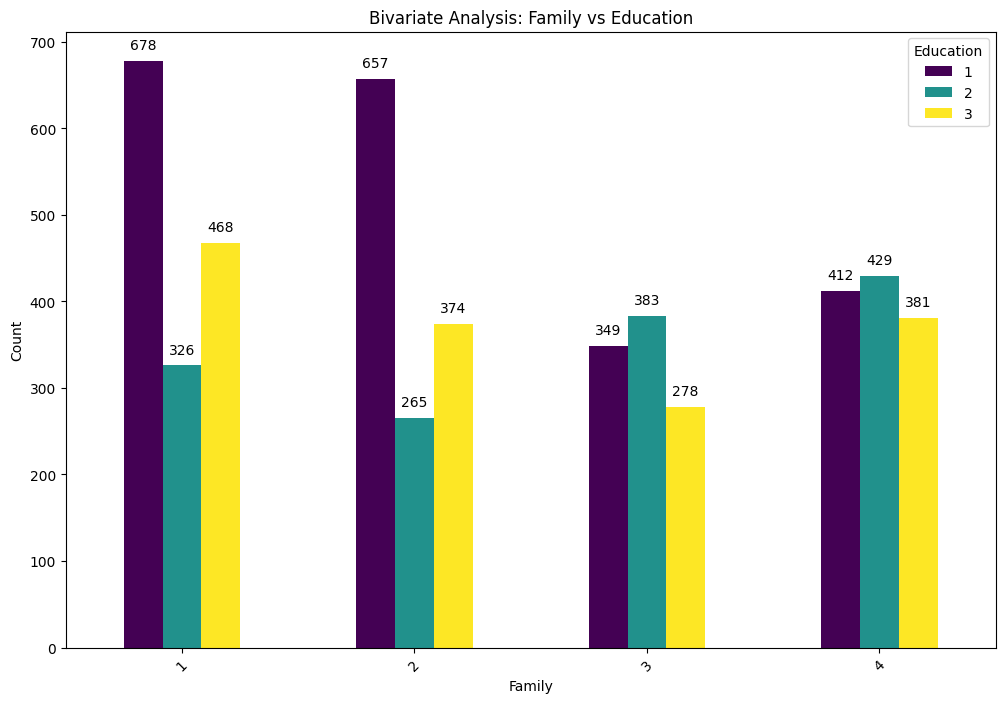

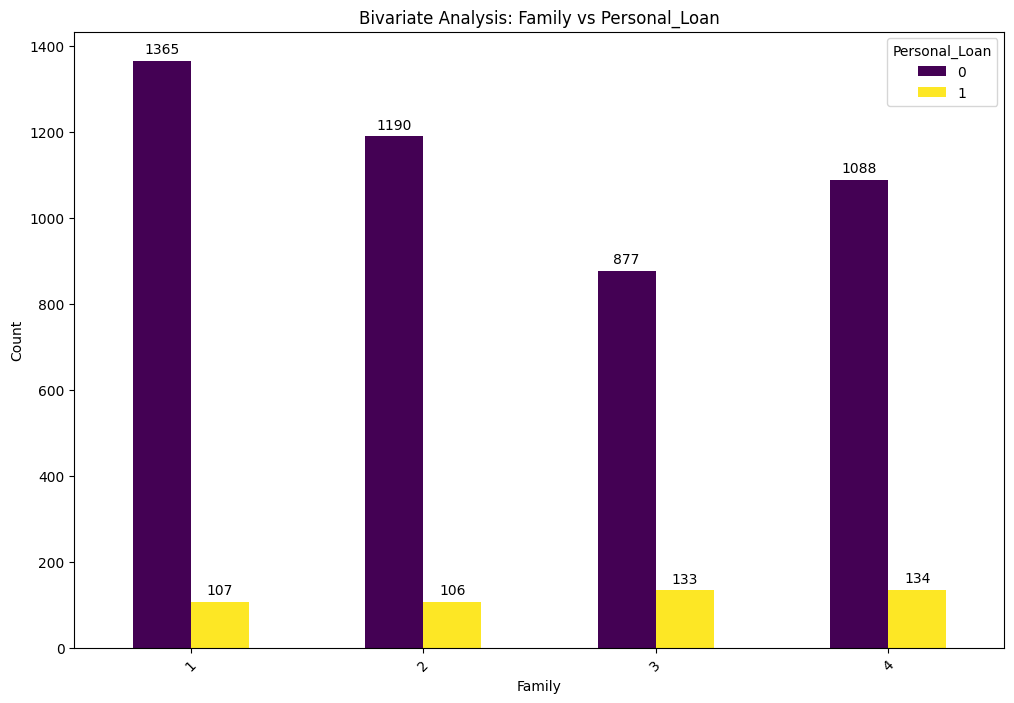

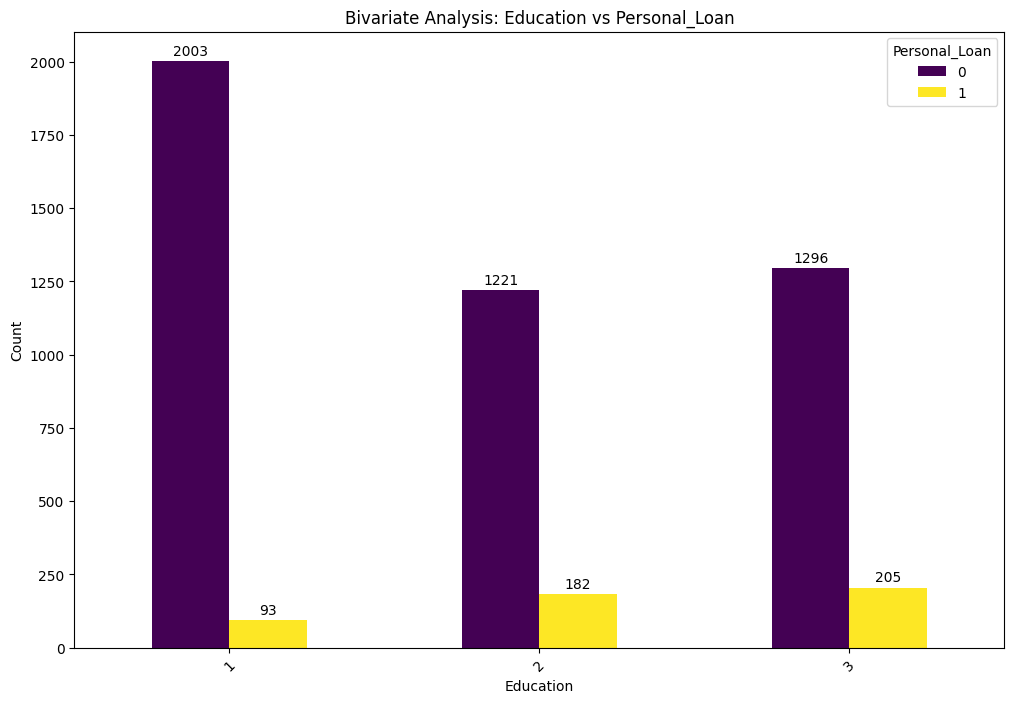

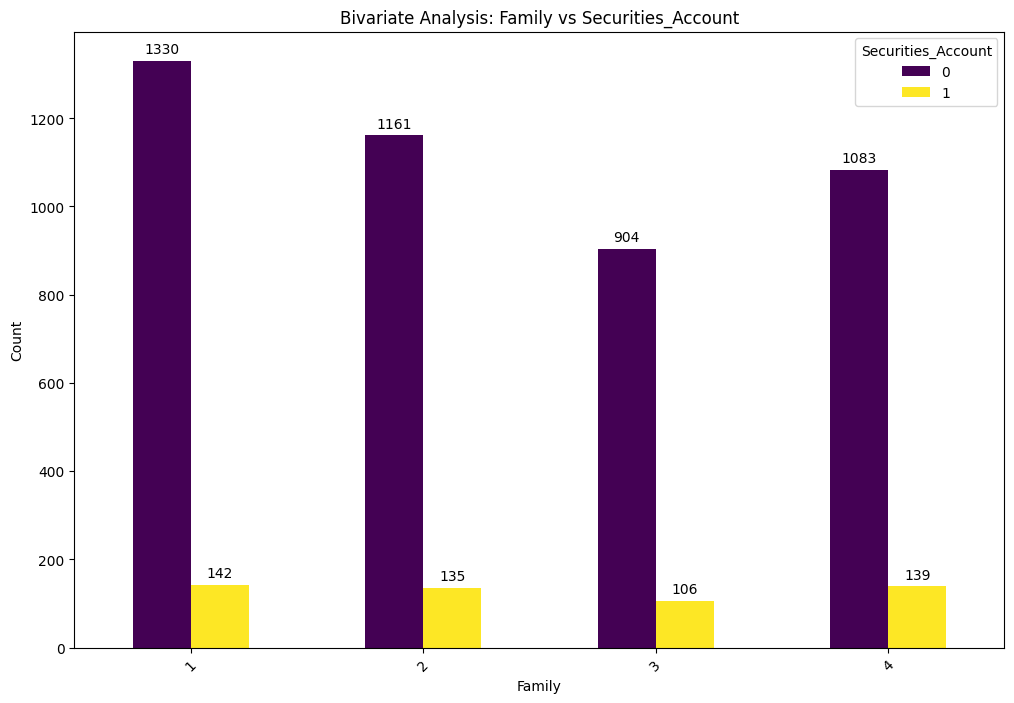

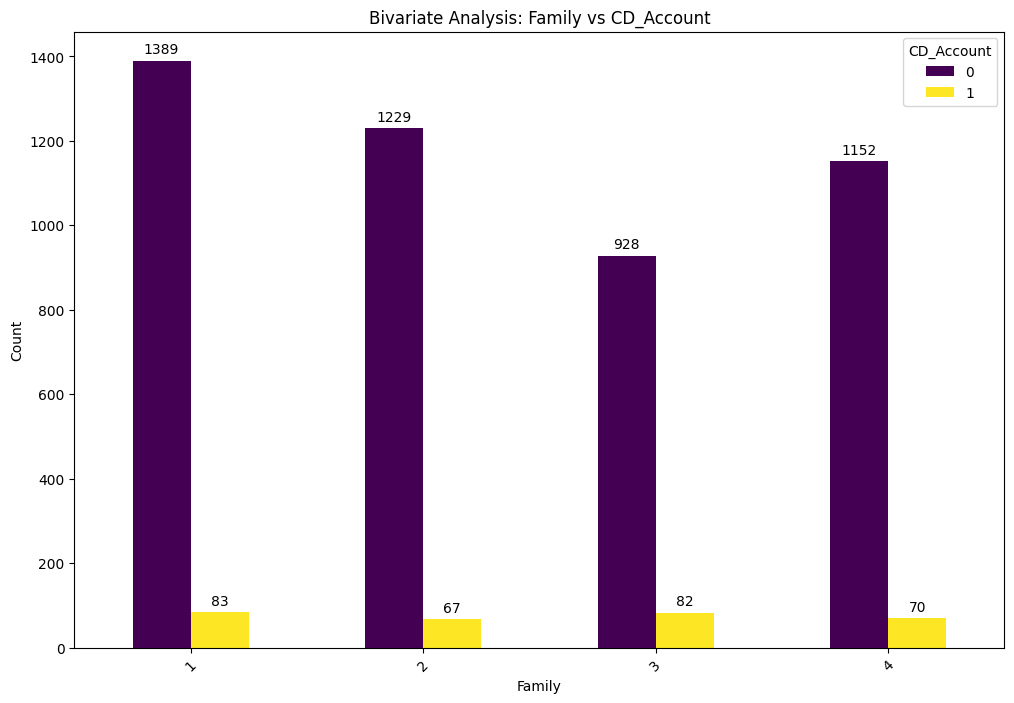

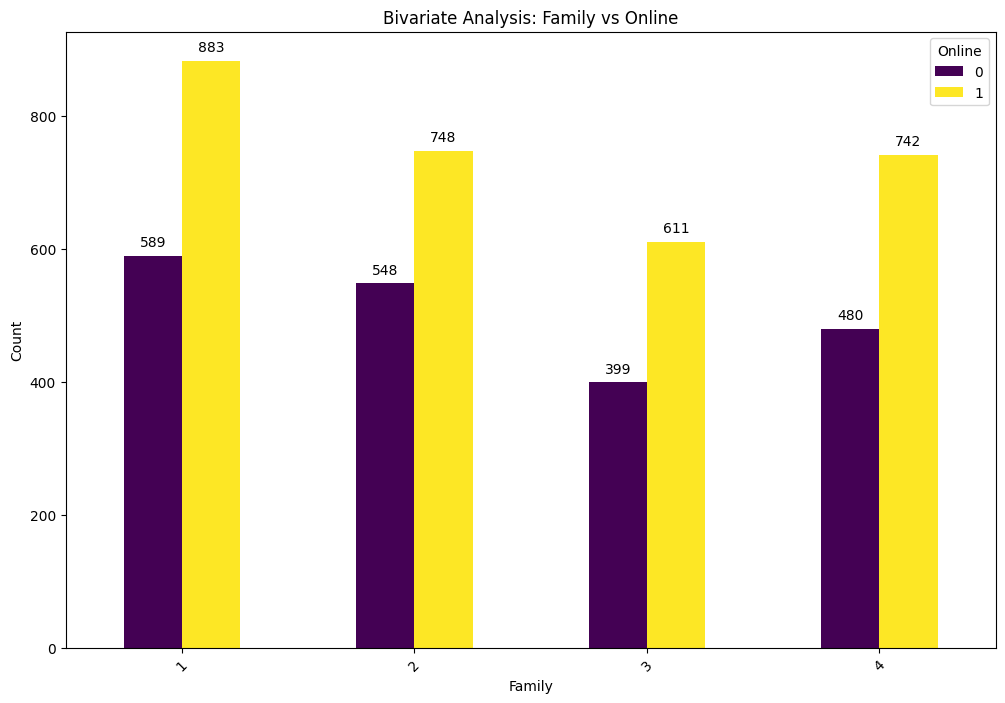

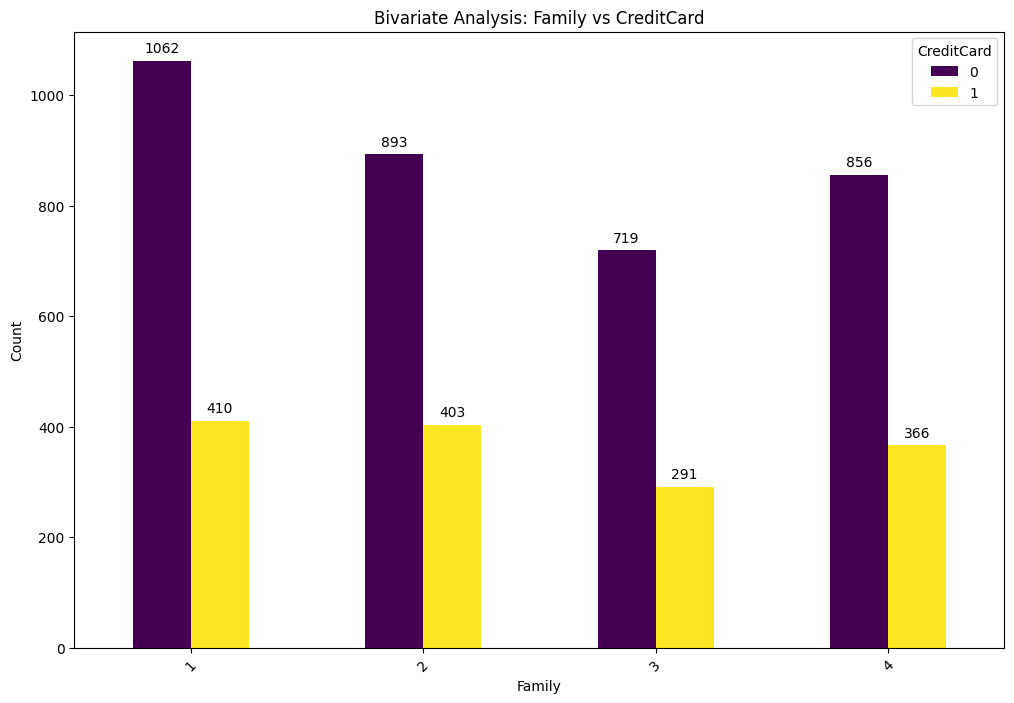

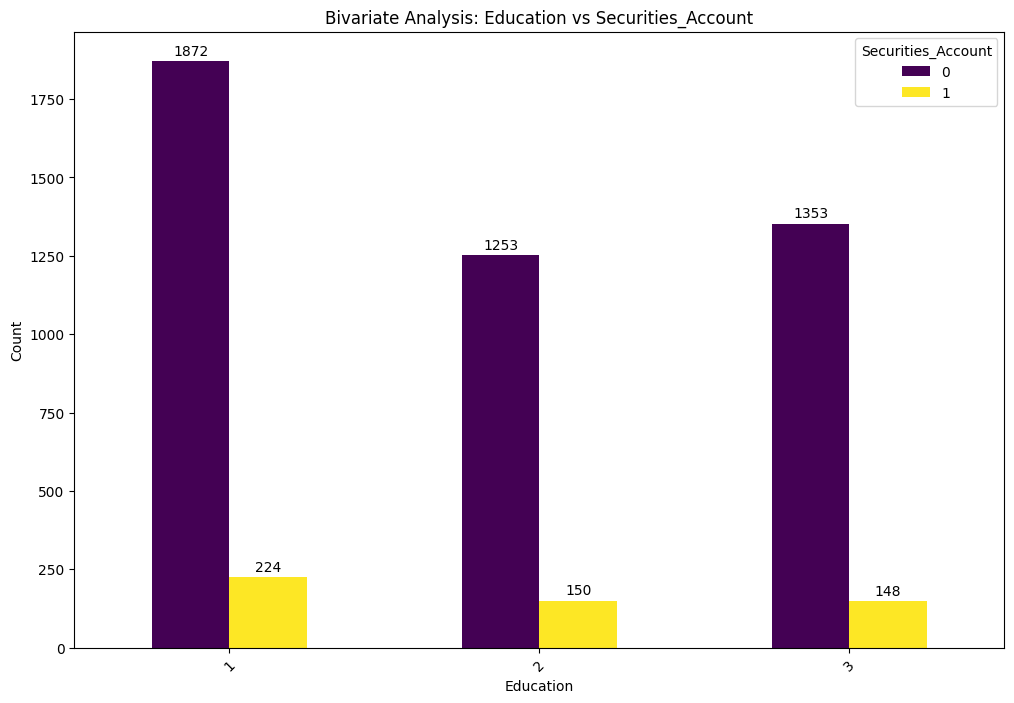

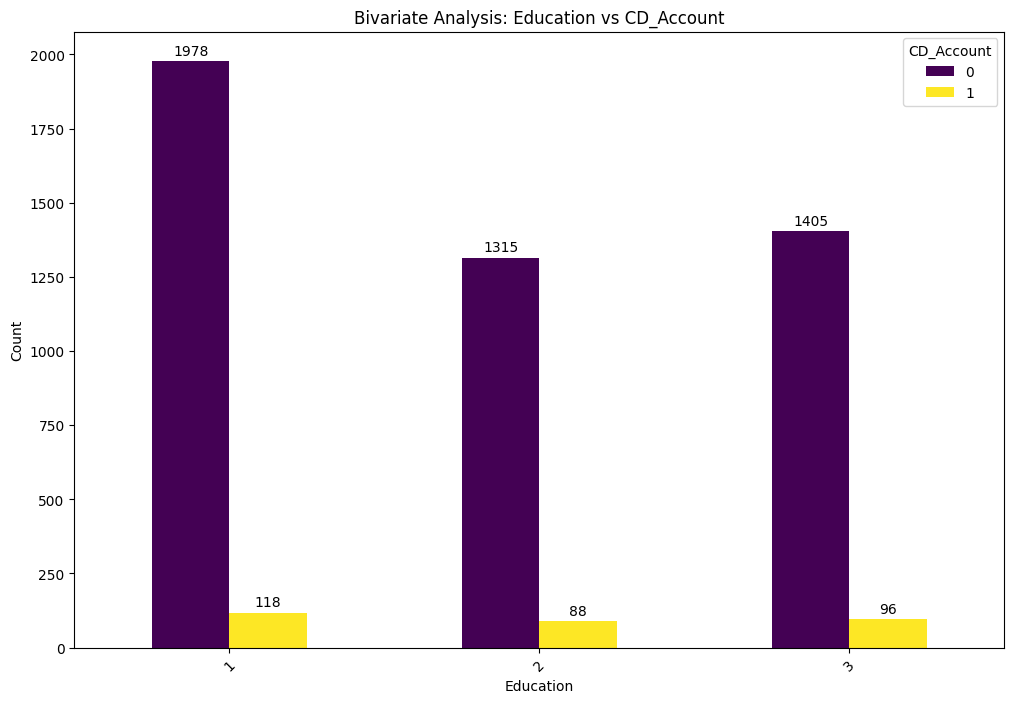

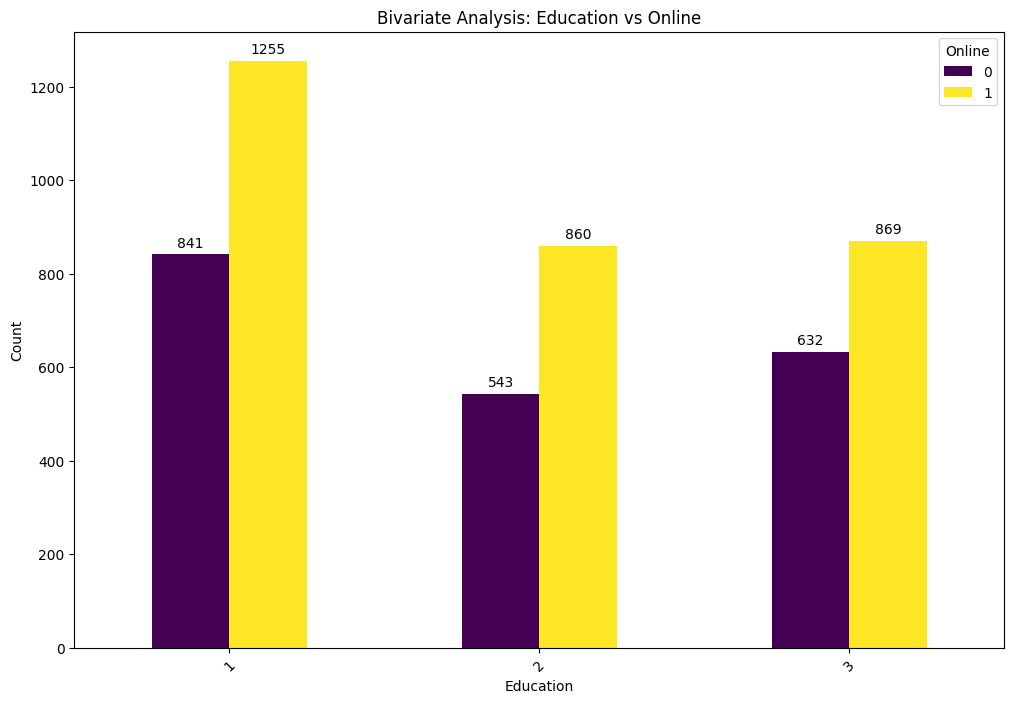

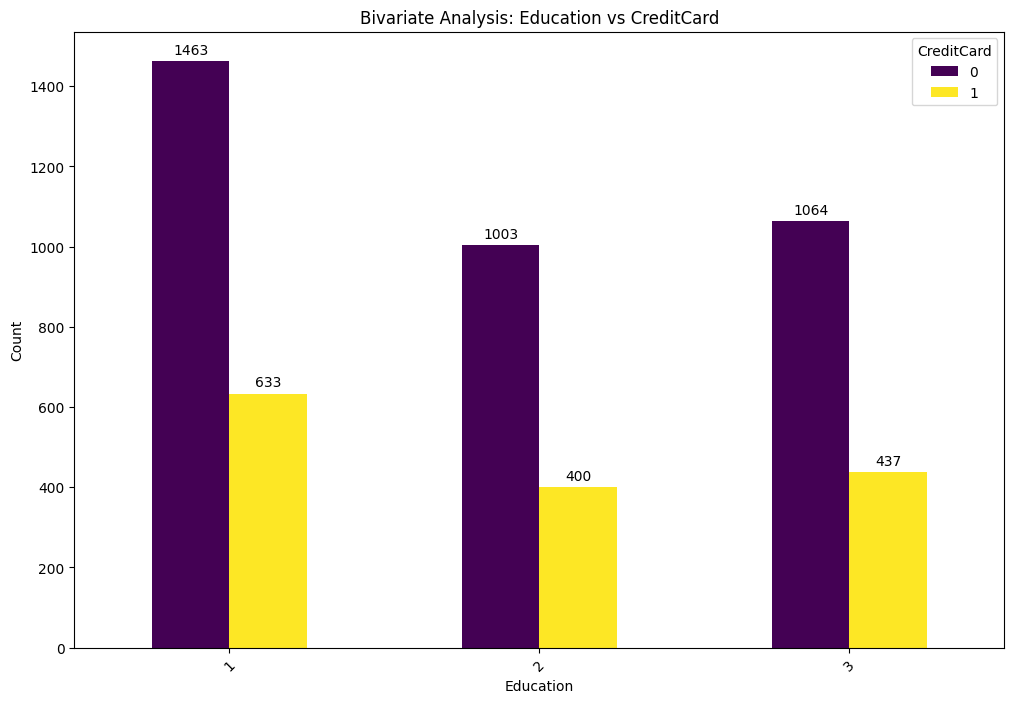

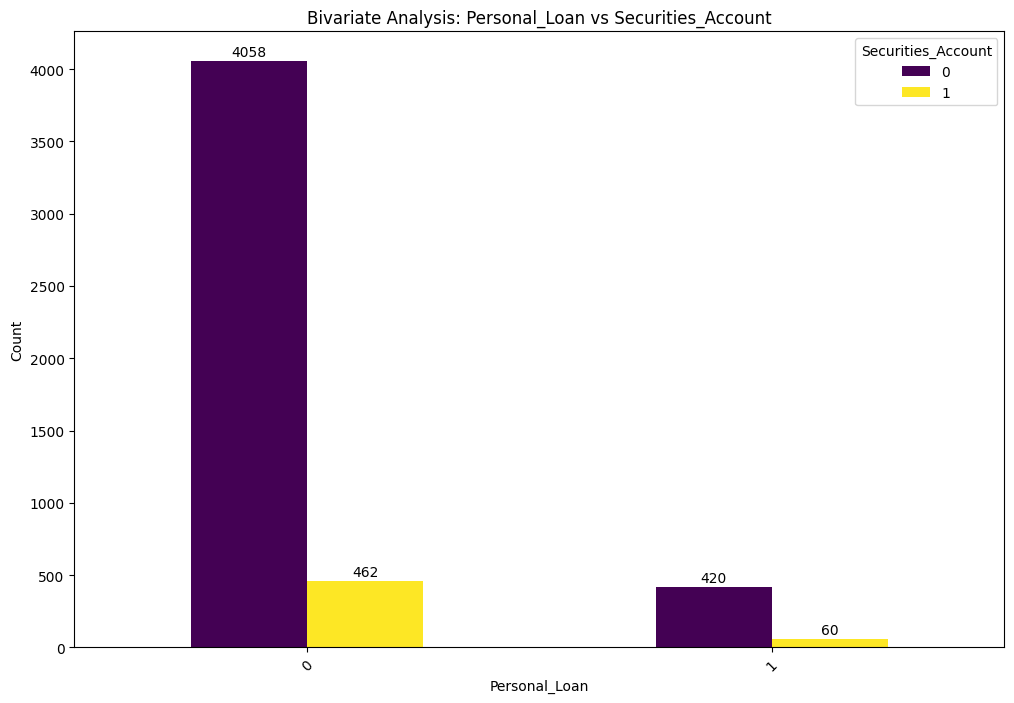

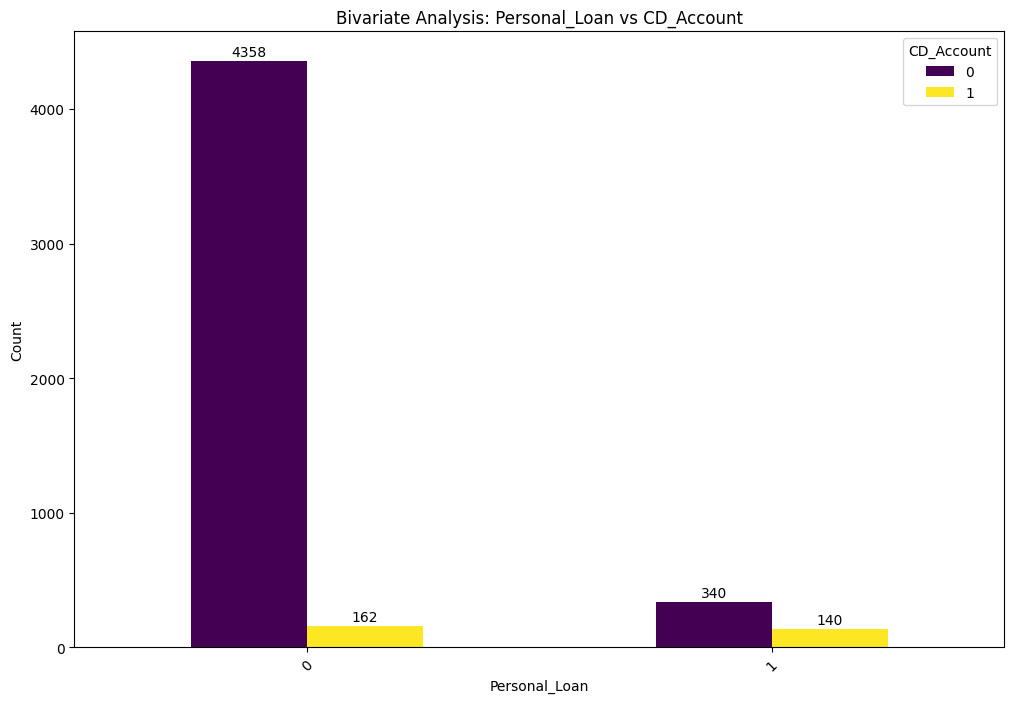

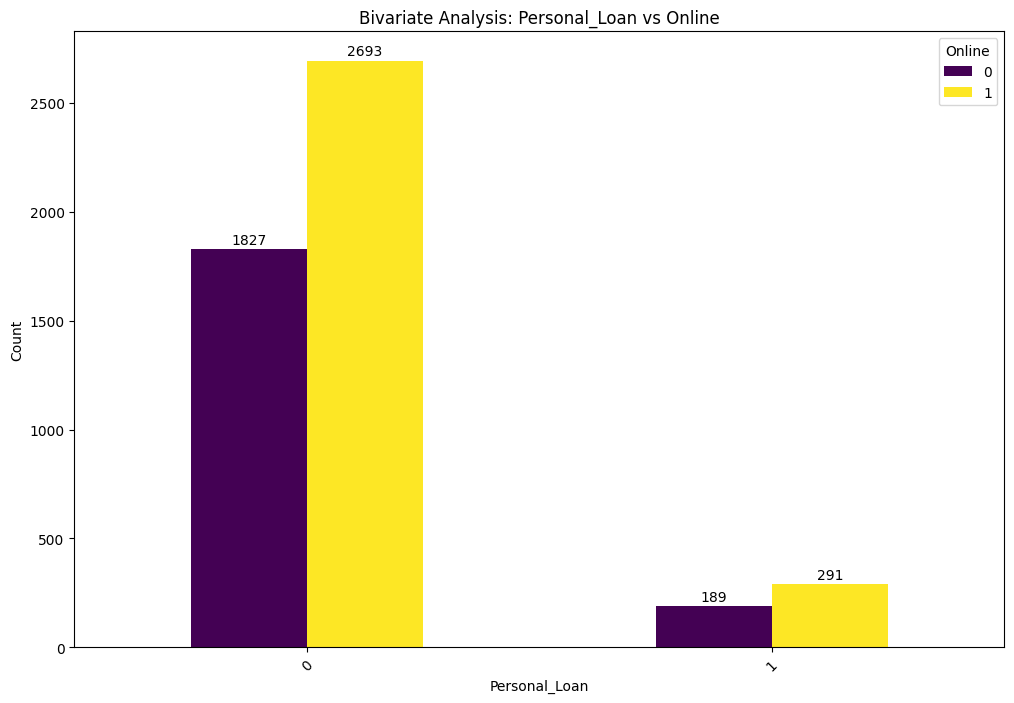

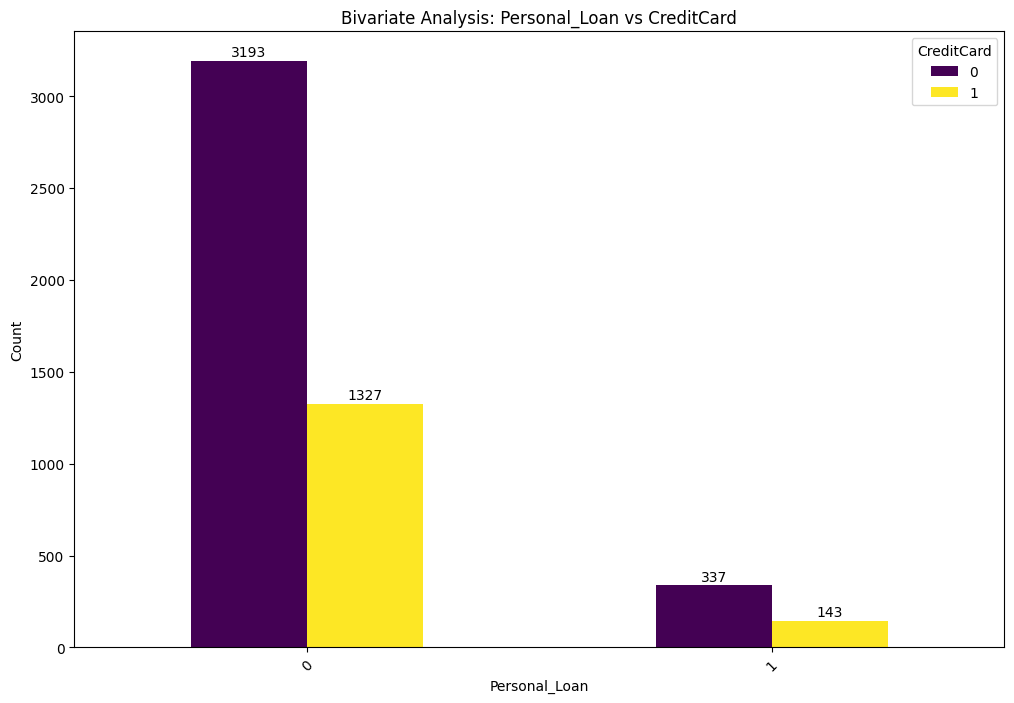

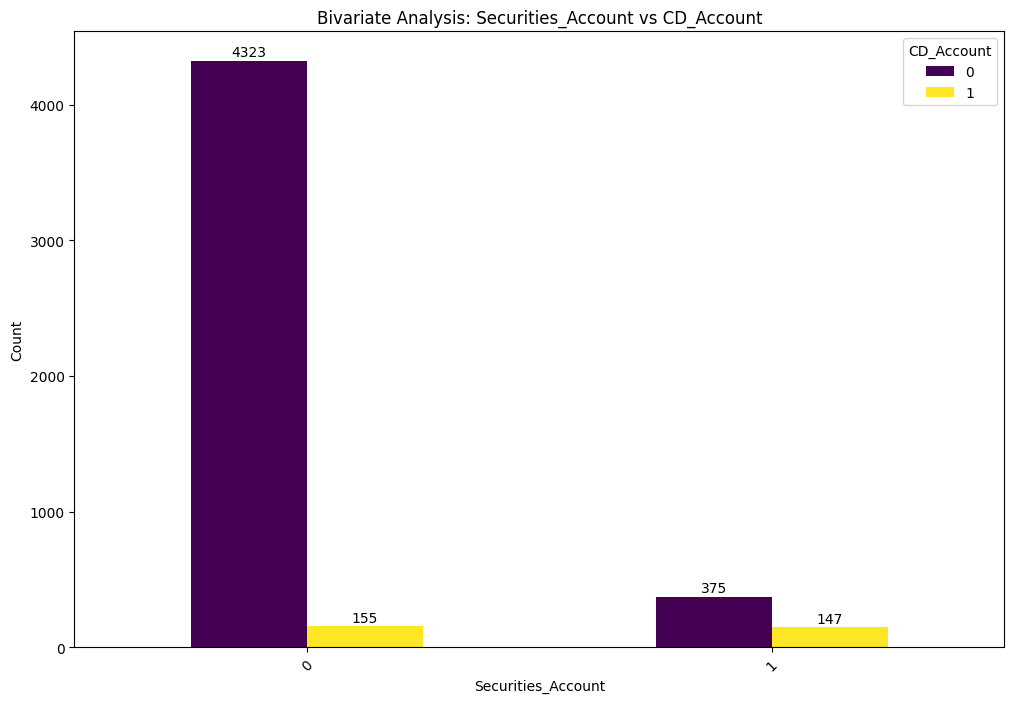

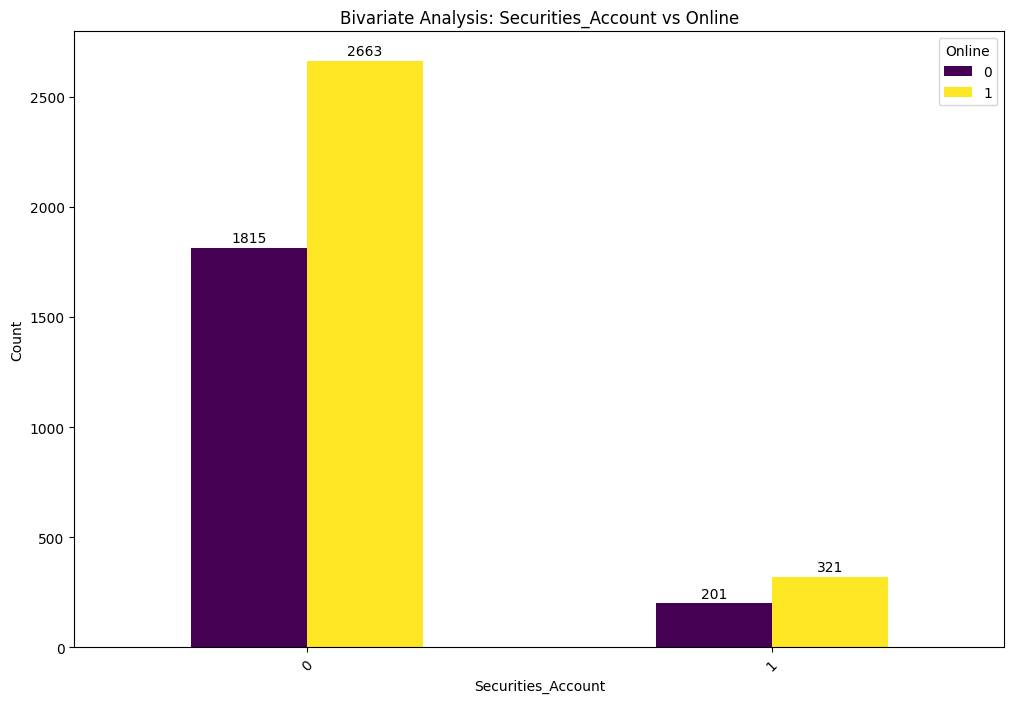

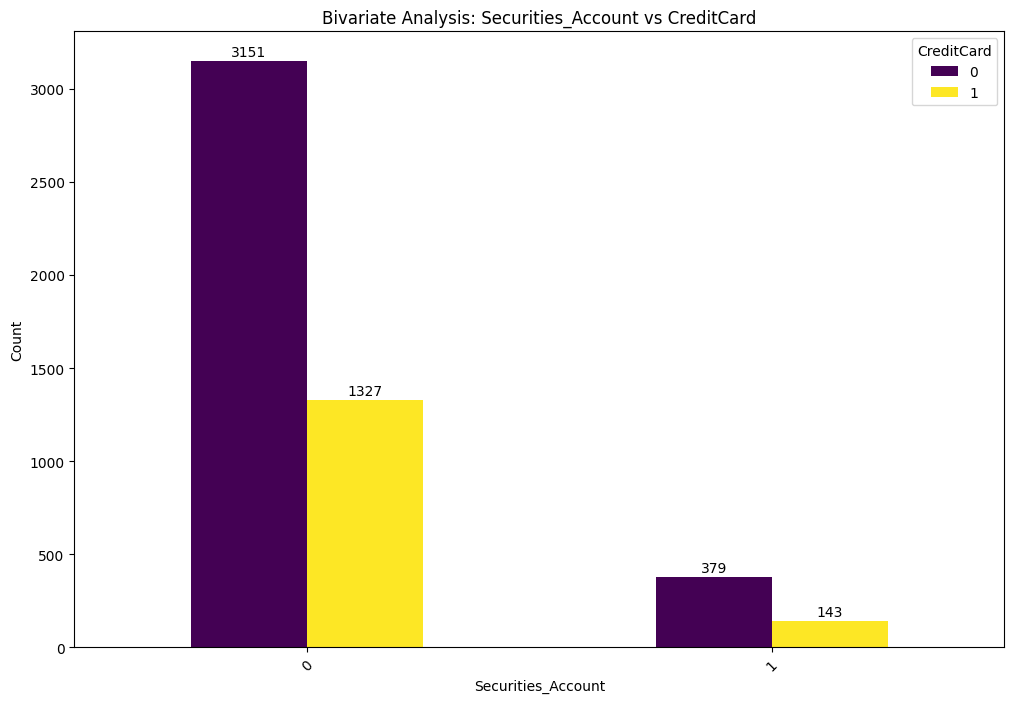

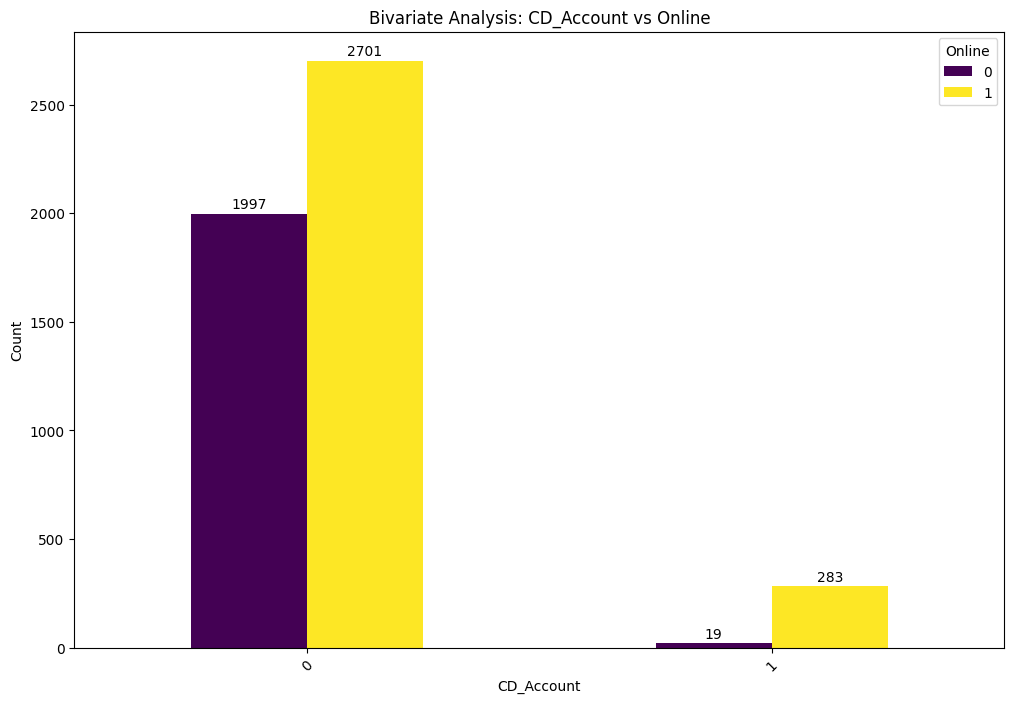

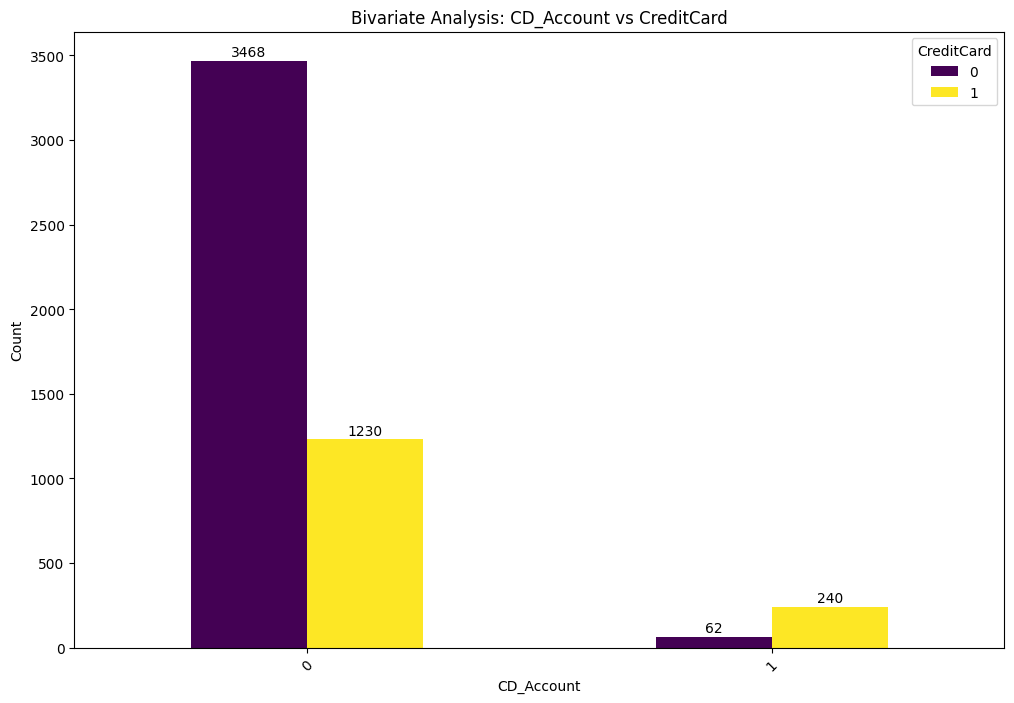

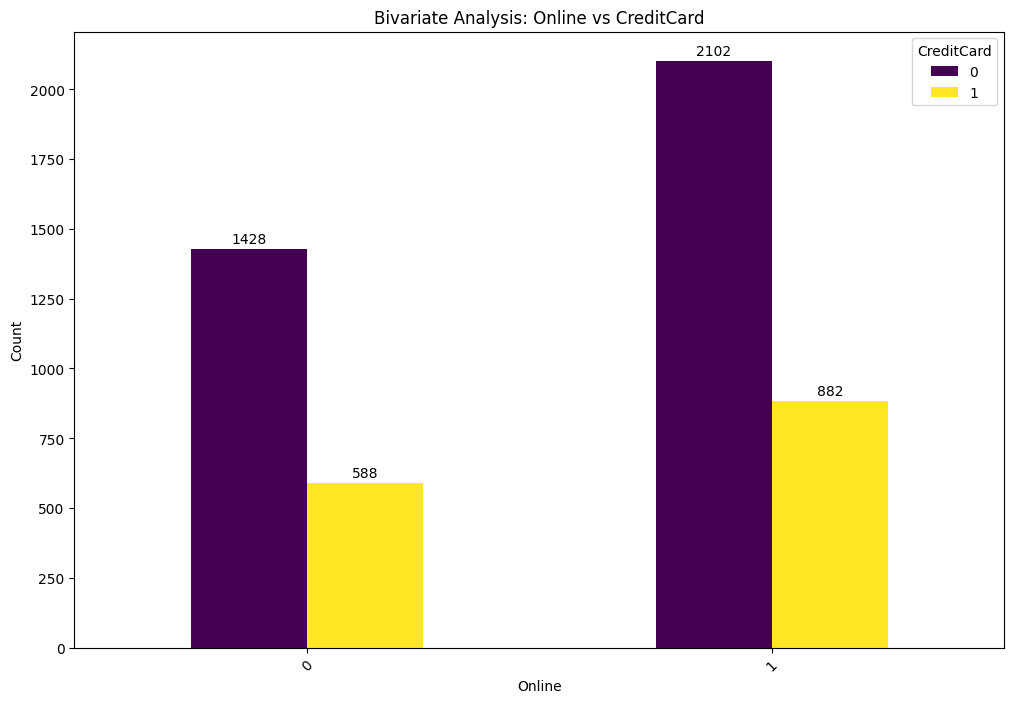

In [78]:
# list of categorical vs. categorical variable pairs
cat_vs_cat_vars = [
    ('Family', 'Education'),
    ('Family', 'Personal_Loan'),
    ('Education', 'Personal_Loan'),
    ('Family', 'Securities_Account'),
    ('Family', 'CD_Account'),
    ('Family', 'Online'),
    ('Family', 'CreditCard'),
    ('Education', 'Securities_Account'),
    ('Education', 'CD_Account'),
    ('Education', 'Online'),
    ('Education', 'CreditCard'),
    ('Personal_Loan', 'Securities_Account'),
    ('Personal_Loan', 'CD_Account'),
    ('Personal_Loan', 'Online'),
    ('Personal_Loan', 'CreditCard'),
    ('Securities_Account', 'CD_Account'),
    ('Securities_Account', 'Online'),
    ('Securities_Account', 'CreditCard'),
    ('CD_Account', 'Online'),
    ('CD_Account', 'CreditCard'),
    ('Online', 'CreditCard')
]

for var1, var2 in cat_vs_cat_vars:
    bivariate_cat_cat(df, var1, var2)

# Observations for Categorical vs. Categorical Variables

**Family vs. Education:**

- Family 1 has the highest count of Education Level 1 (678), indicating it is the most common education level in this family group.
- Family 2 has the most customers with Education Level 1 (657), showing a strong presence of this education level.
- Family 3 and Family 4 have a balanced distribution of education levels, but - Family 3 shows a relatively higher count of Education Level 2 (383) compared to other levels.

**Family vs. Personal_Loan:**

- Family 1 has the highest number of Personal Loan rejections (0) with 1365, indicating fewer loan approvals.
- Family 3 has the highest number of Personal Loan approvals (1) with 133, suggesting a higher rate of loan acceptance among this group.
- Family 2 has a notable number of Personal Loan approvals (1) with 106, though slightly less than Family 3.

**Family vs. Securities_Account:**

- Family 1 has the highest number of Securities Account holders (1) with 142, indicating a stronger preference for securities accounts in this group.
- Family 2 has a high number of Securities Account holders (1) with 135, but slightly fewer than Family 1.
- Family 3 has a lower number of Securities Account holders (1) with 106, indicating less interest compared to other family groups.

**Family vs. CD_Account:**

- Family 1 leads with the highest number of CD Account holders (1), totaling 83 customers, suggesting a relatively higher engagement with CDs.
- Family 2 also shows a high number of CD Account holders (1) with 67, though less than Family 1.
- Family 3 and Family 4 have fewer CD Account holders (1) compared to Family 1 and Family 2.

**Family vs. Online:**

- Family 1 has the highest number of Online users (1) with 883, indicating strong online engagement.
- Family 2 has a considerable number of Online users (1) with 748, showing good online adoption.
- Family 3 and Family 4 have lower numbers of Online users (1) compared to Family 1 and Family 2.

**Family vs. CreditCard:**

- Family 1 has the highest number of Credit Card holders (1) with 410, suggesting more use of credit cards in this family group.
- Family 2 also shows a significant number of Credit Card holders (1) with 403, though slightly less than Family 1.
- Family 3 has a lower count of Credit Card holders (1) with 291, indicating less usage compared to Families 1 and 2.

**Education vs. Personal_Loan:**

- Education Level 1 has the highest count of Personal Loan rejections (0) with 2003, reflecting the most significant number of rejections.
- Education Level 3 has the highest count of Personal Loan approvals (1) with 205, indicating a higher rate of loan acceptance among more educated individuals.
- Education Level 2 also shows a significant number of approvals (182), suggesting a moderate acceptance rate.


**Education vs. Securities_Account:**

- Education Level 1 has the highest number of Securities Account holders (1) with 224, suggesting a greater interest in securities accounts among this education level.
- Education Level 2 has 150 Securities Account holders (1), which is lower compared to Education Level 1.
- Education Level 3 has 148 Securities Account holders (1), showing a similar level of interest as Education Level 2.

**Education vs. CD_Account**:

- Education Level 1 has the highest number of CD Account holders (1) with 118, indicating a higher uptake of CDs among this group.
- Education Level 3 follows with 96 CD Account holders (1), showing a moderate interest.
- Education Level 2 has fewer CD Account holders (1) with 88, indicating less engagement compared to Levels 1 and 3.

**Education vs. Online:**

- Education Level 1 has the highest number of Online users (1) with 1255, reflecting strong digital engagement among this group.
- Education Level 3 has a significant number of Online users (1) with 869, indicating good online adoption.
- Education Level 2 has fewer Online users (1) with 860, showing lower digital engagement compared to Levels 1 and 3.

**Education vs. CreditCard:**

- Education Level 1 has the highest number of Credit Card holders (1) with 633, indicating a high usage of credit cards.
- Education Level 3 follows with 437 Credit Card holders (1), showing good credit card engagement.
- Education Level 2 has 400 Credit Card holders (1), which is lower compared to Levels 1 and 3.

**Personal_Loan vs. Securities_Account:**

- Personal Loan applicants with Securities Accounts (1) are significantly lower (60) compared to non-holders (462), indicating a lower approval rate among securities account holders.
- Personal Loan rejections (0) show a higher count for non-securities account holders (4058) compared to holders (462), suggesting more rejections among non-holders.

**Personal_Loan vs. CD_Account:**

- Personal Loan rejections (0) are higher for customers without CD Accounts (4358) compared to those with CD Accounts (162), indicating more rejections among non-holders.
- Personal Loan approvals (1) are higher for customers with CD Accounts (140) compared to non-holders (340), showing a higher approval rate among CD account holders.

**Personal_Loan vs. Online:**

- Personal Loan rejections (0) are higher among online users (2693) compared to non-users (1827), indicating more rejections among online users.
- Personal Loan approvals (1) are higher among non-online users (189) compared to online users (291), suggesting a higher approval rate for non-users.

**Personal_Loan vs. CreditCard:**

- Personal Loan rejections (0) are higher for customers with credit cards from other banks (3193) compared to those without (337), indicating more rejections among credit card holders.
- Personal Loan approvals (1) are higher for customers without credit cards (143) compared to those with credit cards (337), showing a higher approval rate among non-holders.

**Securities_Account vs. CD_Account:**

- Securities Account holders (1) have fewer CD Account holders (1) with 19, compared to non-holders with 1997, indicating lower engagement with CDs among securities account holders.
- Securities Account non-holders (0) show a higher count of CD Account holders (1) with 2701, reflecting higher CD engagement among this group.

**Securities_Account vs. Online:**

- Securities Account holders (1) are fewer among online users (321) compared to non-users (2663), indicating lower online usage among securities account holders.
- Securities Account non-holders (0) have a higher count of Online users (2663), showing greater online engagement.

**Securities_Account vs. CreditCard:**

- Securities Account holders (1) have fewer Credit Card holders (1) with 143, compared to non-holders with 1327, indicating lower credit card usage among securities account holders.
- Securities Account non-holders (0) show a higher count of Credit Card holders (1) with 1327, suggesting greater credit card engagement.

**CD_Account vs. Online:**

- CD Account holders (1) have fewer Online users (1) with 283, compared to non-holders with 2701, reflecting lower online usage among CD account holders.
- CD Account non-holders (0) have a higher count of Online users (1) with 2701, indicating more online engagement.

**CD_Account vs. CreditCard:**

- CD Account holders (1) have fewer Credit Card holders (1) with 240, compared to non-holders with 1230, indicating lower credit card usage among CD account holders.
- CD Account non-holders (0) show a higher count of Credit Card holders (1) with 1230, suggesting greater credit card engagement.

**Online vs. CreditCard:**

- Online users (1) have a higher number of Credit Card holders (1) with 882, compared to non-users with 588, indicating a greater credit card usage among online users.
- Non-online users (0) have fewer Credit Card holders (1) with 588, reflecting less engagement compared to online users.

**Categorical vs. Continuous and Continuous vs. Categorical Variables**

ANOVA test result: F-statistic = 7.764896510501902, p-value = 3.593888681988156e-05




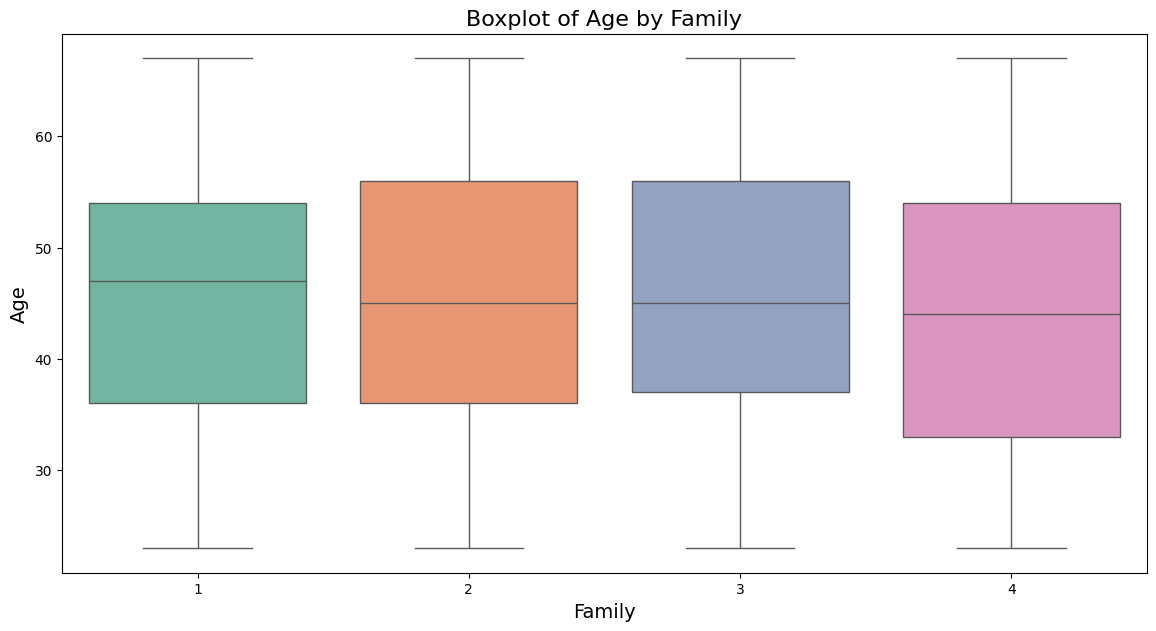

ANOVA test result: F-statistic = 61.817366088251724, p-value = 3.087041046404791e-39




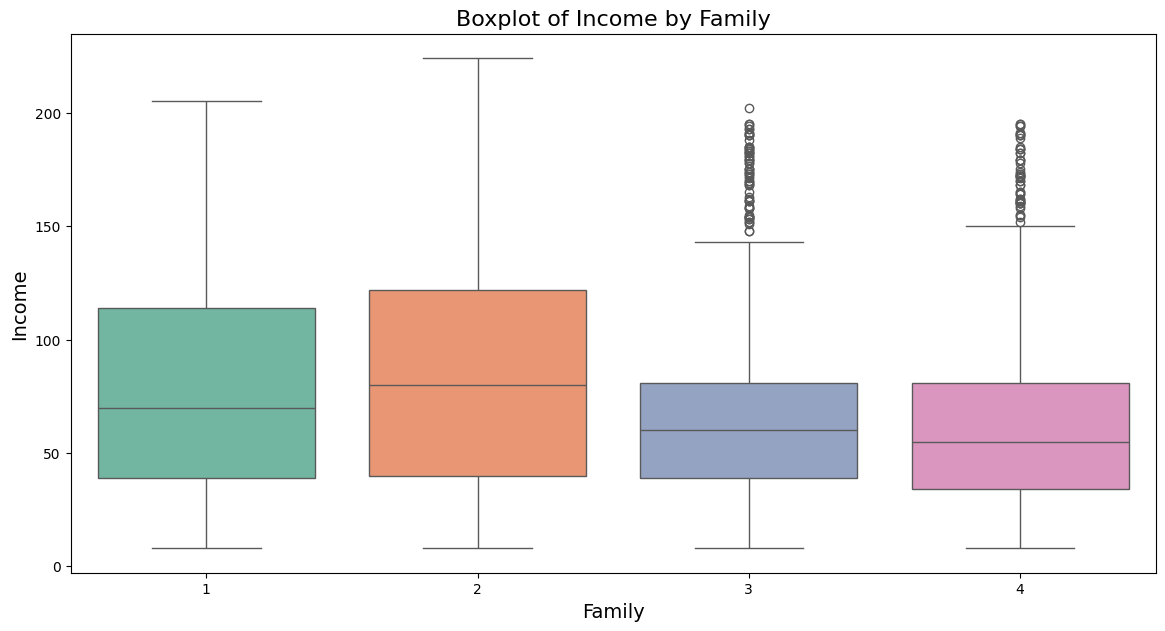

ANOVA test result: F-statistic = 7.80185160226732, p-value = 3.408396472908413e-05




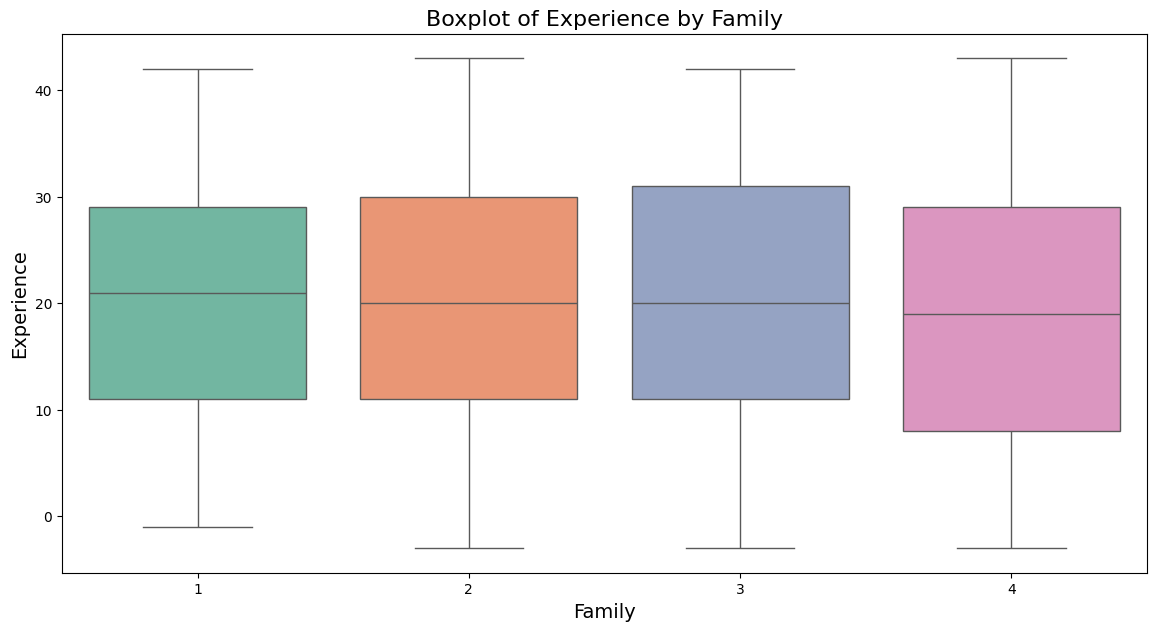

ANOVA test result: F-statistic = 5.2793241747231265, p-value = 0.005124335504857915




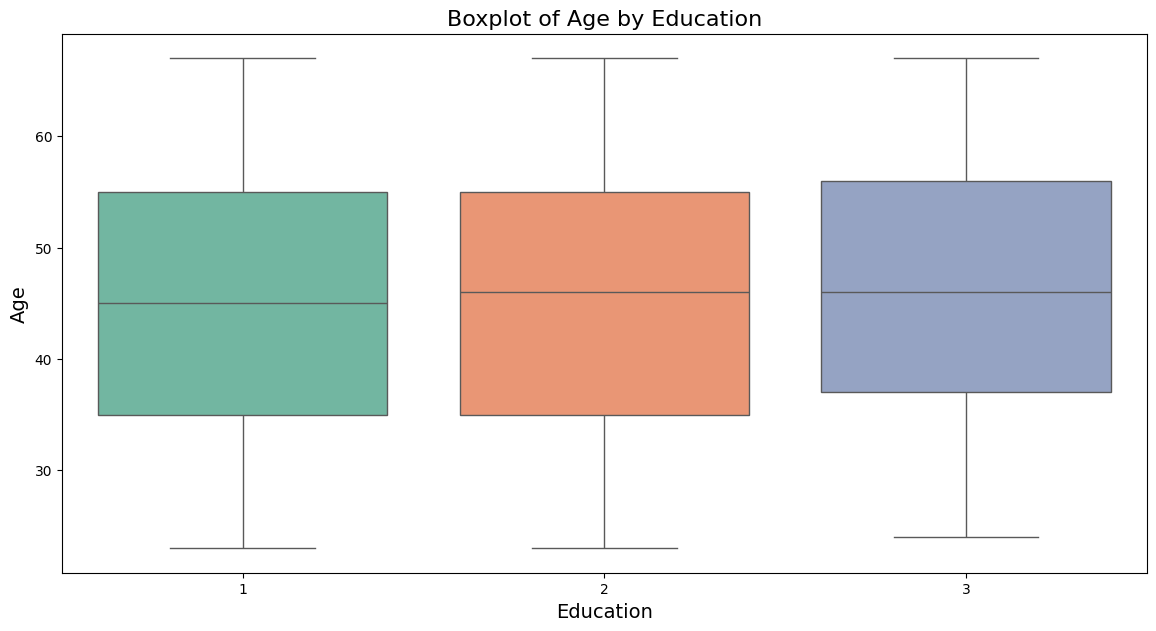

ANOVA test result: F-statistic = 125.30275492552306, p-value = 7.985513982293451e-54




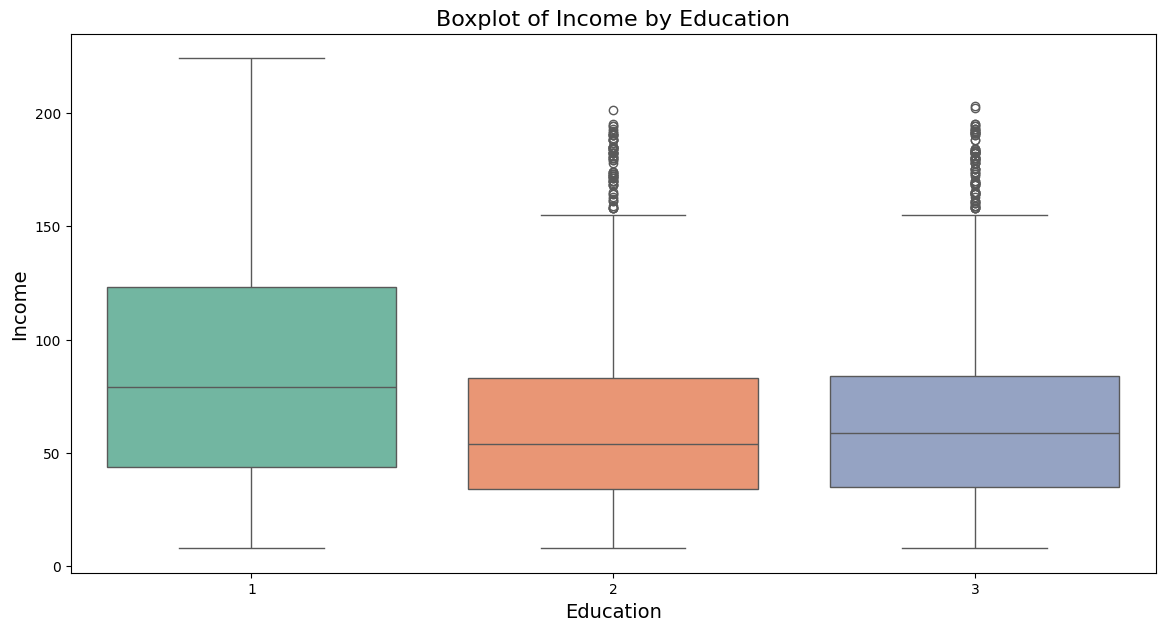

ANOVA test result: F-statistic = 1.3768822487552401, p-value = 0.25245986345855526




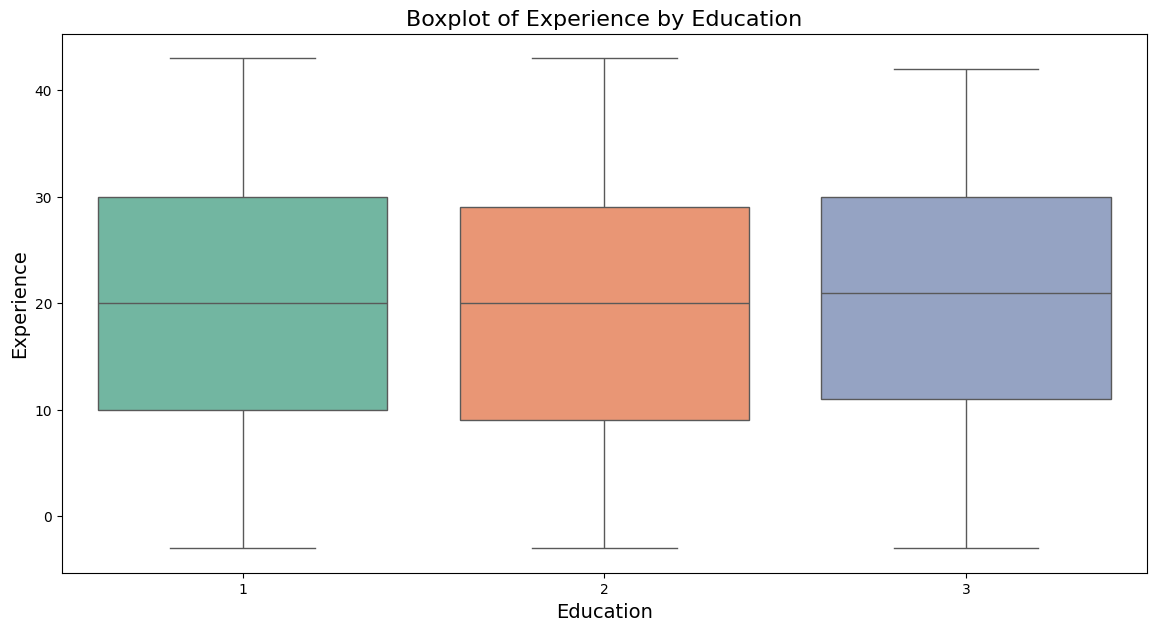

ANOVA test result: F-statistic = 0.2983242387687329, p-value = 0.5849592637022671




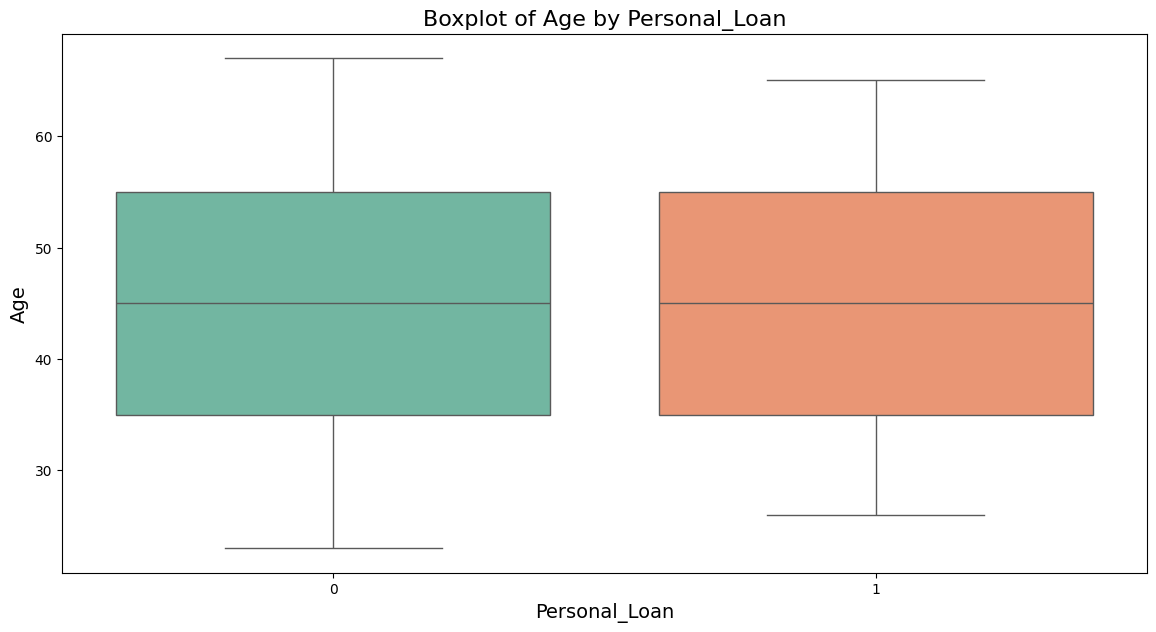

ANOVA test result: F-statistic = 1688.0045804960757, p-value = 3.56029e-318




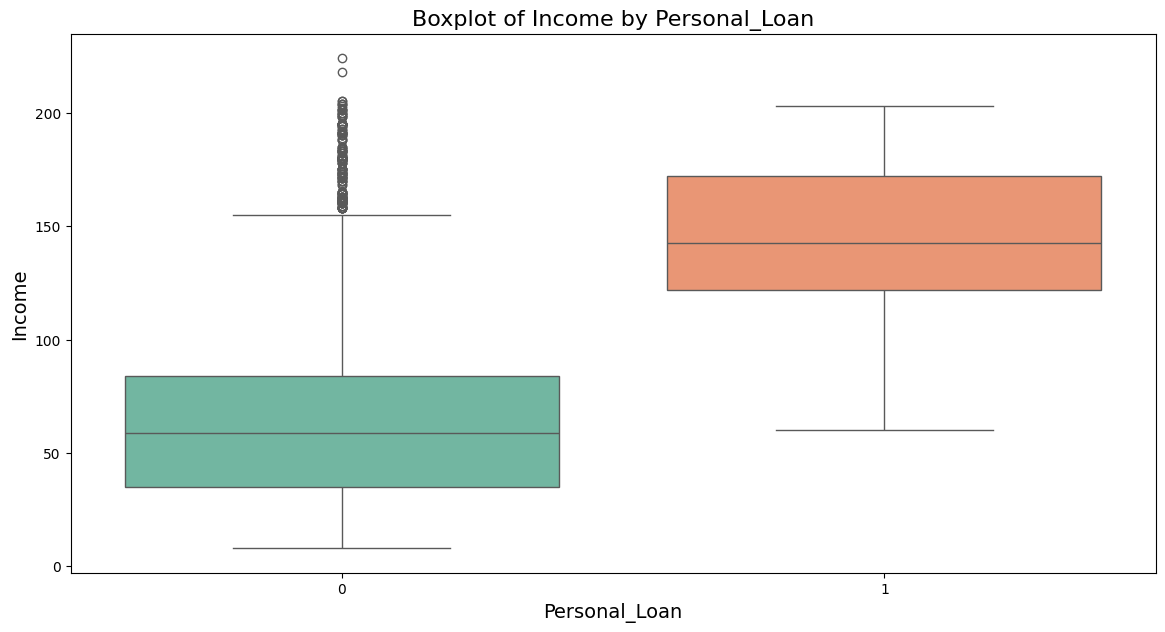

ANOVA test result: F-statistic = 0.27467530194576933, p-value = 0.6002358831617367




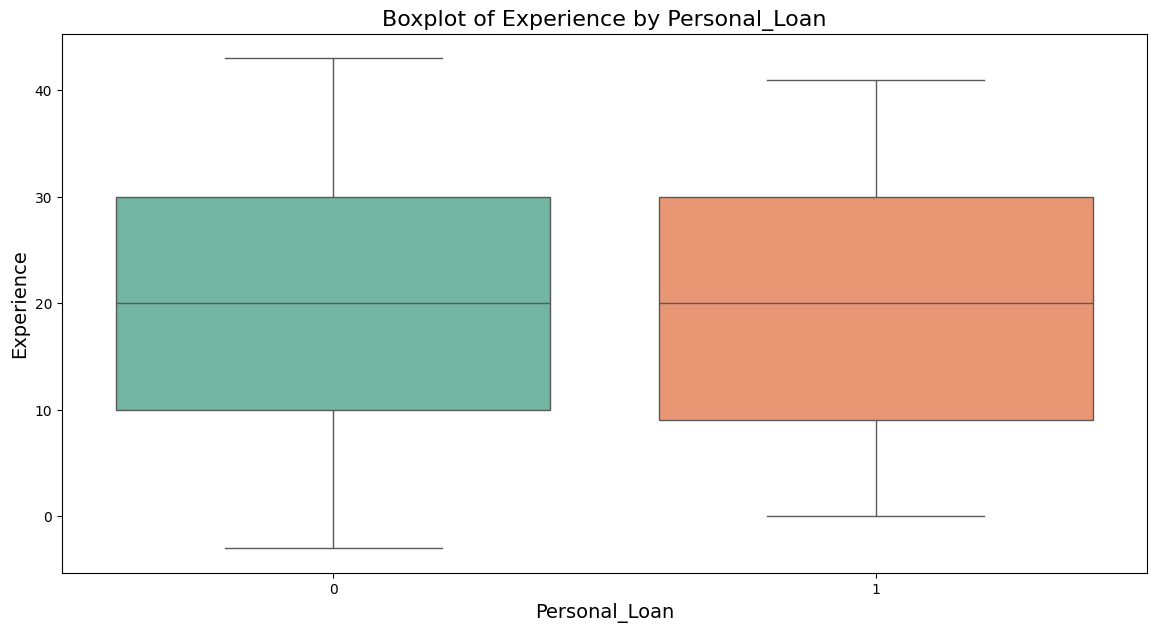

ANOVA test result: F-statistic = 0.0009511559539955791, p-value = 0.9753977205562969




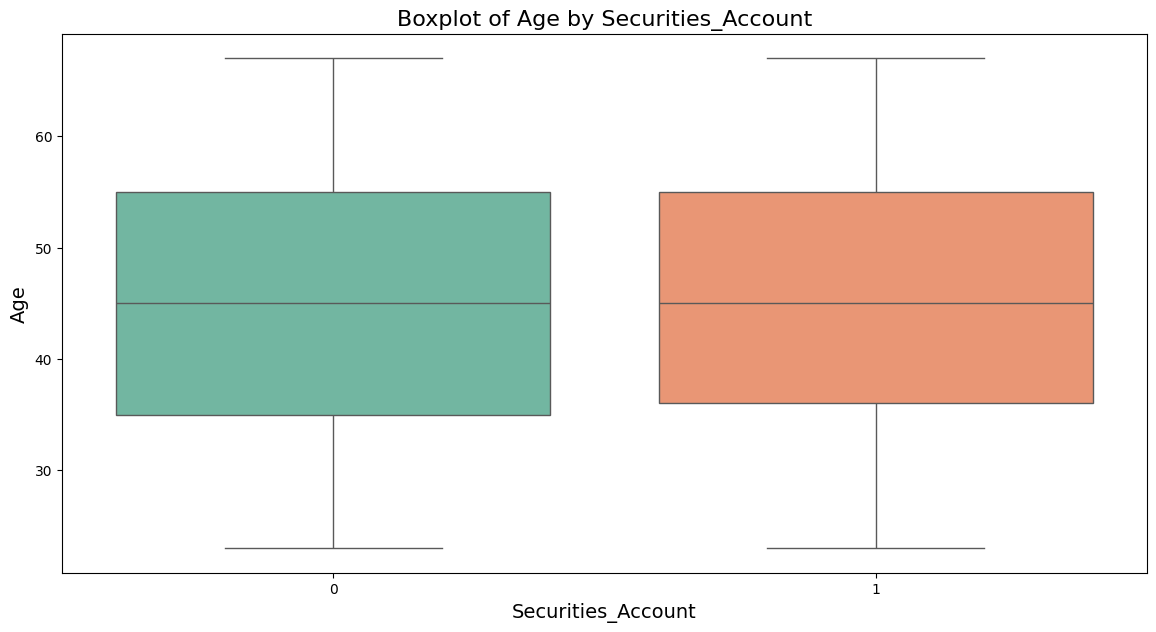

ANOVA test result: F-statistic = 0.03421681711544695, p-value = 0.8532538885891556




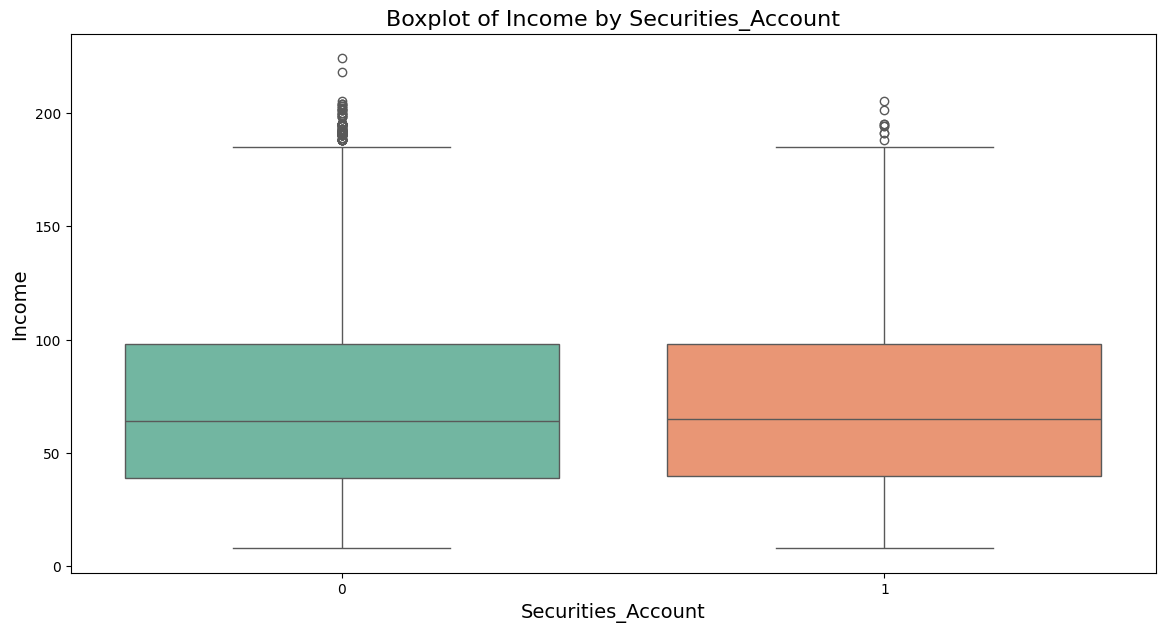

ANOVA test result: F-statistic = 0.007587751199144567, p-value = 0.9305893953634227




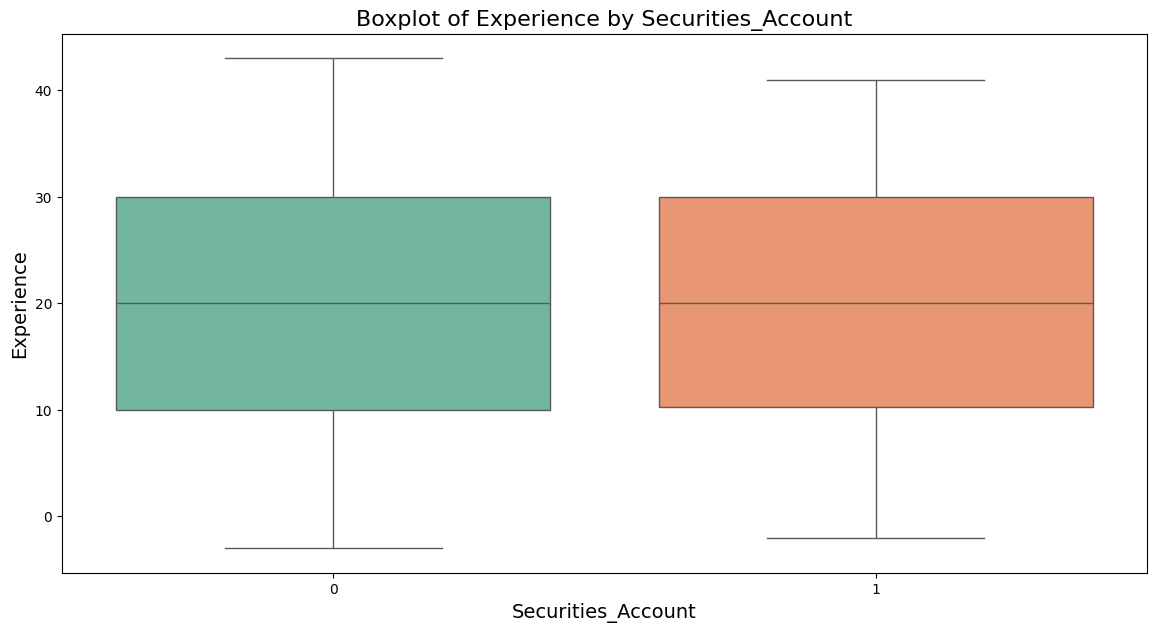

ANOVA test result: F-statistic = 0.32330477211886877, p-value = 0.5696538803243143




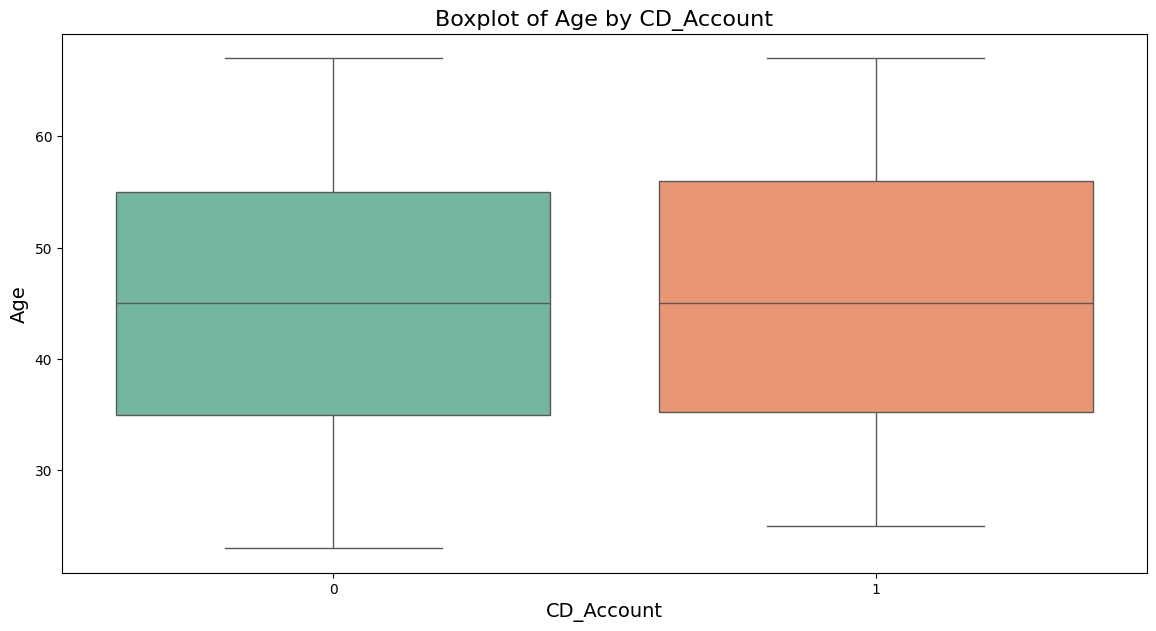

ANOVA test result: F-statistic = 148.26924506946867, p-value = 1.2357375258873452e-33




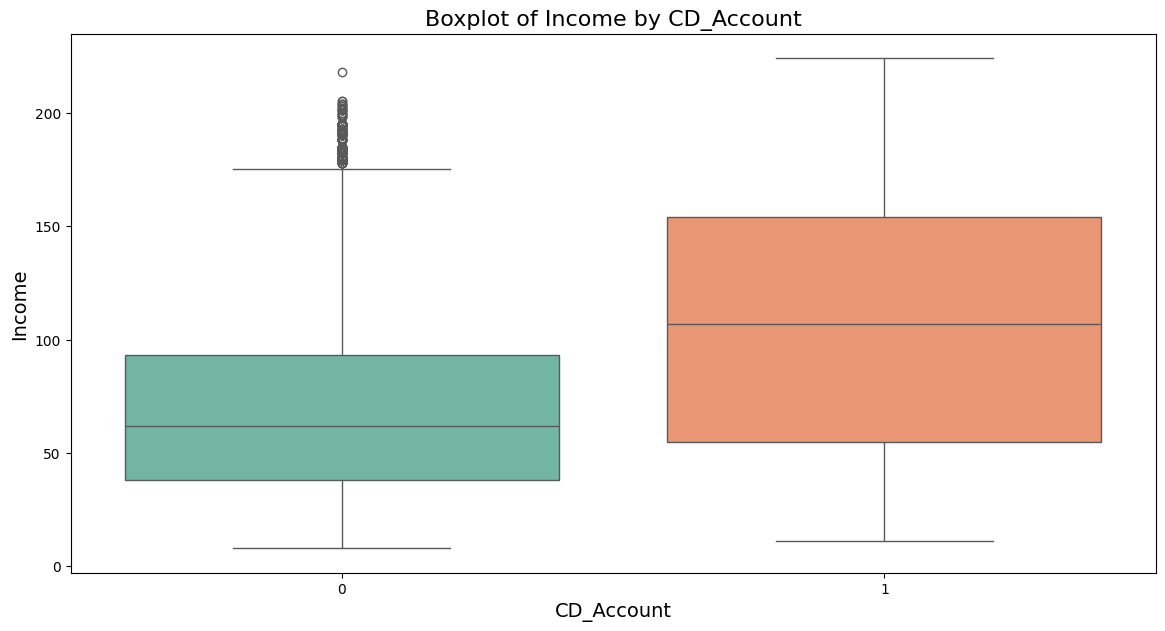

ANOVA test result: F-statistic = 0.5358003798932278, p-value = 0.4642127361339917




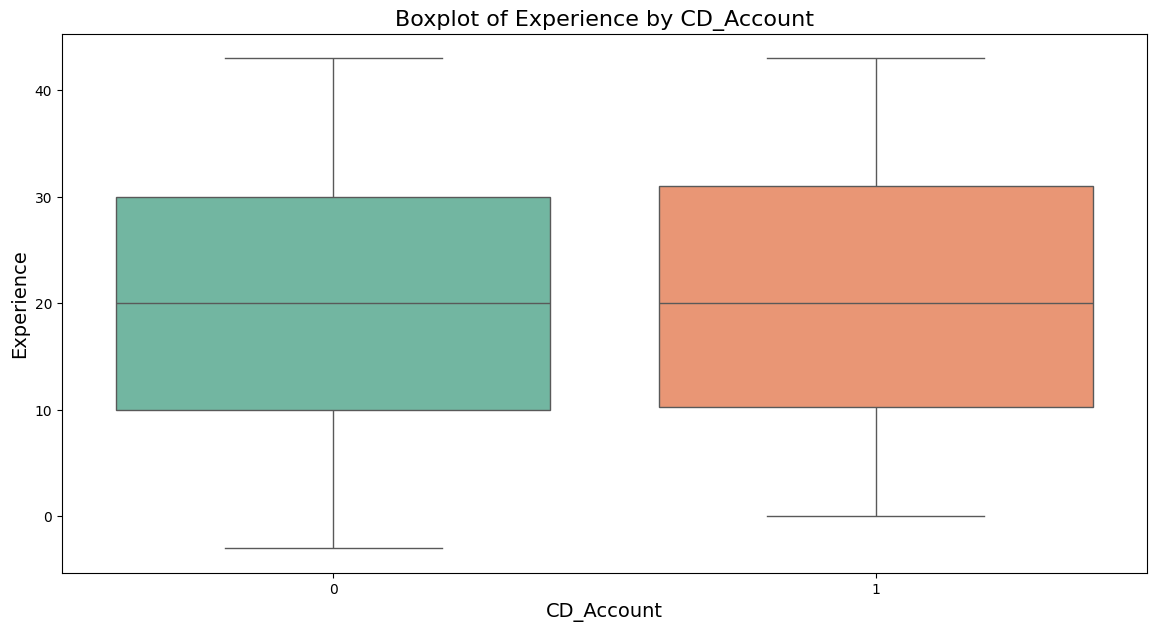

ANOVA test result: F-statistic = 0.9385798225832827, p-value = 0.33269022104918355




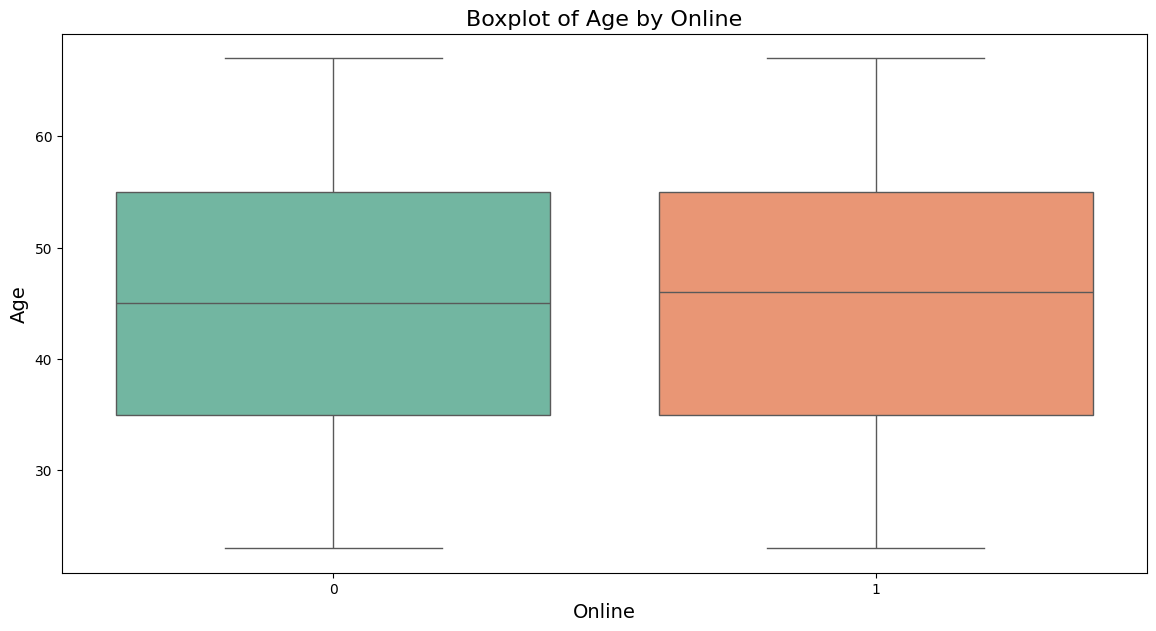

ANOVA test result: F-statistic = 1.0088406943033237, p-value = 0.31522935716484124




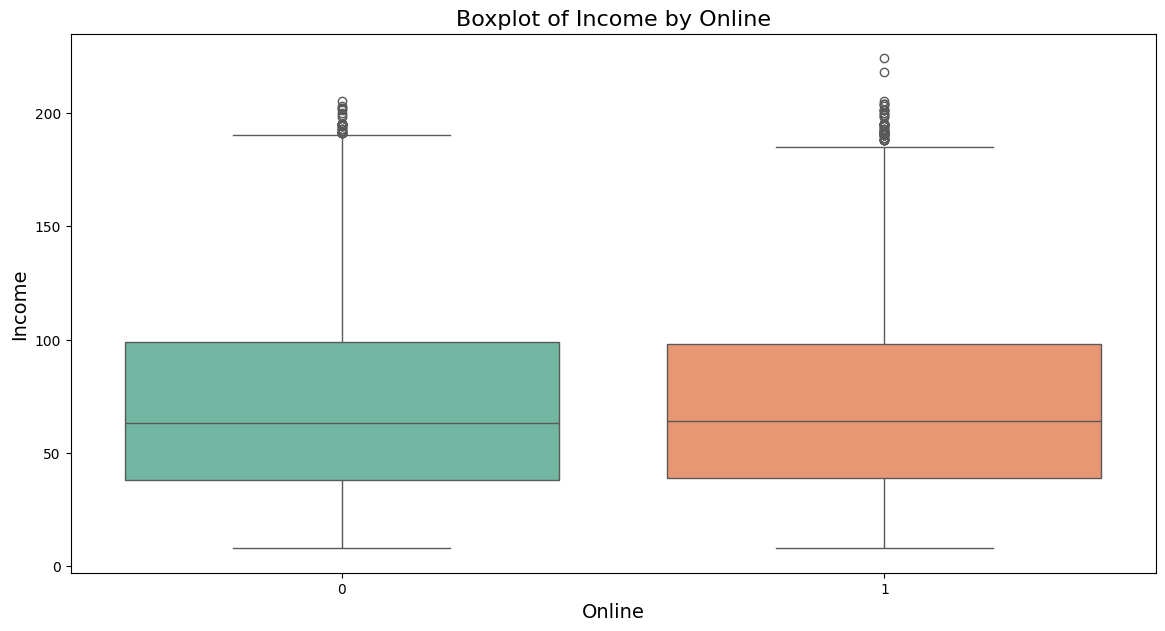

ANOVA test result: F-statistic = 0.9655582583879341, p-value = 0.32583800324201073




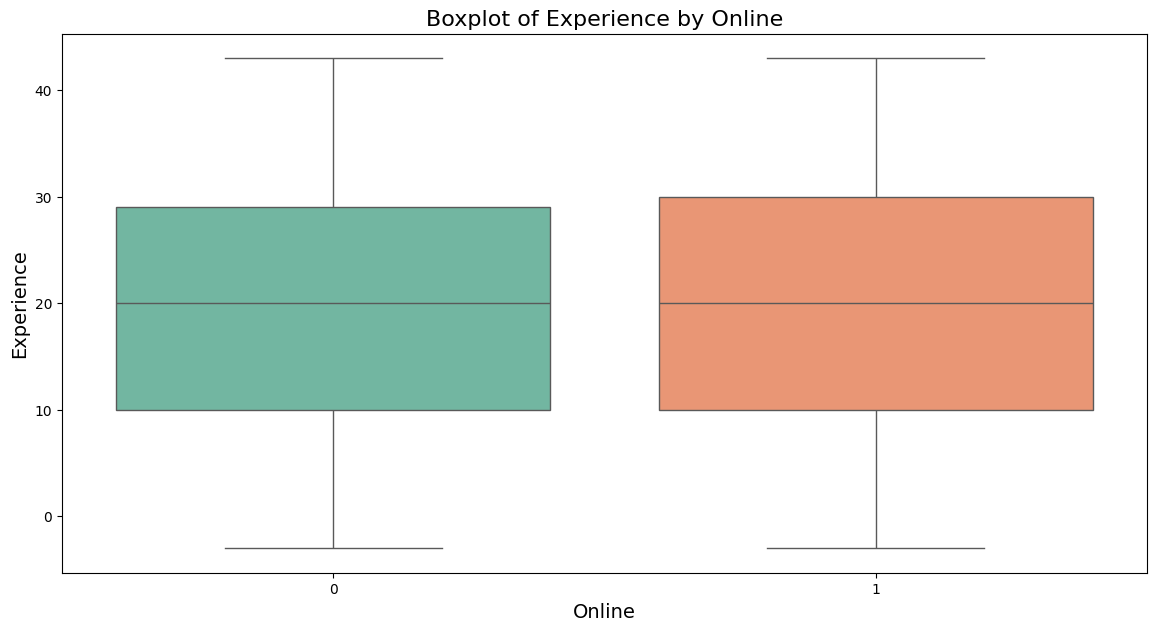

ANOVA test result: F-statistic = 0.29489102988656235, p-value = 0.5871273728112382




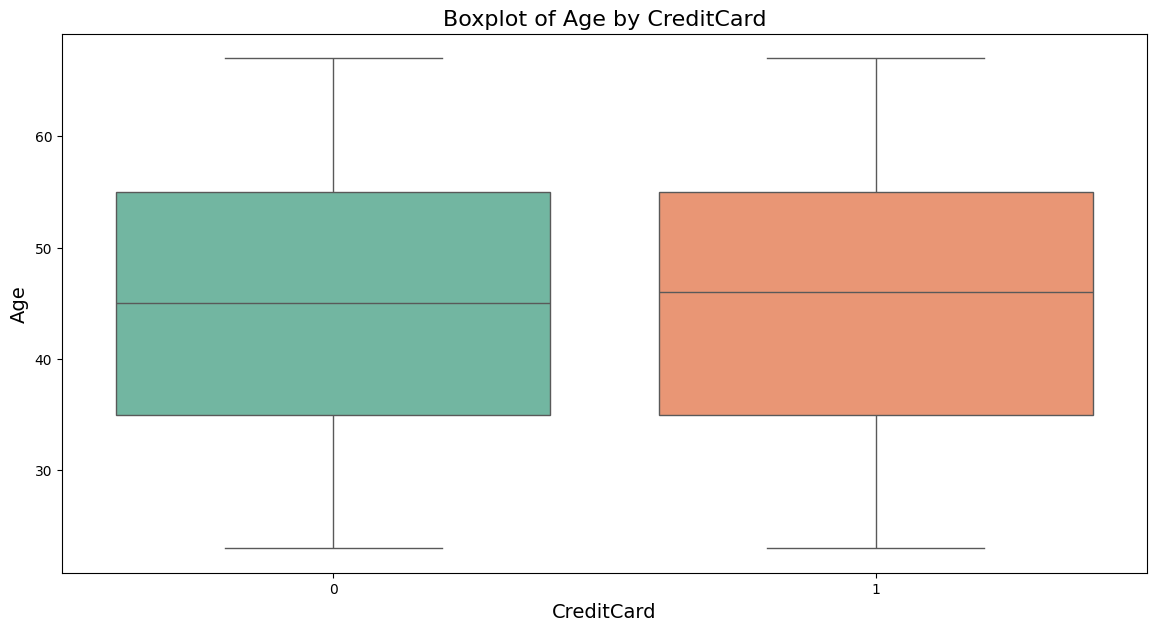

ANOVA test result: F-statistic = 0.028430095058946912, p-value = 0.8661084574119506




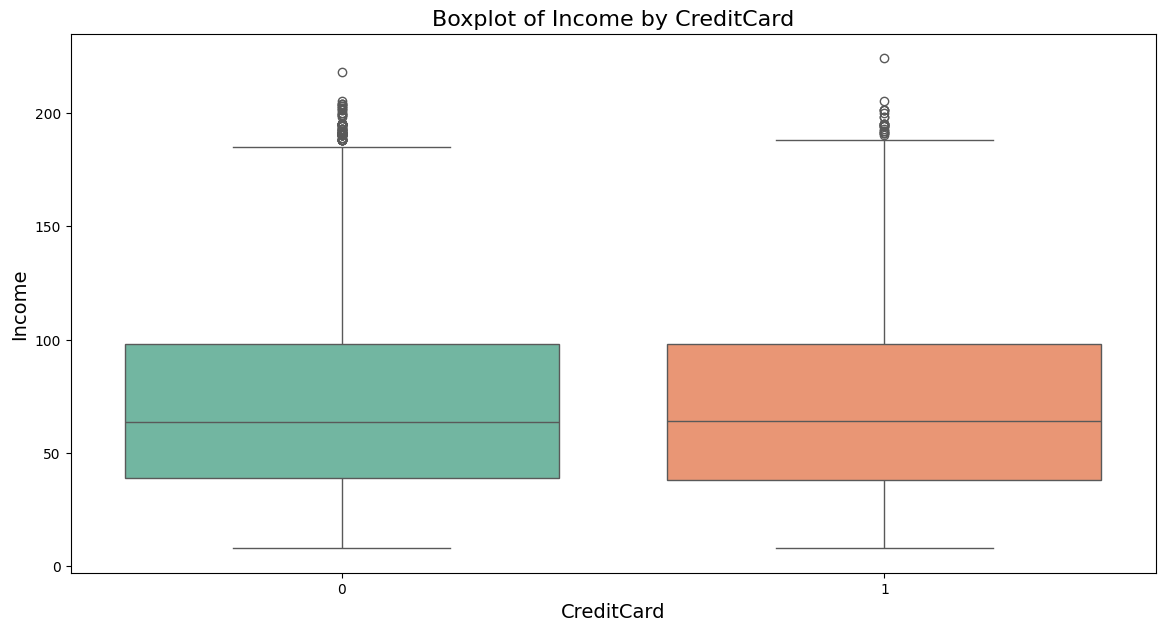

ANOVA test result: F-statistic = 0.40194705095597905, p-value = 0.5261144417177714




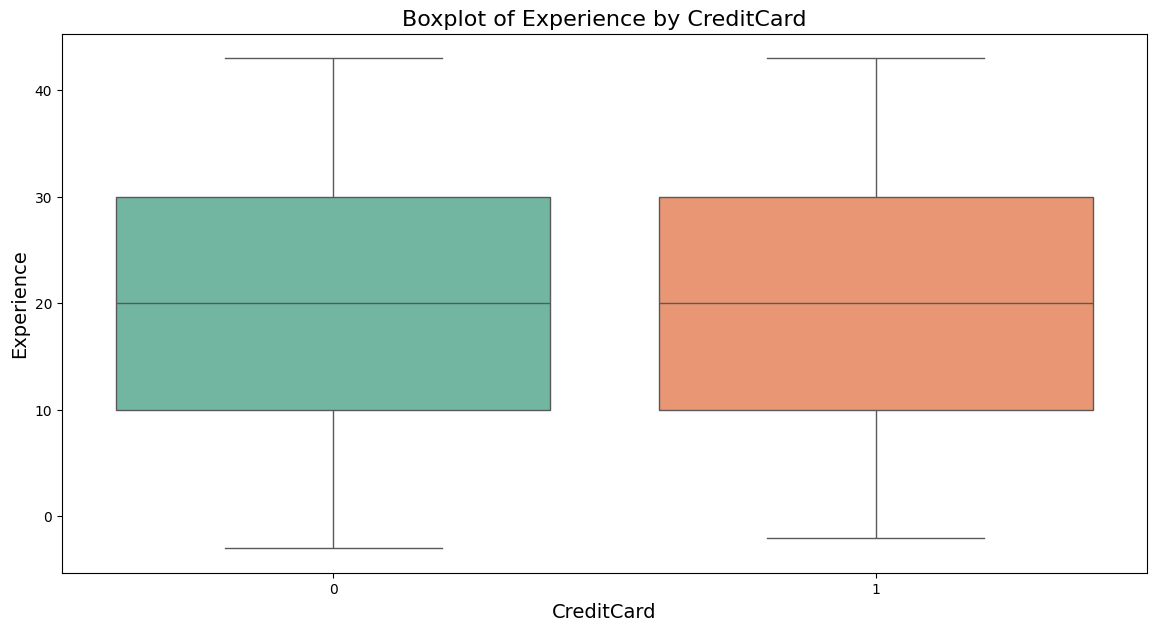

In [79]:
cat_vs_cont_vars = [
    ('Family', 'Age'),
    ('Family', 'Income'),
    ('Family', 'Experience'),
    ('Education', 'Age'),
    ('Education', 'Income'),
    ('Education', 'Experience'),
    ('Personal_Loan', 'Age'),
    ('Personal_Loan', 'Income'),
    ('Personal_Loan', 'Experience'),
    ('Securities_Account', 'Age'),
    ('Securities_Account', 'Income'),
    ('Securities_Account', 'Experience'),
    ('CD_Account', 'Age'),
    ('CD_Account', 'Income'),
    ('CD_Account', 'Experience'),
    ('Online', 'Age'),
    ('Online', 'Income'),
    ('Online', 'Experience'),
    ('CreditCard', 'Age'),
    ('CreditCard', 'Income'),
    ('CreditCard', 'Experience')
]

# Call the method for each categorical vs. continuous pair
for cat_var, cont_var in cat_vs_cont_vars:
    bivariate_cat_cont(df, cat_var, cont_var)

# Observations for Categorical and Continous Variables:

**Family vs Age**

- Family sizes 1 and 3 have the highest mean ages of 45.76 and 46.12 respectively.
- Family size 4 has the lowest mean age of 44.02.
- The ANOVA test shows a significant difference in mean ages between different family sizes (p-value = 3.59e-05).

**Family vs Income**

- Family sizes 1 and 2 have higher mean incomes (78.62 and 84.24 respectively) compared to family sizes 3 and 4 (66.90 and 62.51 respectively).
- The ANOVA test indicates significant income differences among family sizes (p-value = 3.09e-39).

**Family vs Experience**

- Family size 4 has the lowest mean experience (18.75), while family sizes 1, 2, and 3 have similar mean experiences (around 20.6, 20.3, and 20.7 respectively).
- The ANOVA test suggests a significant difference in experience among family sizes (p-value = 3.41e-05).

**Education vs Age**

- Individuals with education level 3 have the highest mean age (46.14), followed by those with education levels 2 and 1 (45.04 and 44.96 respectively).
- The ANOVA test shows significant age differences across education levels (p-value = 0.005).

**Education vs Income**

- Individuals with education level 1 have the highest mean income (85.59), followed by education levels 2 and 3 (64.31 and 66.12 respectively).
- The ANOVA test indicates significant income differences among education levels (p-value = 7.99e-54).

**Education vs Experience**

- Mean experience is fairly similar across all education levels, with education level 3 slightly higher (20.47).
- The ANOVA test shows no significant difference in experience among education levels (p-value = 0.25).

**Personal Loan vs Age**

- The mean ages of individuals who did and did not take a personal loan are very close (45.07 and 45.37 respectively).
- The ANOVA test indicates no significant difference in age between personal loan statuses (p-value = 0.58).

**Personal Loan vs Income**

- Individuals who took a personal loan have a much higher mean income (144.75) compared to those who did not (66.24).
- The ANOVA test shows a highly significant difference in income between personal loan statuses (p-value ≈ 0).

**Personal Loan and Experience**

- Mean experience is very similar for individuals who did and did not take a personal loan (19.84 and 20.13 respectively).
- The ANOVA test indicates no significant difference in experience between personal loan statuses (p-value = 0.60).

**Securities Account vs Age**

- Mean ages are almost identical for individuals with and without a securities account (45.32 and 45.34 respectively).
- The ANOVA test shows no significant difference in age between securities account statuses (p-value = 0.98).

**Securities Account vs Income**

- Mean incomes are very similar for individuals with and without a securities account (73.42 and 73.82 respectively).
- The ANOVA test indicates no significant difference in income between securities account statuses (p-value = 0.85).

**Securities Account vs Experience**

- Mean experience is almost identical for individuals with and without a securities account (20.06 and 20.11 respectively).
- The ANOVA test shows no significant difference in experience between securities account statuses (p-value = 0.93).

**CD Account vs Age**

- Mean ages are very close for individuals with and without a CD account (45.70 and 45.32 respectively).
- The ANOVA test indicates no significant difference in age between CD account statuses (p-value = 0.57).

**CD Account vs Income**

- Individuals with a CD account have a higher mean income (104.59) compared to those without (71.79).
- The ANOVA test shows a highly significant difference in income between CD account statuses (p-value ≈ 0).

**CD Account and Experience**

- Mean experiences are very similar for individuals with and without a CD account (20.57 and 20.07 respectively).
- The ANOVA test indicates no significant difference in experience between CD account statuses (p-value = 0.46).

Summary
- Family size, education, and personal loan status show significant differences in income.
- Age and experience generally do not vary significantly across the different categories analyzed.
- Having a CD account or personal loan is associated with higher income, but other financial products like securities accounts do not show significant income differences.

**Continues Vs continous Variables Bivariate Analysis**

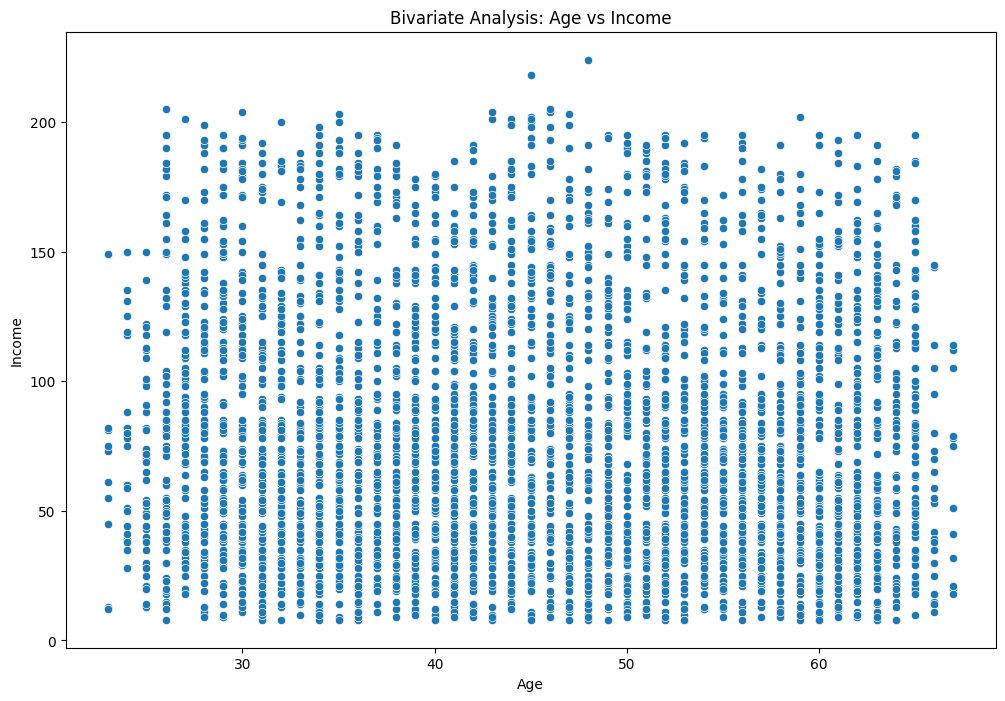

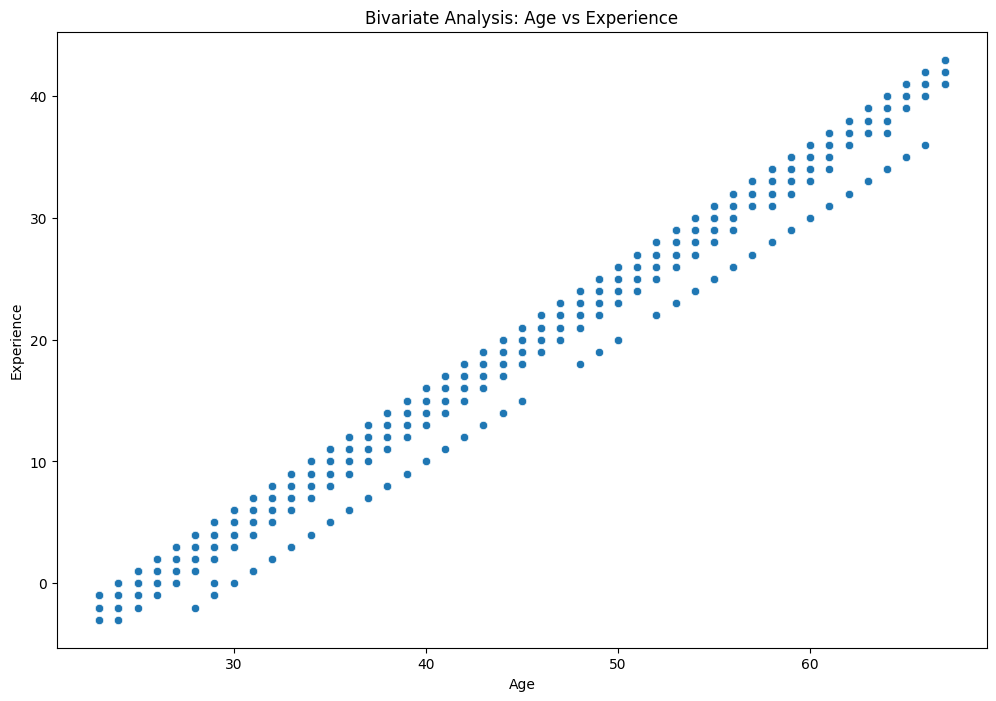

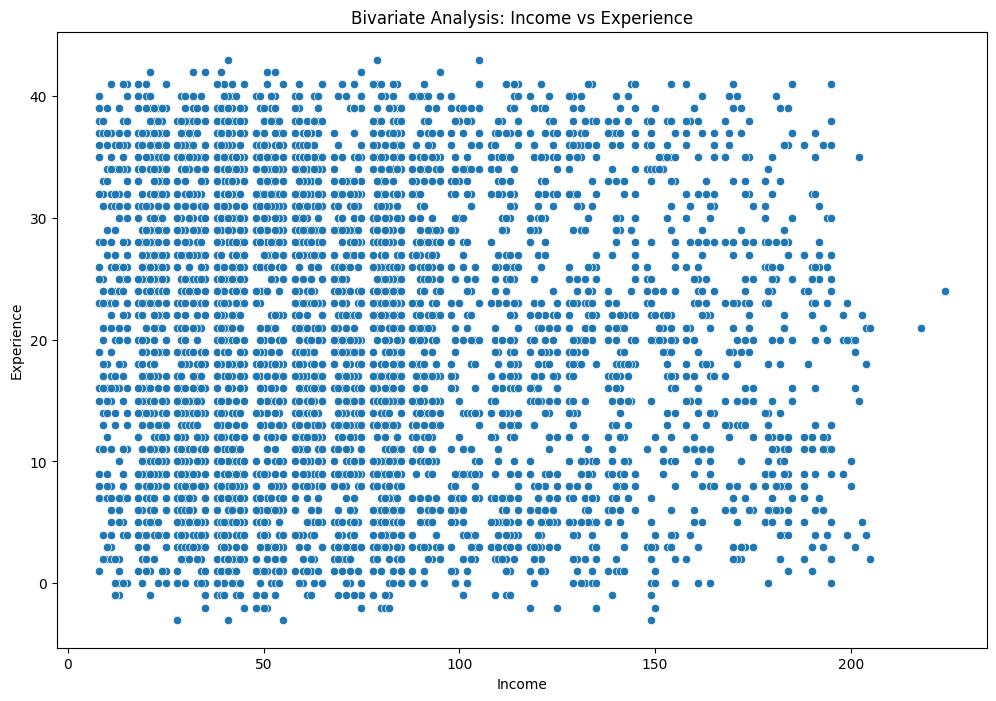

In [80]:
# List of continuous variable pairs for analysis
cont_vs_cont_vars = [
    ('Age', 'Income'),
    ('Age', 'Experience'),
    ('Income', 'Experience')
]

# Call the method for each pair of continuous variables
for var1, var2 in cont_vs_cont_vars:
    bivariate_cont_cont(df, var1, var2)

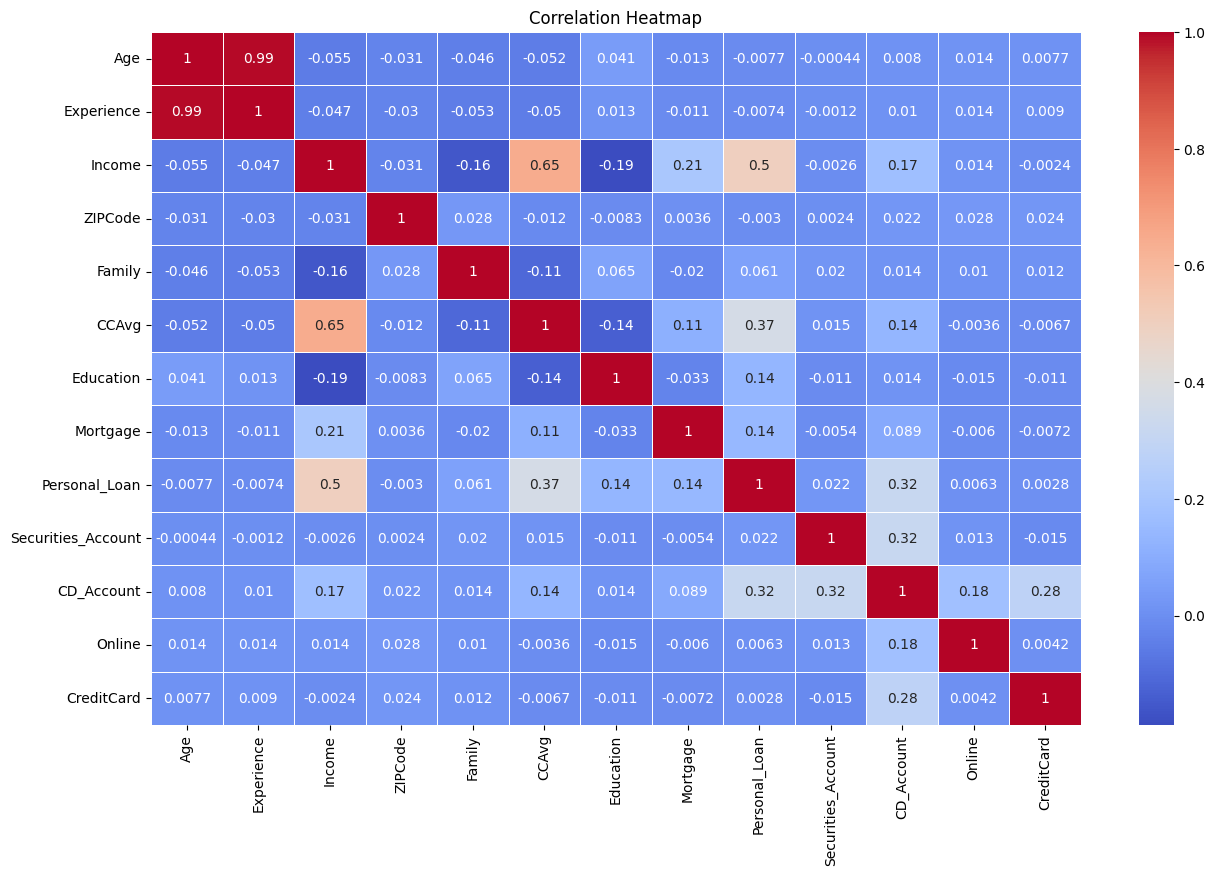

In [81]:
correlation_heatmap(df2)

Correlation Data Observations:
- Experience and Age have a very high positive correlation (0.994), indicating that older individuals tend to have more experience.
- Income and CCAvg show a strong positive correlation (0.646), suggesting that higher income is associated with higher credit card average spending.
- Income and Personal Loan have a notable positive correlation (0.502), implying that customers with higher incomes are more likely to accept personal loans.
- CCAvg and Personal Loan are positively correlated (0.367), indicating that higher credit card spending correlates with a higher likelihood of accepting a personal loan.
- CD_Account and Securities_Account are strongly positively correlated (0.317), showing that customers with CD accounts are likely to also have securities accounts.
- Mortgage and Personal Loan have a mild positive correlation (0.142), suggesting a slight tendency for customers with higher mortgages to accept personal loans.
- Education shows a weak positive correlation with both Personal Loan (0.137) and CCAvg (0.136), indicating a small association between higher education and the likelihood of taking a loan or spending more on credit cards.

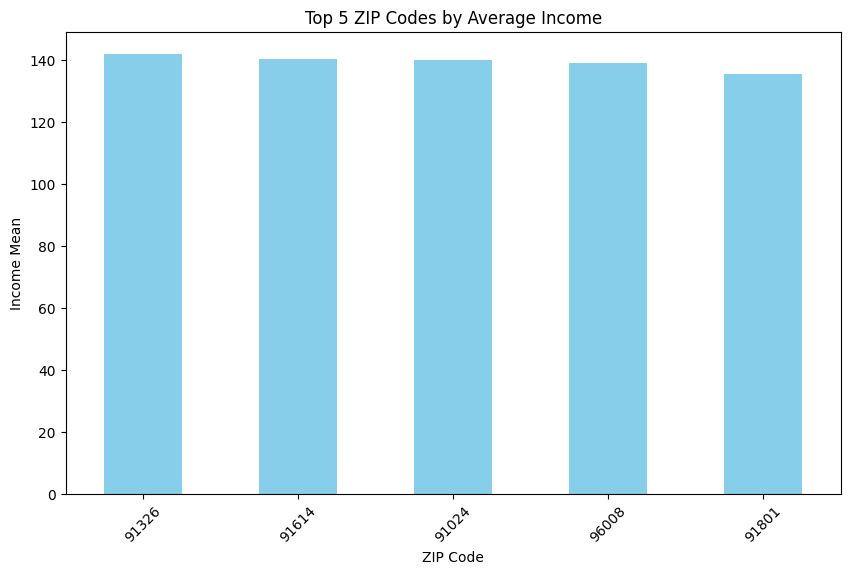

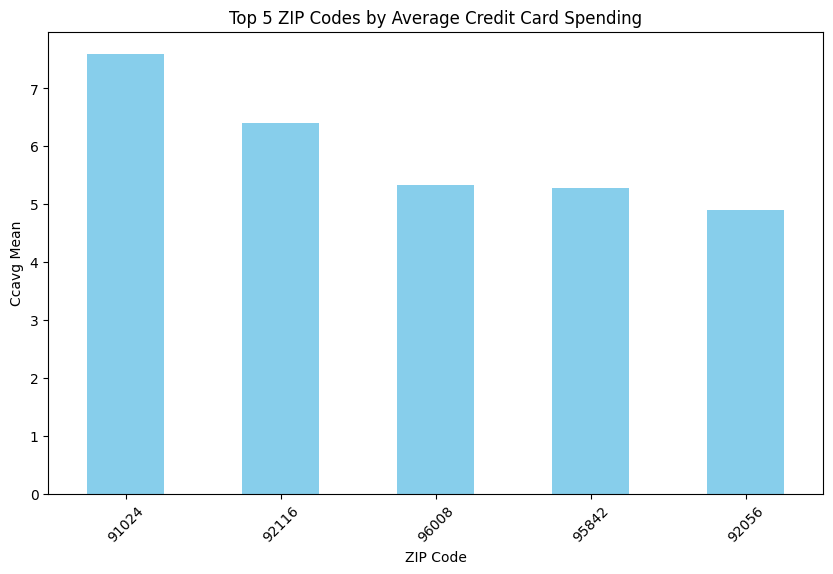

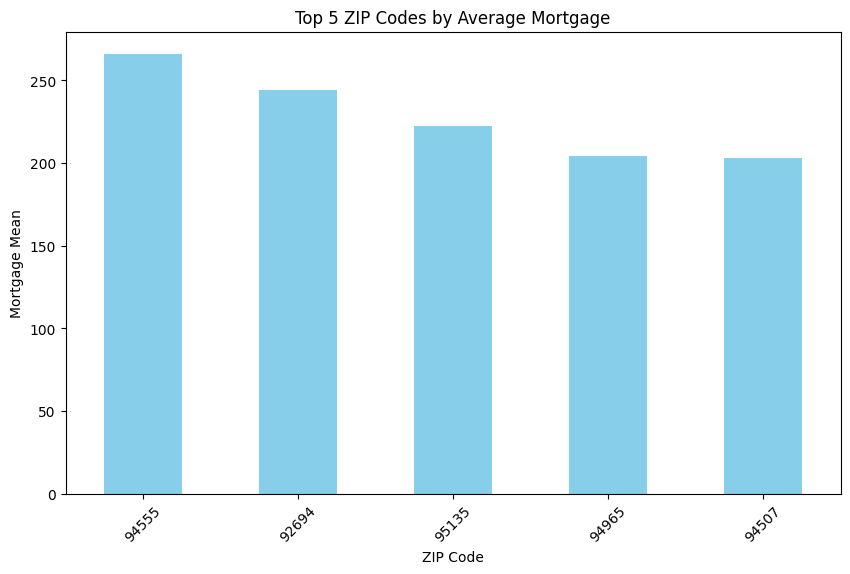

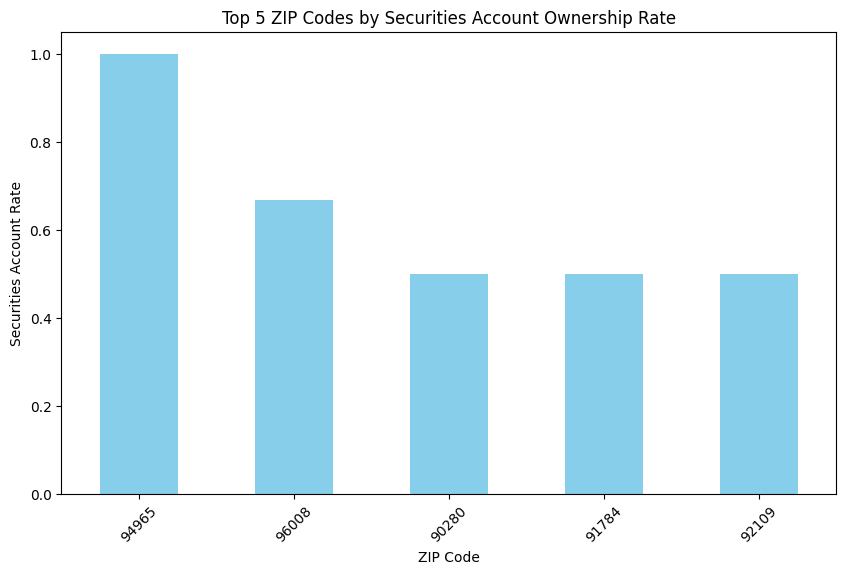

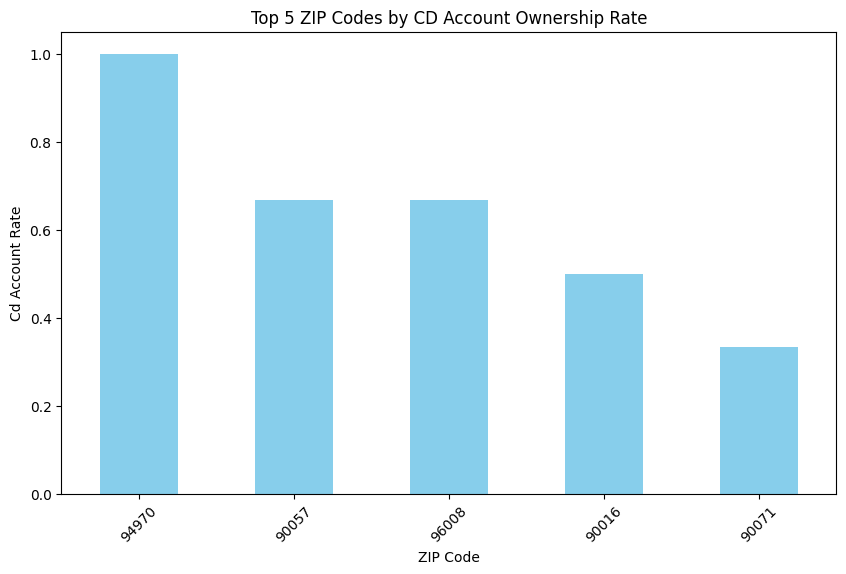

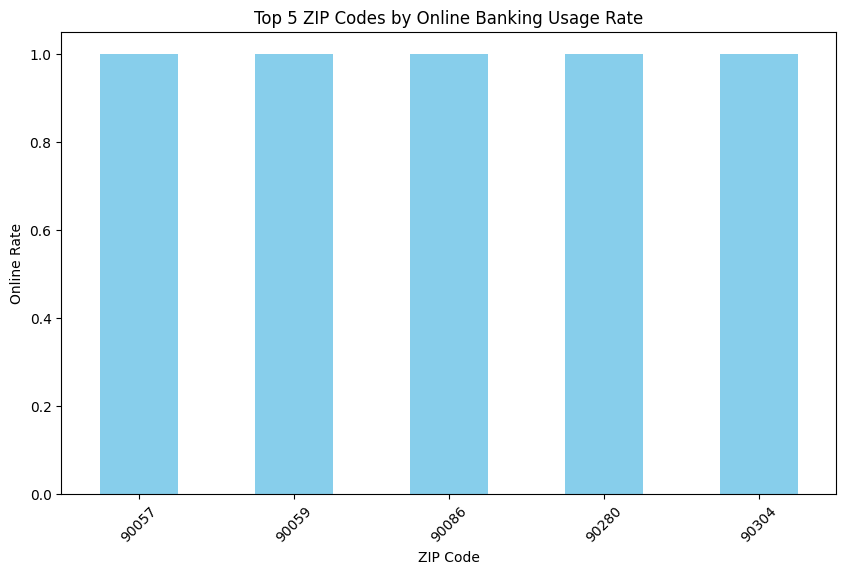

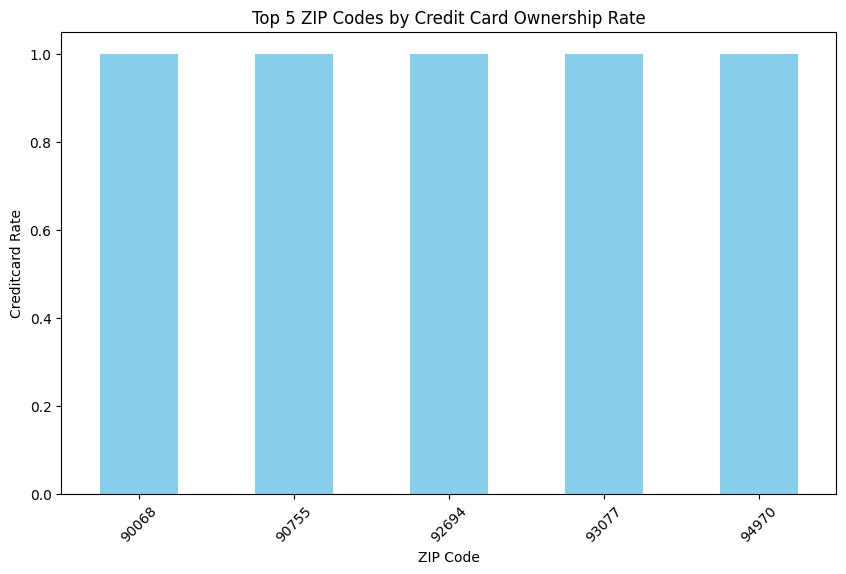

Top 5 ZIP Codes by Income Mean:
         Income_mean
ZIPCode             
91326      142.00000
91614      140.25000
91024      140.00000
96008      139.00000
91801      135.33333


Top 5 ZIP Codes by Ccavg Mean:
         CCAvg_mean
ZIPCode            
91024       7.60000
92116       6.40000
96008       5.33333
95842       5.27500
92056       4.90000


Top 5 ZIP Codes by Mortgage Mean:
         Mortgage_mean
ZIPCode               
94555        266.20000
92694        244.00000
95135        222.66667
94965        204.00000
94507        203.00000


Top 5 ZIP Codes by Securities Account Rate:
         Securities_Account_Rate
ZIPCode                         
94965                    1.00000
96008                    0.66667
90280                    0.50000
91784                    0.50000
92109                    0.50000


Top 5 ZIP Codes by Cd Account Rate:
         CD_Account_Rate
ZIPCode                 
94970            1.00000
90057            0.66667
96008            0.66667
90016      

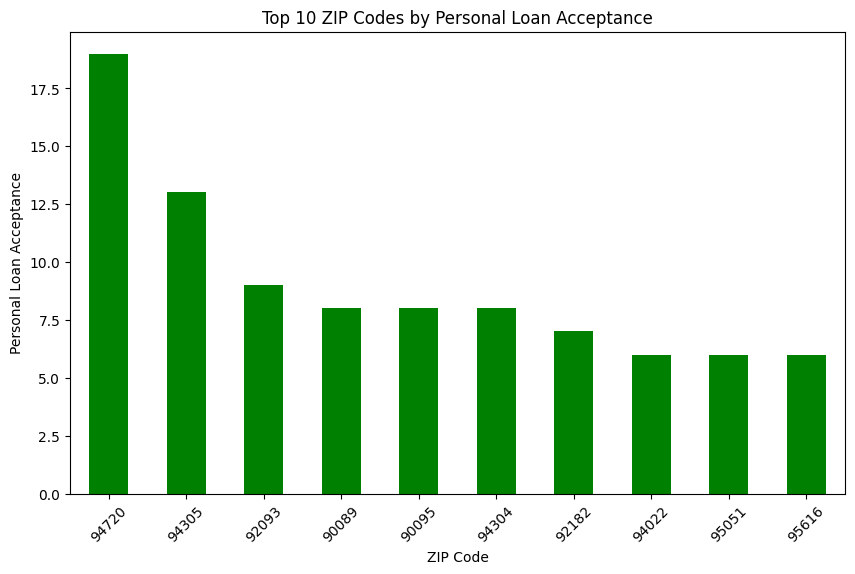

Number of ZIP codes with zero personal loans: 229


In [82]:
zipcode_analysis(df)
top_10_zipcodes_personal_loans(df)

ZIPCode data Observations:
- ZIP Code 94720 (likely University of California, Berkeley) leads with 19 personal loans.
- ZIP Code 94305 (likely Stanford University) has 13 personal loans.
- ZIP Code 92093 (likely University of California, San Diego) also appears in the top 10.
-A notable number of ZIP codes, 229, report zero personal loans.

# Specific Answers to the Questions

Q1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
- Average Mortgage Amount: The average mortgage amount is \$56,499.
- Range: Mortgage amounts vary widely from \$0 to \$635,000, indicating significant variation in mortgage levels among customers.
- Distribution: The distribution is right-skewed, meaning that most customers have lower mortgage amounts, while a smaller number of customers have very high mortgage values.
- Outliers: There are 291 customers with exceptionally high mortgage amounts, ranging from \$253,000 to \$635,000, which are considered outliers in the dataset.

Q2. How many customers have credit cards?
- Number of Customers with Credit Cards: 1,470

Q3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
- Strong Positive Correlation: Income has a strong positive correlation with personal loan acceptance, indicating that higher income is associated with a higher likelihood of accepting a personal loan.

Q4. How does a customer's interest in purchasing a loan vary with their age?
- Average Age of Customers Who Accepted a Loan: 45.7 years
- Average Age of Customers Who Did Not Accept a Loan: 45.3 years
Age vs. Loan Acceptance:
- Overall: There is a minimal difference in average age between those who accepted the loan and those who did not.
- Distribution: Customers who accepted the loan are spread across various age groups, with no significant age bias observed.


Q5. How does a customer's interest in purchasing a loan vary with their education?
- Higher Education Levels: Customers with advanced or professional education levels (Education Level 3) have a higher proportion of loan acceptance compared to those with undergraduate or graduate education levels.
- Trend: The likelihood of accepting a personal loan increases with higher education levels.

## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

**Missing Value Treatment**

Upon review of the dataset, it was observed that there are negative values in the "Experience" column, with a minimum value of -3 years. Given the lack of access to the data source for further investigation and verification, we must address these anomalies directly.


 - Identification of Anomalies:

In [83]:
print(f"There are {len(df[df['Experience'] < 0])} rows with negative values in the 'Experience' column.")

There are 52 rows with negative values in the 'Experience' column.


- Decision on Treatment

Due to the absence of a mechanism for further investigation and the small proportion of affected records (52 out of 5000), the decision has been made to remove these records. This approach is chosen to prevent potential distortions in the analysis that could arise from including implausible values.

In [84]:
# Remove rows with negative experience values
df_cleaned = df2[df2['Experience'] >= 0]
df_original_cleaned=df_cleaned.copy()
df_original_cleaned2=df_original_cleaned.copy()

**Specific Answers to points raised in this section**

Feature Engineering:

We applied feature engineering techniques; however, the results indicate that the model's performance with these engineered features was suboptimal. For a detailed evaluation, please refer to the Approach 3 section in the Appendices section.

Outlier Detection and Treatment:

We implemented outlier detection and treatment strategies and subsequently built a model. The findings suggest that this model performed worse compared to one trained on untreated data. Please review the Approach 2 in the Appendices section.

Any Other Preprocessing Steps:

We further enhanced the model by exploring various algorithms and tuning methods to improve performance. For more details, please refer to Models sectioin.

# Preparing Data for Modeling

In [85]:
# Define features and target variable
X = df_cleaned.drop(["Personal_Loan"], axis=1)
Y = df_cleaned["Personal_Loan"]

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

# Print shapes to verify
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3463, 12) (1485, 12) (3463,) (1485,)


In [86]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (3463, 12)
Shape of test set :  (1485, 12)
Percentage of classes in training set:
Personal_Loan
0   0.90326
1   0.09674
Name: proportion, dtype: float64
Percentage of classes in test set:
Personal_Loan
0   0.90236
1   0.09764
Name: proportion, dtype: float64


Training and test data split basic stat Observations:

- The Personal_Loan variable has a significant class imbalance, with around 90% of customers not accepting the loan.
- The class proportions are consistent between the training and test sets, preserving the original distribution of the target variable.

## Model Building

Decision Tree

A Decision Tree is a good choice for this project because it provides clear, interpretable results, showing how different customer features impact the likelihood of purchasing a personal loan. It handles both categorical and continuous variables well and offers insights into feature importance, which is useful for targeting customer segments effectively.

In [87]:
# Initialize the Decision Tree Classifier model with a fixed random state for reproducibility
decision_tree_baseline_model = DecisionTreeClassifier(random_state=1)

# Fit the model to the training data
# X_train: Features of the training set
# y_train: Target variable of the training set
decision_tree_baseline_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

### Model Evaluation Criterion

**Model Evaluation Criterion for Personal Loan Campaign**

In predicting whether a customer will buy a personal loan, model predictions can fall into two categories:

- False Negatives (FN): Predicting a customer will not buy a loan when they actually will. This could lead to missed sales opportunities and reduced revenue.

- False Positives (FP): Predicting a customer will buy a loan when they actually will not. This might lead to wasted marketing efforts and costs associated with targeting customers who are unlikely to convert.

**Which Case is More Important?**

- False Negatives (FN): Missing a potential customer who is likely to buy a loan results in lost revenue and missed business opportunities. It’s crucial to minimize False Negatives to maximize potential sales and improve campaign effectiveness.

- False Positives (FP): Predicting a customer will buy a loan when they won’t can lead to inefficient use of resources and budget, but the impact is generally less severe compared to the loss of potential sales.

**How to Optimize the Model?**

To reduce the impact of missed sales opportunities (False Negatives), it is important to focus on improving the model’s **recall**. A higher recall score indicates better performance in identifying potential customers who are likely to buy a loan, thus enhancing the effectiveness of the campaign and minimizing revenue loss.

### Model Building

In [88]:
# Defining a function to compute different metrics for evaluating a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute various performance metrics for a classification model.

    Parameters:
    model: classifier
        A trained scikit-learn classifier instance.
    predictors: DataFrame or array-like
        The independent variables used for making predictions.
    target: Series or array-like
        The actual target variable values.

    Returns:
    DataFrame
        A DataFrame containing the Accuracy, Recall, Precision, and F1-score of the model.
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    # Calculating performance metrics
    acc = accuracy_score(target, pred)  # Accuracy
    recall = recall_score(target, pred)  # Recall
    precision = precision_score(target, pred)  # Precision
    f1 = f1_score(target, pred)  # F1-score

    # Creating a DataFrame to display metrics
    df_perf = pd.DataFrame(
        {"Accuracy": [acc], "Recall": [recall], "Precision": [precision], "F1": [f1]},
    )

    return df_perf


In [89]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


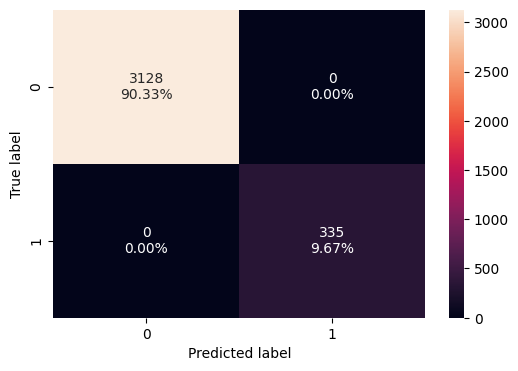

In [90]:
confusion_matrix_sklearn(decision_tree_baseline_model, X_train, y_train)

In [91]:
# Evaluate the performance of the Decision Tree model on the training set
# using the defined function to compute classification metrics
decision_tree_perf_train_without = model_performance_classification_sklearn(
    decision_tree_baseline_model,  # The trained Decision Tree model
    X_train,  # The training set features
    y_train   # The true labels for the training set
)

# Display the performance metrics for the Decision Tree model on the training set
decision_tree_perf_train_without

Accuracy  Recall  Precision      F1
0   1.00000 1.00000    1.00000 1.00000

In [92]:
#checking model performance on the test data
decision_tree_perf_test_without = model_performance_classification_sklearn(
    decision_tree_baseline_model, X_test, y_test
)
decision_tree_perf_test_without

Accuracy  Recall  Precision      F1
0   0.98114 0.88276    0.92086 0.90141

Model Performance (baseline_decision_tree_model)

- High Accuracy: The model’s accuracy is 98.11%, correctly classifying most customers regarding loan acceptance.

- Solid Recall: With a recall of 88.28%, the model identifies most potential loan acceptors, though some are missed.

- Strong Precision: The model’s precision is 92.09%, meaning its predictions of loan acceptance are mostly accurate.

- Balanced F1-Score: The F1-Score of 90.14% shows a good balance between precision and recall, effectively predicting loan acceptances.

### Model Performance Improvement

In [93]:
# Check class distribution in the training data
print(y_train.value_counts())

Personal_Loan
0    3128
1     335
Name: count, dtype: int64


- Class Imbalance: The dataset has a significant imbalance, with Class 0 (not purchased) being the majority and Class 1 (purchased) making up only about 9.7% of the instances.
- Model Bias: This imbalance may cause the Decision Tree model to be biased towards Class 0, potentially reducing performance for Class 1.
- Performance Metrics: Accuracy might be high, but recall for the minority class could be low, indicating difficulty in identifying Class 1.
- Recommendation: Using class_weight="balanced" adjusts class weights to address the imbalance, improving sensitivity to the minority class and enhancing performance in predicting loan purchases.

### Decision Tree with class_weights

In [94]:
# Initialize the Decision Tree classifier with balanced class weights to handle class imbalance
decision_tree_balanced_model  = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# Fit the model on the training data
decision_tree_balanced_model .fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

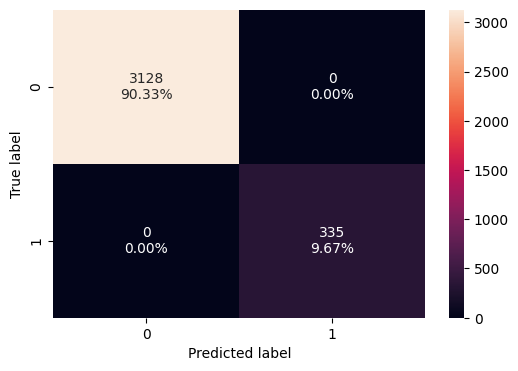

In [95]:
confusion_matrix_sklearn(decision_tree_balanced_model, X_train, y_train)

In [96]:
decision_tree_perf_train = model_performance_classification_sklearn(
    decision_tree_balanced_model, X_train, y_train
)
decision_tree_perf_train

Accuracy  Recall  Precision      F1
0   1.00000 1.00000    1.00000 1.00000

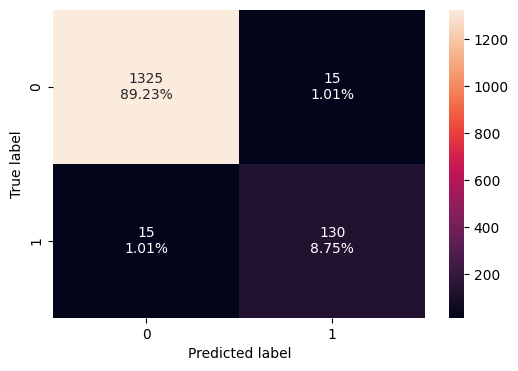

In [97]:
confusion_matrix_sklearn(decision_tree_balanced_model, X_test, y_test)

In [98]:
decision_tree_perf_test = model_performance_classification_sklearn(
    decision_tree_balanced_model , X_test, y_test
)
decision_tree_perf_test

Accuracy  Recall  Precision      F1
0   0.97980 0.89655    0.89655 0.89655

- The model with class_weight="balanced" shows an improvement in recall for the minority class at the cost of precision, leading to a more balanced handling of class imbalance.

### Decision Tree (Pre-pruning)

Pre-pruning helps prevent overfitting and improves generalization by controlling tree complexity, which can enhance performance on test data and handle class imbalance more effectively.

In [99]:
# Initialize a Decision Tree Classifier
decision_tree_pre_pruning_model = DecisionTreeClassifier(random_state=1)

# Define the grid of parameters to choose from
parameters = {
    "class_weight": [None, "balanced"],
    "max_depth": np.arange(2, 7, 2),  # Maximum depth of the tree: [2, 4, 6]
    "max_leaf_nodes": [50, 75, 150, 250],  # Maximum leaf nodes in the tree
    "min_samples_split": [10, 30, 50, 70],  # Minimum samples required to split an internal node
}

# Define the scoring metric to compare parameter combinations
acc_scorer = make_scorer(recall_score)

# Run the grid search to find the best parameters
grid_obj = GridSearchCV(decision_tree_pre_pruning_model, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the estimator to the best combination of parameters
decision_tree_pre_pruning_model = grid_obj.best_estimator_

# Fit the best algorithm to the data
decision_tree_pre_pruning_model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=50,
                       min_samples_split=10, random_state=1)

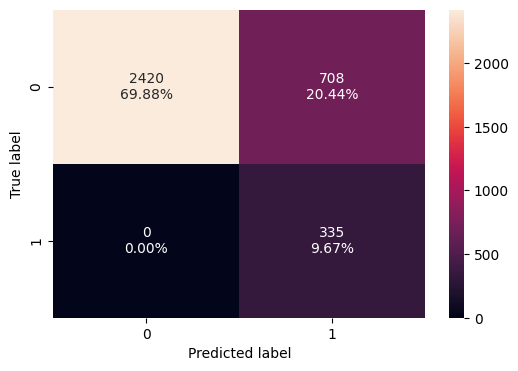

In [100]:
confusion_matrix_sklearn(decision_tree_pre_pruning_model, X_train, y_train)

In [101]:
decision_tree_tune_perf_train = model_performance_classification_sklearn(
    decision_tree_pre_pruning_model, X_train, y_train
)
decision_tree_tune_perf_train

Accuracy  Recall  Precision      F1
0   0.79555 1.00000    0.32119 0.48621

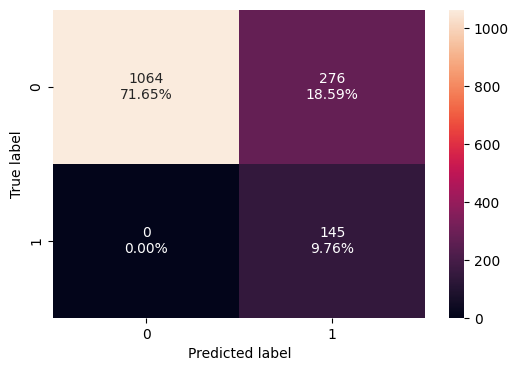

In [102]:
confusion_matrix_sklearn(decision_tree_pre_pruning_model, X_test, y_test)

In [103]:
decision_tree_tune_perf_test = model_performance_classification_sklearn(
    decision_tree_pre_pruning_model, X_test, y_test
)
decision_tree_tune_perf_test

Accuracy  Recall  Precision      F1
0   0.81414 1.00000    0.34442 0.51237

- Perfect Recall, Low Precision: The model achieves 100% recall but with low precision (34.44%), indicating all positives are correctly identified, but many predicted positives are false.

- Accuracy and F1-Score Trade-Off: The accuracy is 81.41% and F1-Score is 51.24%, showing a trade-off between high recall and lower precision.

In [104]:
feature_names = list(X_train.columns)
importances = decision_tree_pre_pruning_model.feature_importances_
indices = np.argsort(importances)

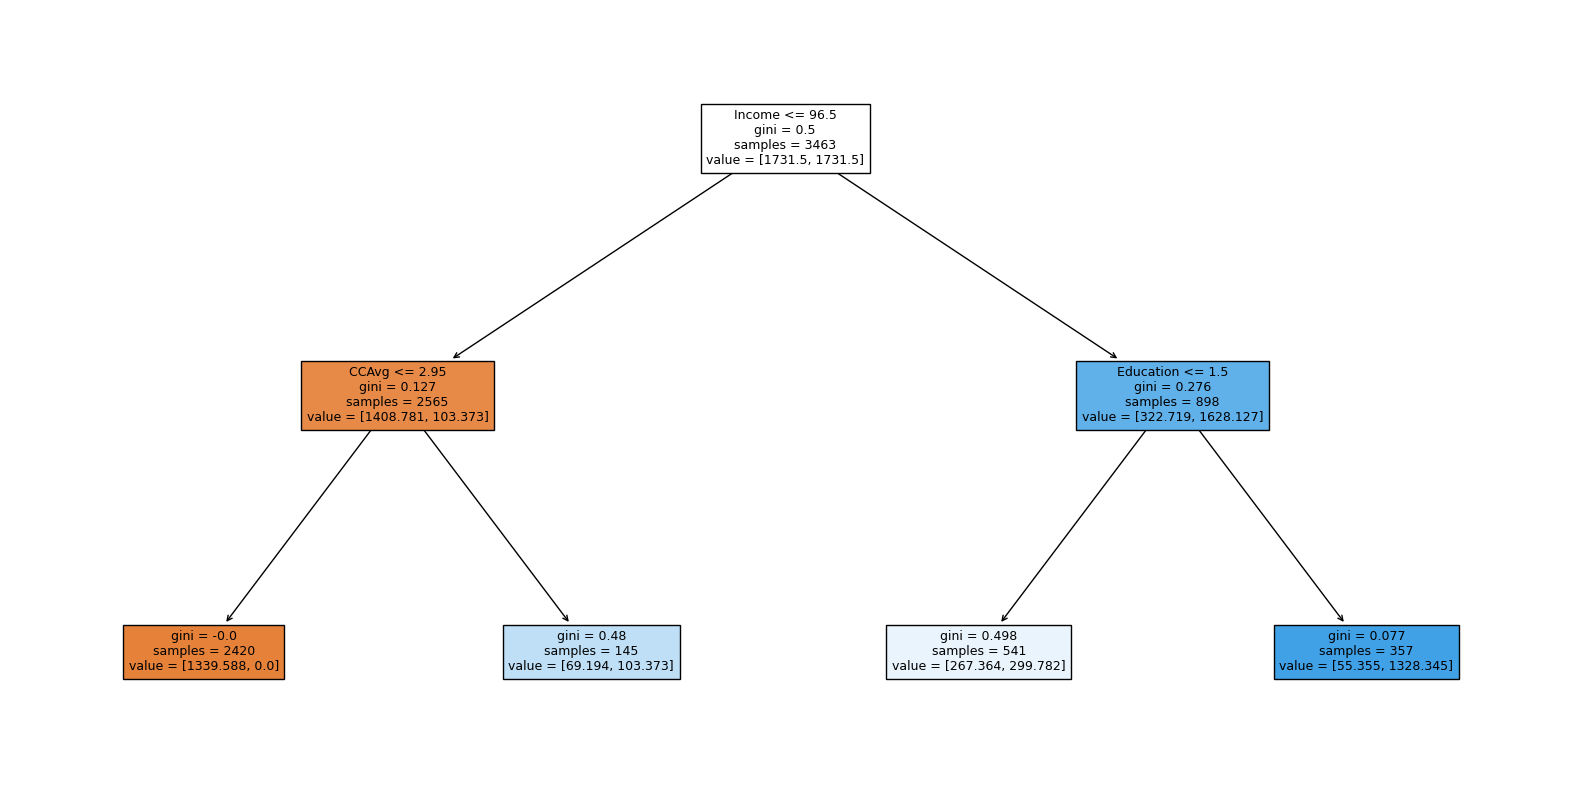

In [105]:
from sklearn.tree import plot_tree  # Import the plot_tree function from sklearn.tree

# Set the figure size for the plot
plt.figure(figsize=(20, 10))

# Plot the decision tree
out = plot_tree(
    decision_tree_pre_pruning_model,  # Model to plot
    feature_names=feature_names,  # Feature names used in the model
    filled=True,  # Fill the nodes with colors
    fontsize=9,  # Set the font size of the text in the nodes
    node_ids=False,  # Do not show node IDs
    class_names=None,  # Do not show class names
)

# Add arrows to the decision tree splits if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)

# Display the plot
plt.show()


In [106]:
from sklearn.tree import export_text  # Import the export_text function from sklearn.tree
# Text report showing the rules of a decision tree -
print(export_text(decision_tree_pre_pruning_model, feature_names=feature_names, show_weights=True))

|--- Income <= 96.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [1339.59, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- weights: [69.19, 103.37] class: 1
|--- Income >  96.50
|   |--- Education <= 1.50
|   |   |--- weights: [267.36, 299.78] class: 1
|   |--- Education >  1.50
|   |   |--- weights: [55.35, 1328.34] class: 1



Observations:

The decision tree uses Income, CCAvg, and Education to make predictions. Higher Income and Education, along with specific CCAvg values, tend to favor predictions of customers who will purchase a loan. The class weights provide insights into the distribution of samples at each node, showing the model’s tendency to classify based on the predominant outcome (purchasing or not purchasing a loan) in each region of the feature space.

In [107]:
importances = decision_tree_pre_pruning_model.feature_importances_

In [108]:

def plot_and_summarize_feature_importances(estimator, feature_names):
    """
    Plots feature importances as a horizontal bar chart with percentages and prints a data summary.

    estimator: The trained decision tree model.
    feature_names: List of feature names.
    """
    # Get feature importances and sort them
    importances = estimator.feature_importances_
    indices = np.argsort(importances)

    # Calculate percentages
    total_importance = np.sum(importances)
    percentages = (importances[indices] / total_importance) * 100

    # Create a DataFrame for summary
    importance_summary = pd.DataFrame({
        'Feature': np.array(feature_names)[indices],
        'Importance': importances[indices],
        'Percentage': percentages
    })

    # Print summary
    print("Feature Importances Summary:")
    print(importance_summary)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances (Percentages)")
    bars = plt.barh(range(len(indices)), percentages, color="violet", align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Percentage Importance")

    # Add percentage labels on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
                 f'{width:.2f}%',
                 va='center')

    plt.show()


Feature Importances Summary:
               Feature  Importance  Percentage
0                  Age     0.00000     0.00000
1           Experience     0.00000     0.00000
2              ZIPCode     0.00000     0.00000
3               Family     0.00000     0.00000
4             Mortgage     0.00000     0.00000
5   Securities_Account     0.00000     0.00000
6           CD_Account     0.00000     0.00000
7               Online     0.00000     0.00000
8           CreditCard     0.00000     0.00000
9                CCAvg     0.08710     8.70974
10           Education     0.11887    11.88710
11              Income     0.79403    79.40316


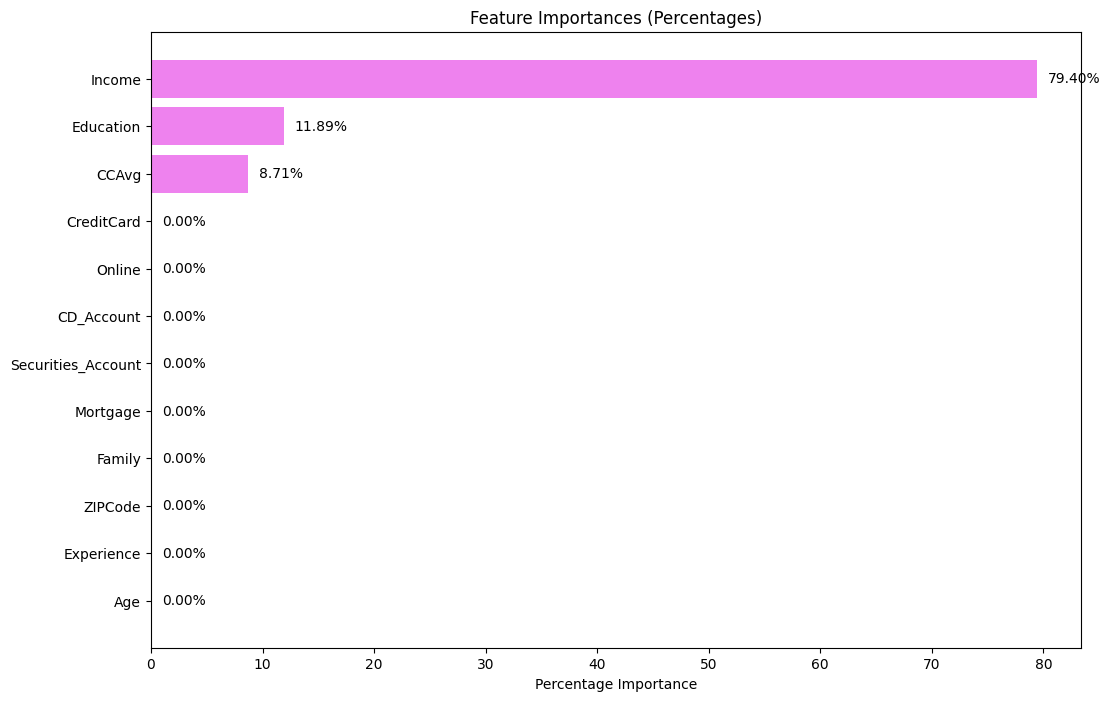

In [109]:
# Plot and summarize the feature importances of the given model
plot_and_summarize_feature_importances(decision_tree_pre_pruning_model, feature_names)

Observations:

- Income is the most important feature, contributing 79.40% to the model's decisions.
- Education has a significant impact, accounting for 11.89% of the importance.
- CCAvg contributes 8.71% to the model's decisions.
- All other features have no impact on the model's performance.

### Decision Tree (Post pruning)

The DecisionTreeClassifier can use post-pruning techniques to improve model generalization and avoid overfitting. By adjusting the ccp_alpha parameter, which controls cost complexity pruning, the model can prune less important nodes and reduce tree complexity. Higher ccp_alpha values lead to more pruning, increasing the total impurity of leaves but potentially improving generalization. Using DecisionTreeClassifier.cost_complexity_pruning_path, one can determine effective ccp_alpha values to optimize tree performance.

In [110]:
# Compute the cost complexity pruning path to determine the best alpha for pruning the decision tree

clf = DecisionTreeClassifier(random_state=1, class_weight="balanced") # {0: 0.15, 1: 0.85}
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = abs(path.ccp_alphas), path.impurities


In [111]:
pd.DataFrame(path)

ccp_alphas  impurities
0      0.00000    -0.00000
1      0.00000    -0.00000
2      0.00000    -0.00000
3      0.00000    -0.00000
4      0.00000    -0.00000
5      0.00000    -0.00000
6      0.00000    -0.00000
7      0.00000    -0.00000
8      0.00000    -0.00000
9      0.00000    -0.00000
10     0.00000    -0.00000
11     0.00000    -0.00000
12     0.00000    -0.00000
13     0.00000    -0.00000
14     0.00000    -0.00000
15     0.00015     0.00031
16     0.00015     0.00062
17     0.00015     0.00093
18     0.00016     0.00124
19     0.00016     0.00155
20     0.00016     0.00187
21     0.00016     0.00250
22     0.00023     0.00343
23     0.00028     0.00483
24     0.00030     0.00513
25     0.00030     0.00604
26     0.00031     0.00635
27     0.00031     0.00666
28     0.00031     0.00697
29     0.00040     0.00855
30     0.00043     0.00984
31     0.00056     0.01039
32     0.00079     0.01197
33     0.00089     0.01286
34     0.00094     0.01474
35     0.00136     0.02020
36     0.00147     0.02166
37     0.00154     0.02320
38     0.00154     0.02474
39     0.00169     0.02643
40     0.00224     0.03091
41     0.00224     0.03315
42     0.00270     0.03585
43     0.00276     0.03861
44     0.00379     0.04239
45     0.00413     0.04652
46     0.00421     0.05073
47     0.00711     0.06496
48     0.01032     0.07528
49     0.03168     0.10696
50     0.05211     0.21117
51     0.28883     0.50000

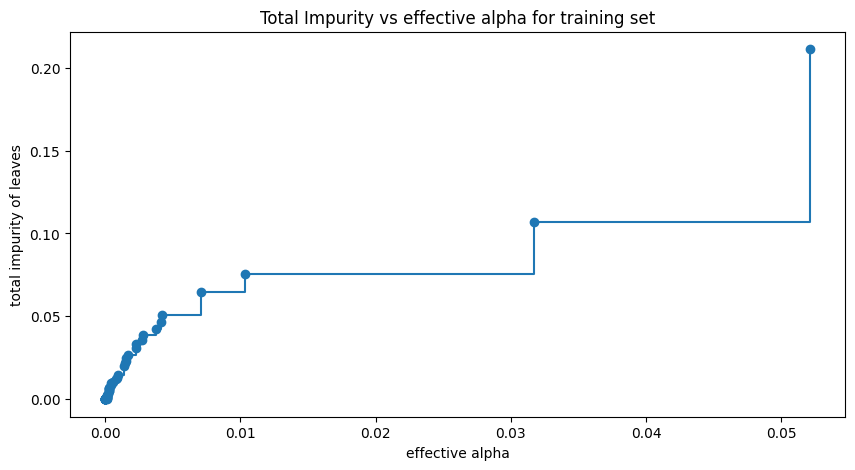

In [112]:
# Plot the cost complexity pruning path to visualize the relationship between effective alpha and total impurity
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Summary of Cost Complexity Pruning Path:

- Effective Alphas: The ccp_alpha values start from 0.00000 and increase incrementally, reflecting the increasing amount of pruning.
- Impurities: The impurities rise with higher ccp_alpha, indicating that more pruning leads to higher total impurity of leaves.
- Initial Pruning: For small ccp_alpha values, the impurity is minimal, suggesting that early pruning does not significantly affect the model.
- Increased Pruning: As ccp_alpha increases, the impurity rises, demonstrating that more aggressive pruning results in a simpler tree but with increased impurity.

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [113]:
# Train a series of Decision Trees with varying cost complexity pruning alpha values and store them in a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=1, ccp_alpha=ccp_alpha, class_weight="balanced"
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.28883082325199494


- High Pruning Level: With a ccp_alpha value of 0.28883, the decision tree has been pruned significantly, resulting in only one node in the final tree.

- Over-Pruning: Such a high ccp_alpha value suggests excessive pruning, which may lead to an overly simplistic model that might not capture the complexity of the data effectively.

- Model Evaluation Needed: This high level of pruning could lead to underfitting. It's crucial to evaluate this pruned model's performance to ensure it still meets the desired criteria for accuracy and generalization.

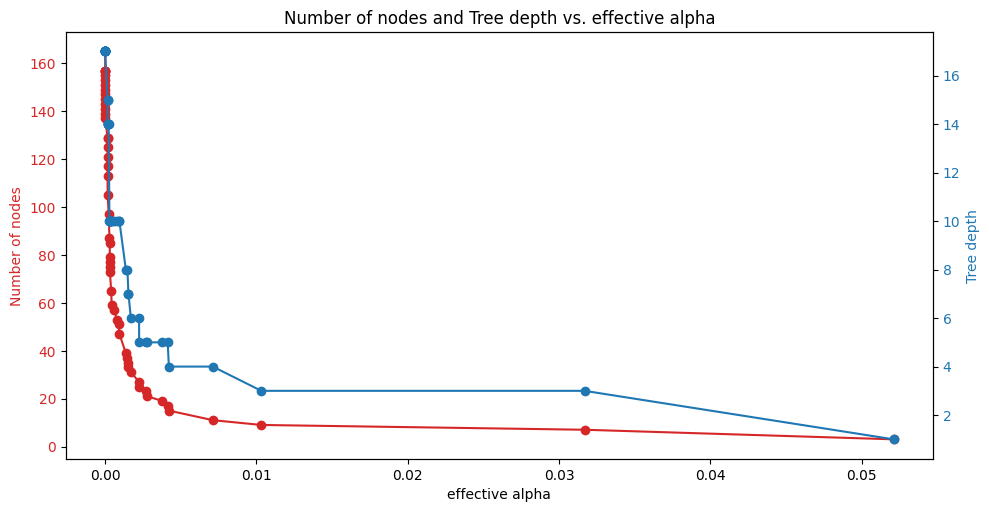

In [114]:
# Remove the last (trivial) tree from the list
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Calculating Number of Nodes and Depths:
nodes = [clf.tree_.node_count for clf in clfs]
depths = [clf.tree_.max_depth for clf in clfs]

#Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('effective alpha')
ax1.set_ylabel('Number of nodes', color=color)
ax1.plot(ccp_alphas, nodes, marker='o', color=color, label='Number of nodes')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Tree depth', color=color)
ax2.plot(ccp_alphas, depths, marker='o', color=color, label='Tree depth')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Number of nodes and Tree depth vs. effective alpha')
plt.show()


In [115]:
# Print number of nodes and tree depth for each ccp_alpha
print("Effective Alpha | Number of Nodes | Tree Depth")
print("---------------------------------------------")

for alpha, clf in zip(ccp_alphas, clfs):
    num_nodes = clf.tree_.node_count
    depth = clf.tree_.max_depth
    print(f"{alpha:.5f}          | {num_nodes:>15} | {depth:>9}")


Effective Alpha | Number of Nodes | Tree Depth
---------------------------------------------
0.00000          |             165 |        17
0.00000          |             157 |        17
0.00000          |             157 |        17
0.00000          |             157 |        17
0.00000          |             157 |        17
0.00000          |             155 |        17
0.00000          |             153 |        17
0.00000          |             151 |        17
0.00000          |             149 |        17
0.00000          |             147 |        17
0.00000          |             145 |        17
0.00000          |             143 |        17
0.00000          |             141 |        17
0.00000          |             139 |        17
0.00000          |             137 |        17
0.00015          |             129 |        15
0.00015          |             129 |        15
0.00015          |             125 |        14
0.00016          |             121 |        14
0.00016       

Insights:

- As ccp_alpha increases, the number of nodes and tree depth decrease, indicating that more pruning results in simpler trees.
- Trees with higher ccp_alpha values are less complex and have fewer nodes and shallower depths.
- Effective alphas of 0.05211 lead to a very minimal tree with only 3 nodes, which might be overly simplistic.

In [116]:
# Initialize a list to store recall scores
recall_train = []

# Iterate over the list of pruned classifiers
for clf in clfs:
    # Predict on the training set
    pred_train = clf.predict(X_train)
    # Calculate the recall score
    values_train = recall_score(y_train, pred_train)
    # Append the recall score to the list
    recall_train.append(values_train)

# Print recall scores for each alpha value
print("Effective Alpha | Recall (Training Set)")
print("---------------------------------------")
for alpha, recall in zip(ccp_alphas, recall_train):
    print(f"{alpha:.5f}          | {recall:.5f}")


Effective Alpha | Recall (Training Set)
---------------------------------------
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00000          | 1.00000
0.00015          | 1.00000
0.00015          | 1.00000
0.00015          | 1.00000
0.00016          | 1.00000
0.00016          | 1.00000
0.00016          | 1.00000
0.00016          | 1.00000
0.00023          | 1.00000
0.00028          | 1.00000
0.00030          | 1.00000
0.00030          | 1.00000
0.00031          | 1.00000
0.00031          | 1.00000
0.00031          | 1.00000
0.00040          | 1.00000
0.00043          | 1.00000
0.00056          | 1.00000
0.00079          | 1.00000
0.00089          | 1.00000
0.

In [117]:
# Calculate recall scores for each decision tree model on the test set
recall_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)  # Predict using the test data
    values_test = recall_score(y_test, pred_test)  # Compute recall score
    recall_test.append(values_test)  # Append recall score to the list


In [118]:
# Calculate training and testing scores for each decision tree model
train_scores = [clf.score(X_train, y_train) for clf in clfs]  # Compute training accuracy for each model
test_scores = [clf.score(X_test, y_test) for clf in clfs]    # Compute testing accuracy for each model

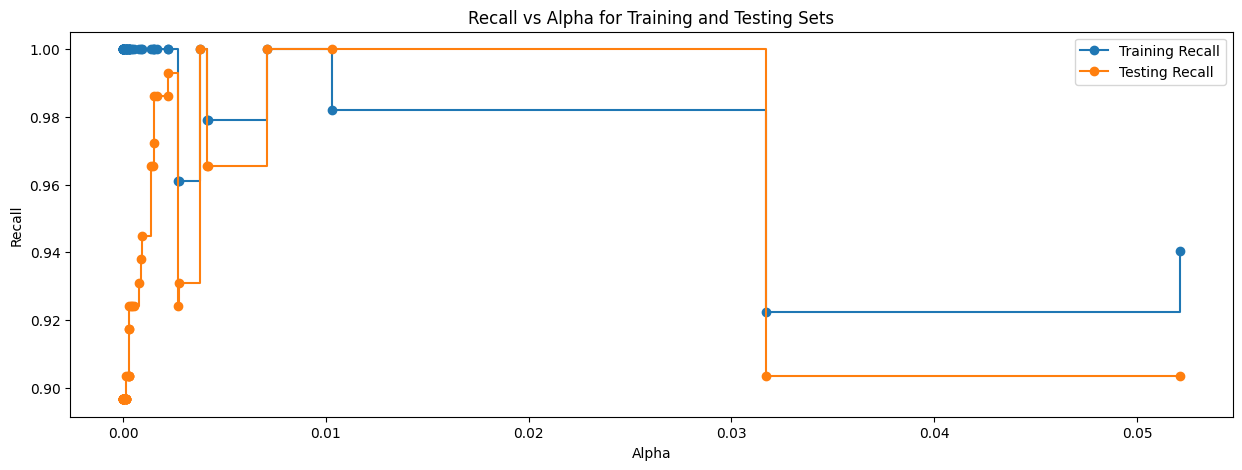

In [119]:
#plotting
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("Alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs Alpha for Training and Testing Sets")
ax.plot(
    ccp_alphas, recall_train, marker="o", label="Training Recall", drawstyle="steps-post",
)
ax.plot(ccp_alphas, recall_test, marker="o", label="Testing Recall", drawstyle="steps-post")
ax.legend()
plt.show()


In [120]:
# Print Recall scores vs. Alpha for training and testing sets
print("Effective Alpha | Training Recall | Testing Recall")
print("---------------------------------------------------")

for alpha, recall_train, recall_test in zip(ccp_alphas, recall_train, recall_test):
    print(f"{alpha:.5f}          | {recall_train:.5f}        | {recall_test:.5f}")


Effective Alpha | Training Recall | Testing Recall
---------------------------------------------------
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00000          | 1.00000        | 0.89655
0.00015          | 1.00000        | 0.89655
0.00015          | 1.00000        | 0.89655
0.00015          | 1.00000        | 0.89655
0.00016          | 1.00000        | 0.89655
0.00016          | 1.00000        | 0.89655
0.00016          

In [121]:
# Find the index of the model with the highest recall score on the test set
index_best_model = np.argmax(recall_test)  # Get index of the best model based on recall

# Select the best model based on the highest recall score
decision_tree_post_pruning_best_recall_model = clfs[index_best_model]  # Best model with highest recall

# Print the best model details
print(decision_tree_post_pruning_best_recall_model)

DecisionTreeClassifier(class_weight='balanced', random_state=1)


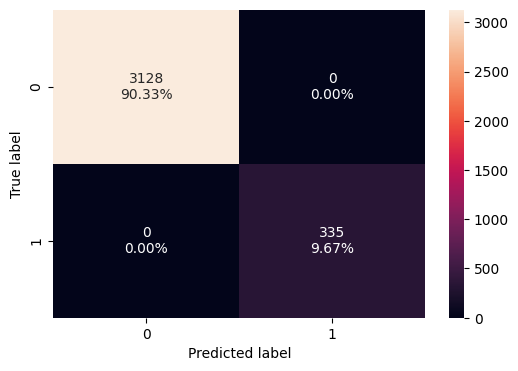

In [122]:
confusion_matrix_sklearn(decision_tree_post_pruning_best_recall_model, X_train, y_train)

In [123]:
# Evaluate the performance of the best post-pruning model on the training set
decision_tree_post_perf_train = model_performance_classification_sklearn(
    decision_tree_post_pruning_best_recall_model, X_train, y_train
)
decision_tree_post_perf_train

Accuracy  Recall  Precision      F1
0   1.00000 1.00000    1.00000 1.00000

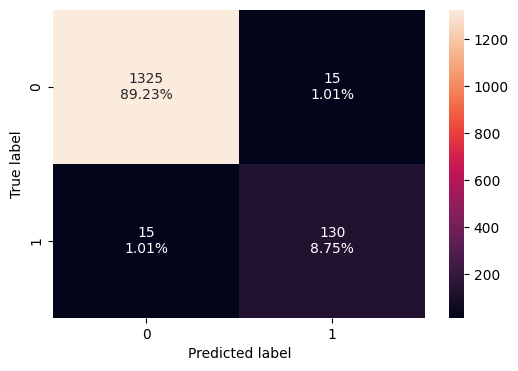

In [124]:
confusion_matrix_sklearn(decision_tree_post_pruning_best_recall_model, X_test, y_test)

In [125]:
decision_tree_post_test = model_performance_classification_sklearn(
    decision_tree_post_pruning_best_recall_model, X_test, y_test
)
decision_tree_post_test

Accuracy  Recall  Precision      F1
0   0.97980 0.89655    0.89655 0.89655

Observation:

In the post-pruned tree, the model demonstrates strong performance with high accuracy and balanced recall, precision, and F1 scores. The recall score on the test set is approximately 0.90, indicating that the model effectively identifies positive instances while generalizing well on unseen data. The overall performance metrics suggest that the model is robust and capable of maintaining balanced predictions across both training and testing datasets.

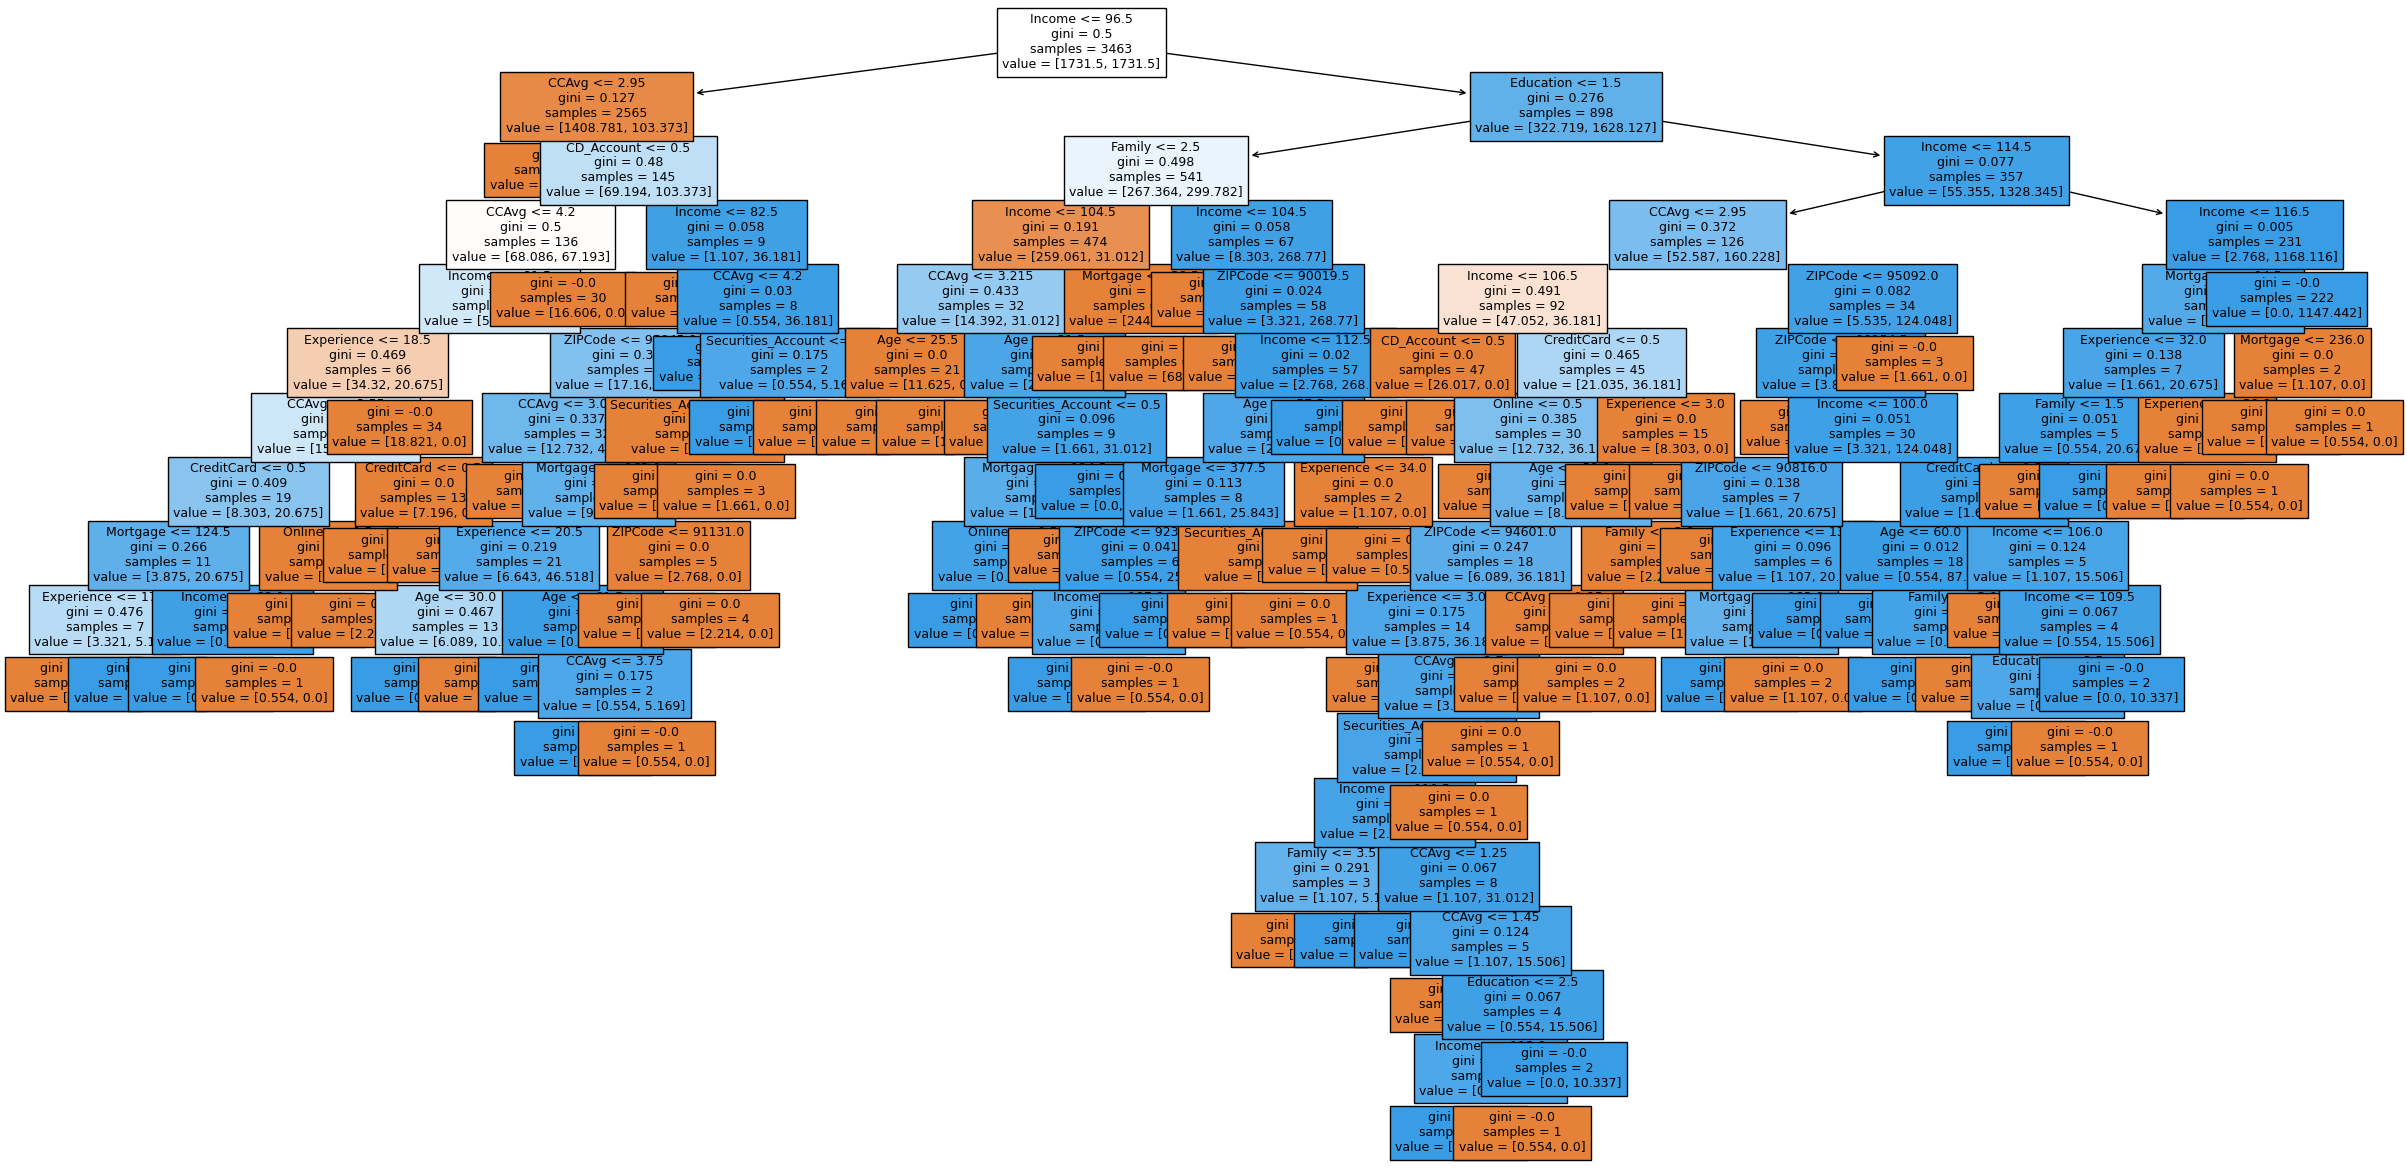

In [126]:
#plot the tree
plt.figure(figsize=(30, 15))

# Plot the decision tree
out = plot_tree(
    decision_tree_post_pruning_best_recall_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None
)

# Customize arrow colors for better visibility
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)

# Show the plot
plt.show()


In [127]:
#Text report showing the rules of a decision tree
print(export_text(decision_tree_post_pruning_best_recall_model, feature_names=feature_names, show_weights=True))

|--- Income <= 96.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [1339.59, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CD_Account <= 0.50
|   |   |   |--- CCAvg <= 4.20
|   |   |   |   |--- Income <= 81.50
|   |   |   |   |   |--- Experience <= 18.50
|   |   |   |   |   |   |--- CCAvg <= 3.55
|   |   |   |   |   |   |   |--- CreditCard <= 0.50
|   |   |   |   |   |   |   |   |--- Mortgage <= 124.50
|   |   |   |   |   |   |   |   |   |--- Experience <= 17.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [3.32, 0.00] class: 0
|   |   |   |   |   |   |   |   |   |--- Experience >  17.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 5.17] class: 1
|   |   |   |   |   |   |   |   |--- Mortgage >  124.50
|   |   |   |   |   |   |   |   |   |--- Income <= 68.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 15.51] class: 1
|   |   |   |   |   |   |   |   |   |--- Income >  68.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [0.55, 0.00] cl

Insights:

- Income is a Major Split Variable: The initial split on Income <= 96.50 highlights its significant role in predicting personal loan purchases.
- Complexity and Detailed Conditions: The tree captures detailed patterns through multiple splits on various features, such as CCAvg and CreditCard usage.

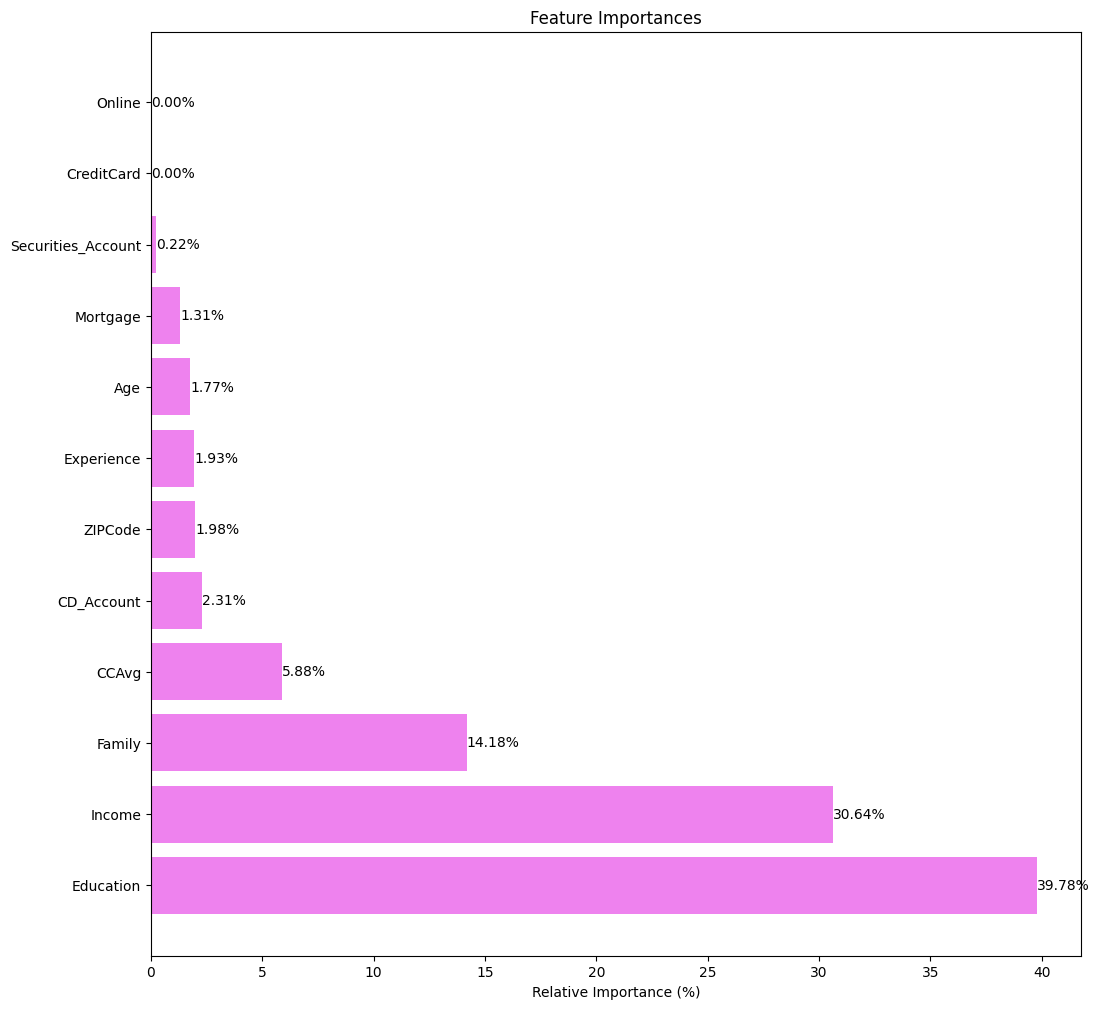

In [128]:
# Train the model
clf = DecisionTreeClassifier()
feature_names = X_train.columns
clf.fit(X_train, y_train)

# Extract feature importances
importances = clf.feature_importances_

# Calculate percentages
total_importance = np.sum(importances)
percentages = (importances / total_importance) * 100

# Sort indices of importances in descending order
indices = np.argsort(importances)[::-1]

# Create the bar plot
plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
bars = plt.barh(range(len(indices)), percentages[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance (%)")

# Add percentages to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center', ha='left', fontsize=10)

plt.show()

In [129]:
# Create a DataFrame for easy viewing
feature_summary = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Percentage of Total Importance (%)': percentages
})

# Sort the DataFrame by importance in descending order
feature_summary_sorted = feature_summary.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the summary
print("Feature Importances Summary:")
print(feature_summary_sorted)


Feature Importances Summary:
               Feature  Importance  Percentage of Total Importance (%)
0            Education     0.39777                            39.77689
1               Income     0.30644                            30.64370
2               Family     0.14180                            14.18005
3                CCAvg     0.05880                             5.88009
4           CD_Account     0.02307                             2.30706
5              ZIPCode     0.01979                             1.97912
6           Experience     0.01930                             1.93000
7                  Age     0.01769                             1.76942
8             Mortgage     0.01313                             1.31335
9   Securities_Account     0.00220                             0.22032
10              Online     0.00000                             0.00000
11          CreditCard     0.00000                             0.00000


Observations:

- Education and Income are the primary drivers in the decision tree model, as evidenced by their high importance scores.
- Features like CCAvg, CD_Account, and ZIPCode have more moderate importance but are still relevant.
- The very low importance of Age, Experience, and others suggests these features may have minimal impact on the decision-making process of the model.

### Supplementary Model Review: Performance Comparison with XGBoost Model

The XGBoost model, which stands for Extreme Gradient Boosting, is a powerful and efficient machine learning algorithm for classification tasks. This script involves tuning the XGBoost model using Optuna to optimize its hyperparameters, aiming to maximize performance, particularly focusing on recall.


[I 2024-07-10 13:44:17,496] A new study created in memory with name: no-name-5bab678f-4dd3-4d94-8134-09a5db90e23f
[I 2024-07-10 13:44:19,883] Trial 0 finished with value: 0.9888888888888889 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.08960785365368121, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.04679835610086079, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.9888888888888889.
[I 2024-07-10 13:44:21,948] Trial 1 finished with value: 0.990909090909091 and parameters: {'n_estimators': 267, 'max_depth': 7, 'learning_rate': 0.08341106432362087, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'gamma': 0.2497327922401265, 'scale_pos_weight': 3}. Best is trial 1 with value: 0.990909090909091.
[I 2024-07-10 13:44:22,884] Trial 2 finished with value: 0.9737373737373738 and parameters: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.024878734419814436, 'subsample': 0.8099025726528951, 'c

Best Hyperparameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.139033703231478, 'subsample': 0.6250531478358148, 'colsample_bytree': 0.649504563998953, 'gamma': 0.20393980521451277, 'scale_pos_weight': 4}
Tuned XGBoost Model Performance on Training Set with Optuna:
                         Model  Accuracy  Recall  Precision  F1-Score
0  XGBoost (Tuned with Optuna)   1.00000 1.00000    1.00000   1.00000
Tuned XGBoost Model Performance on Test Set with Optuna:
                         Model  Accuracy  Recall  Precision  F1-Score
0  XGBoost (Tuned with Optuna)   0.99192 0.93103    0.97590   0.95294
Cross-Validation Accuracy Scores: [0.98484848 0.99090909 0.98686869 0.99191102 0.98685541]
Mean Cross-Validation Accuracy: 0.9882785386728763
Feature Importance:
           Feature  Importance
6       CD_Account     0.05414
2           Income     0.04817
167  ZIPCode_92121     0.04354
156  ZIPCode_92093     0.04287
30   ZIPCode_90049     0.04051
..             ...         ...
18

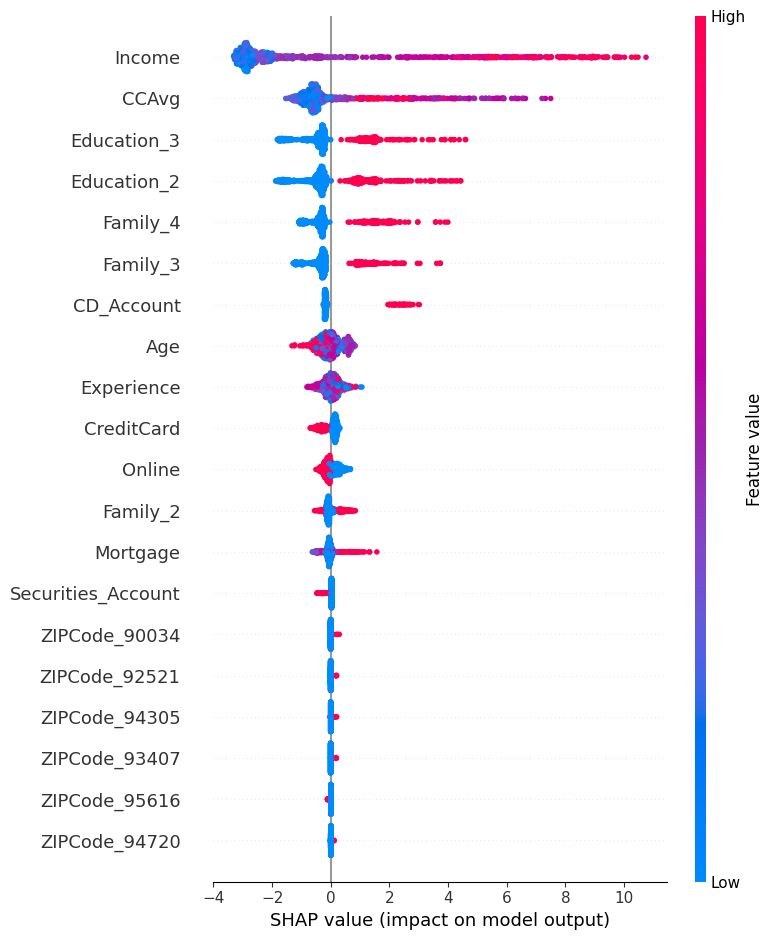

In [130]:
#Approach 1: XGBoost Model with Optuna Tuning
#--------------------------------------------
# This script uses Optuna to tune hyperparameters for an XGBoost model and evaluates its performance.
# The goal is to find the optimal hyperparameters that maximize the model's performance, particularly focusing on recall.
# The script includes the following steps:
#
# 1. Define the objective function for Optuna optimization, where the XGBoost model is trained and evaluated based on accuracy.
# 2. Optimize hyperparameters using Optuna with a specified number of trials.
# 3. Retrieve and print the best hyperparameters from the optimization process.
# 4. Train an XGBoost model using the best hyperparameters.
# 5. Evaluate the model's performance on the test set, including accuracy, recall, precision, and F1-score.
# 6. Perform cross-validation to assess the model's stability and mean accuracy.
# 7. Analyze feature importance to understand the contribution of each feature to the model's predictions.
# 8. Use SHAP (SHapley Additive exPlanations) for model interpretability to visualize the impact of each feature on the model's predictions.

df_cleaned_approach1 = df_original_cleaned2.copy()
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_cleaned_approach1, columns=['ZIPCode', 'Education', 'Family'], drop_first=True)

# Define features and target variable
X = df_encoded.drop(columns=['Personal_Loan'])
y = df_encoded['Personal_Loan']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna optimization
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 10)
    }

    xgboost_optuna_tuned_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **param)
    xgboost_optuna_tuned_model.fit(X_train, y_train)
    preds = xgboost_optuna_tuned_model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the XGBoost model with the best hyperparameters
best_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params)
best_xgb.fit(X_train, y_train)

# Evaluate the best model on the training set
performance_best_xgb_train = {
    'Model': 'XGBoost (Tuned with Optuna)',
    'Accuracy': accuracy_score(y_train, best_xgb.predict(X_train)),
    'Recall': recall_score(y_train, best_xgb.predict(X_train)),
    'Precision': precision_score(y_train, best_xgb.predict(X_train)),
    'F1-Score': f1_score(y_train, best_xgb.predict(X_train))
}

# Evaluate the best model on the test set
performance_best_xgb_test = {
    'Model': 'XGBoost (Tuned with Optuna)',
    'Accuracy': accuracy_score(y_test, best_xgb.predict(X_test)),
    'Recall': recall_score(y_test, best_xgb.predict(X_test)),
    'Precision': precision_score(y_test, best_xgb.predict(X_test)),
    'F1-Score': f1_score(y_test, best_xgb.predict(X_test))
}

# Print performance of the best XGBoost model on the training set
print("Tuned XGBoost Model Performance on Training Set with Optuna:")
print(pd.DataFrame([performance_best_xgb_train]))

# Print performance of the best XGBoost model on the test set
print("Tuned XGBoost Model Performance on Test Set with Optuna:")
print(pd.DataFrame([performance_best_xgb_test]))

# Cross-Validation
cv_scores = cross_val_score(best_xgb, X, y, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

# Feature Importance Analysis
importance = best_xgb.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

# Model Interpretability using SHAP
X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)

explainer = shap.Explainer(best_xgb, X_train_float)
shap_values = explainer(X_test_float)
shap.summary_plot(shap_values, X_test_float)

### XGBoost Model with Optuna Tuning Data Observations

- **Model Performance**: The tuned XGBoost model achieved an impressive accuracy of 99.19%, with a recall of 93.10%, precision of 97.59%, and an F1-score of 95.29%, demonstrating strong overall performance.

- **Cross-Validation Stability**: The model’s cross-validation accuracy scores ranged from 98.48% to 99.19%, with a mean accuracy of 98.83%, indicating consistent performance across different data subsets.

- **Feature Importance**: Feature importance scores highlight CD_Account and Income as key predictors, while ZIP code features show varying levels of significance, providing insights into feature contributions.

- The **cross-validation** accuracy scores, with a mean of 0.9883, confirm the robustness and consistency of the XGBoost model's performance across different subsets of data.

## Model Comparison and Final Model Selection

In [131]:
# training performance comparison
#format dataframe of xgboost model
xgboost_perf_train = pd.DataFrame([performance_best_xgb_train])
xgboost_perf_train=xgboost_perf_train.drop(columns=['Model'])
xgboost_perf_train['F1']=xgboost_perf_train['F1-Score']
xgboost_perf_train=xgboost_perf_train.drop(columns=['F1-Score'])

models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train_without.T,
        decision_tree_perf_train.T,
        decision_tree_tune_perf_train.T,
        decision_tree_post_perf_train.T,
        xgboost_perf_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree without class_weight",
    "Decision Tree with class_weight",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
    "XGBoost (Tuned with Optuna)"
]
print("Training performance comparison:")
models_train_comp_df.T

Training performance comparison:


Accuracy  Recall  Precision      F1
Decision Tree without class_weight   1.00000 1.00000    1.00000 1.00000
Decision Tree with class_weight      1.00000 1.00000    1.00000 1.00000
Decision Tree (Pre-Pruning)          0.79555 1.00000    0.32119 0.48621
Decision Tree (Post-Pruning)         1.00000 1.00000    1.00000 1.00000
XGBoost (Tuned with Optuna)          1.00000 1.00000    1.00000 1.00000

In [139]:
# model performance comparison

# Format DataFrame of XGBoost model test performance
xgboost_perf_test = pd.DataFrame([performance_best_xgb_test])
xgboost_perf_test = xgboost_perf_test.drop(columns=['Model'])
xgboost_perf_test['F1'] = xgboost_perf_test['F1-Score']
xgboost_perf_test = xgboost_perf_test.drop(columns=['F1-Score'])

models_test_comp_df = pd.concat(
    [
        decision_tree_perf_test_without.T,
        decision_tree_perf_test.T,
        decision_tree_tune_perf_test.T,
        decision_tree_post_test.T,
        xgboost_perf_test.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree without class_weight",
    "Decision Tree with class_weight",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
    "XGBoost (Tuned with Optuna)"
]
print("Test set performance comparison:")
models_test_comp_df.T

Test set performance comparison:


Accuracy  Recall  Precision      F1
Decision Tree without class_weight   0.98114 0.88276    0.92086 0.90141
Decision Tree with class_weight      0.97980 0.89655    0.89655 0.89655
Decision Tree (Pre-Pruning)          0.81414 1.00000    0.34442 0.51237
Decision Tree (Post-Pruning)         0.97980 0.89655    0.89655 0.89655
XGBoost (Tuned with Optuna)          0.99192 0.93103    0.97590 0.95294

Observations:

- **Pre-pruning Model:** Achieves perfect recall (1), but has the lowest accuracy (0.81414) and F1 score (0.51237).
- **Decision Tree without class_weight:** Shows the highest precision (0.92086) and F1 score (0.90141), with high accuracy (0.98114) but slightly lower recall (0.88276).
- **Decision Tree with class_weight:** Provides balanced performance with good accuracy (0.97980) and recall (0.89655), though slightly lower precision (0.89655) compared to the model without class weighting.
- **Post-pruning Model:** Offers high accuracy (0.97980) and F1 score (0.89655) similar to the models without class weighting but has a lower recall (0.89655) compared to pre-pruning.
- **Pre-pruning Trade-offs**: While pre-pruning achieves perfect recall, it does so at the cost of lower precision, accuracy, and F1 score, indicating potential trade-offs in performance metrics.

- **XGBoost (Tuned with Optuna):**

 **- Recall (0.93103)**: The highest recall among the models, demonstrating the XGBoost model's superior ability to identify potential customers who are likely to purchase a personal loan. This is crucial for the bank's objective of increasing the conversion rate from liability customers to personal loan customers.

  **- Accuracy (0.99192):** Exceptional overall accuracy, indicating that the model performs well in distinguishing between customers who will and will not buy a loan.

   **- Precision (0.97590):** High precision, ensuring that the model accurately identifies loan buyers while minimizing false positives, which is important to avoid unnecessary marketing efforts on customers unlikely to purchase.
   
   **- F1 Score (0.95294):** An excellent F1 score that balances recall and precision, reflecting the model's strong overall performance and its effectiveness in predicting loan acceptance

   **- Mean Cross-Validation Accuracy (0.9883)**: Consistent and robust performance across different data subsets, reinforcing the reliability of the XGBoost model in various scenarios.

## Actionable Insights and Business Recommendations


* What recommedations would you suggest to the bank?

**Conclusion**

The analysis of AllLife Bank's customer data reveals that Education and Income are the most significant factors influencing the likelihood of accepting a personal loan. The XGBoost model, with hyperparameters tuned using Optuna, achieved the highest performance among all models tested, demonstrating superior accuracy (0.99192), recall (0.93103), precision (0.97590), and F1-Score (0.95294). This model’s performance highlights its effectiveness in predicting loan acceptance, making it the most reliable tool for identifying potential loan customers.

The Decision Tree model with class weights also performed well, handling class imbalances effectively. However, the XGBoost model outperformed all other approaches, making it the preferred choice for maximizing loan conversion rates. The pre-pruning model's significant drop in performance further underscores the need to maintain model complexity for accurate predictions.

To leverage these insights, AllLife Bank should continue focusing on high-income and highly educated customers while incorporating advanced models like XGBoost for better predictions. Regular updates to models and exploring additional customer features will ensure optimal performance and effectiveness in marketing campaigns.


**Actionable Insights:**


1.Strategic Use of the XGBoost Model:

- Primary Predictive Tool: The XGBoost model, with its superior performance metrics, should be central to AllLife Bank's strategy for identifying potential loan customers. Its high accuracy and recall rates make it invaluable for targeting the most promising candidates and ensuring effective outreach.

- Ongoing Optimization: Regularly revisit and fine-tune the XGBoost model to stay aligned with evolving customer data and market dynamics. This will ensure sustained accuracy and relevance in predictions.

2.Feature Importance and Customer Profiling:

- Significant Features: The "CD_Account" feature has been identified as highly influential in predicting loan acceptance. Ensure that this feature is prominently included in customer profiles and marketing strategies. Customers with CD_Accounts should be prioritized for personalized loan offers.
- Supporting Attributes: While features like "Income" and ZIP Codes are also relevant, their influence is secondary. Incorporate these features in a broader customer profiling strategy to enhance overall targeting efficiency.

3.Class Weighting in Decision Models:

- Balanced Approach: Although XGBoost excels in performance, using class weighting techniques in decision trees can complement this model, particularly in situations where class imbalances are pronounced. This dual approach can improve overall model robustness and prediction accuracy in diverse scenarios.

**Business Recommendations:**

1. Leverage XGBoost Model:

 - Primary Tool: Use XGBoost for predicting loan customers due to its high accuracy and recall.
 - Regular Updates: Continuously update and fine-tune the model to adapt to new data.

2. Enhance Targeting with Key Features:

 - Prioritize Features: Focus on customers with "CD_Account," high "Income," and advanced education.
 - Segment by Education and Income: Target high-income and well-educated customers with tailored campaigns.

3. Implement Data-Driven Marketing Campaigns:

 - Feature-Based Campaigns: Create personalized offers based on key features from the model.

 - Segment Strategies: Design targeted marketing strategies for different customer segments.

4. Integrate Class Weighting Techniques:

 - Complement XGBoost: Use class weighting in decision trees to handle imbalances effectively.

 - Balanced Approach: Apply class weighting where simpler models are needed.

5. Optimize Customer Profiling:

 - Detailed Profiles: Develop profiles with key features like CD_Account, income, and education.
 - Behavioral Insights: Integrate additional data and behavior insights for better profiling.

6. Regularly Review and Update Models:

 - Periodic Updates: Review and update models regularly to stay current with customer data.
 - Monitor Performance: Track metrics and adjust strategies as needed.

7. Enhance Customer Engagement:

 - Personalized Offers: Use model insights to craft personalized communications and offers.
 - Feedback Loop: Collect and use customer feedback to refine strategies.

8. Explore Additional Data Sources:

 - Data Integration: Integrate new data sources to improve predictions.
 - Behavioral Analytics: Use behavioral data to enhance marketing efforts.

Utilize the XGBoost model for accurate loan predictions, prioritize key customer attributes, and tailor marketing strategies based on detailed customer profiles. Regularly update models and integrate additional data to refine predictions and boost loan conversion rates.

# Appendices: Additional Data Preprocessing and Model Tryouts

___

Model Performance:
                 Model  Accuracy  Recall  Precision  F1-Score
0        Decision Tree   0.97778 0.85057    0.89157   0.87059
1        Random Forest   0.97879 0.77011    0.98529   0.86452
2              XGBoost   0.98687 0.89655    0.95122   0.92308
3  Logistic Regression   0.96162 0.65517    0.87692   0.75000
4                  SVM   0.91717 0.08046    0.77778   0.14583
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuned XGBoost Model Performance:
             Model  Accuracy  Recall  Precision  F1-Score
0  XGBoost (Tuned)   0.98788 0.91954    0.94118   0.93023
Cross-Validation Accuracy Scores: [0.98484848 0.98888889 0.98686869 0.99393327 0.98584429]
Mean Cross-Validation Accuracy: 0.9880767227379967
Feature Importance:
           Feature  Importance
2           Income     0.02296
6       CD_Account     0.01819
312  ZIPCode_94122     0.01683
476    Education_3     0.01591
327  ZIPCode_94402     0.01483
..             ...         ...
256  ZIPCode_93302 

 98%|===================| 972/990 [00:14<00:00]       

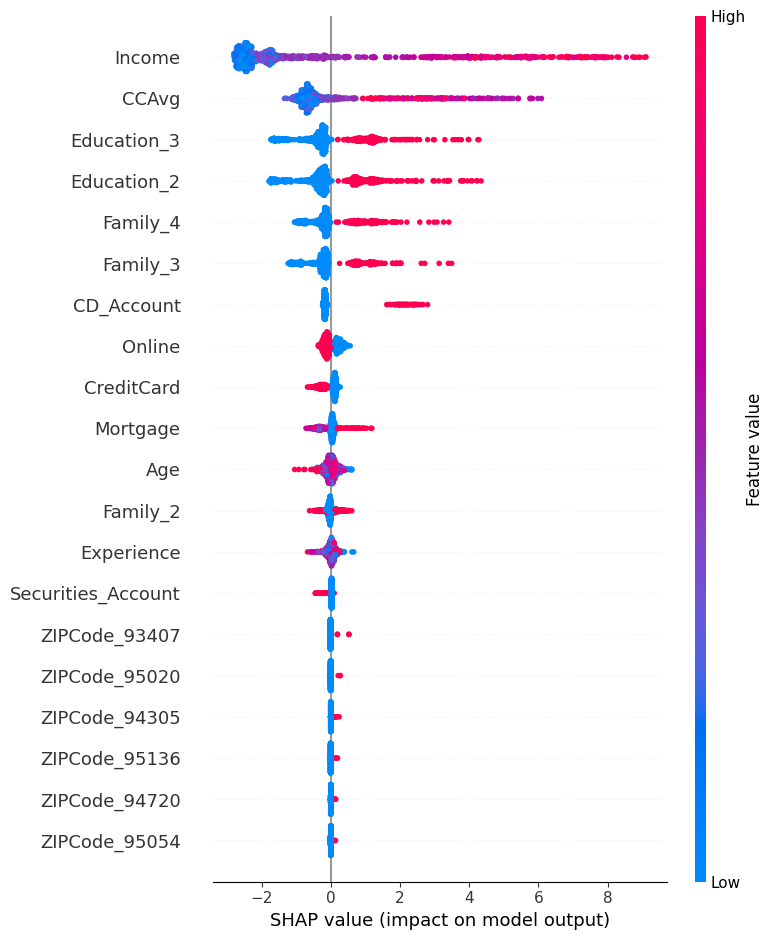

In [133]:
'''
Approach 1: Baseline Model without Feature Engineering and Outlier Treatment
============================================================================

Steps:
1. Model Training
2. Model Evaluation
3. Hyperparameter Tuning
4. Cross-Validation
5. Feature Importance Analysis
6. Model Interpretability
'''

df_cleaned_approach1=df_original_cleaned2.copy()
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_cleaned_approach1, columns=['ZIPCode', 'Education', 'Family'], drop_first=True)

# Define features and target variable
X = df_encoded.drop(columns=['Personal_Loan'])
y = df_encoded['Personal_Loan']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store models and their performance
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42)
}

# Dictionary to store the performance metrics
performance = {
    'Model': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1-Score': []
}

# Function to evaluate and store performance metrics
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    performance['Model'].append(name)
    performance['Accuracy'].append(accuracy_score(y_test, y_pred))
    performance['Recall'].append(recall_score(y_test, y_pred))
    performance['Precision'].append(precision_score(y_test, y_pred))
    performance['F1-Score'].append(f1_score(y_test, y_pred))

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(name, model, X_test, y_test)

# Create a DataFrame to display the performance
performance_df = pd.DataFrame(performance)

# Print the performance comparison
print("Model Performance:")
print(performance_df)

# Hyperparameter tuning for the best model (XGBoost)
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'scale_pos_weight': [1, 5, 10]  # Adjust for class imbalance
}

# Initialize XGBClassifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=50, cv=5, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_

# Evaluate the best model
performance_best_xgb = {
    'Model': 'XGBoost (Tuned)',
    'Accuracy': accuracy_score(y_test, best_xgb.predict(X_test)),
    'Recall': recall_score(y_test, best_xgb.predict(X_test)),
    'Precision': precision_score(y_test, best_xgb.predict(X_test)),
    'F1-Score': f1_score(y_test, best_xgb.predict(X_test))
}

# Print performance of the best XGBoost model
print("Tuned XGBoost Model Performance:")
print(pd.DataFrame([performance_best_xgb]))

# Cross-Validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_xgb, X, y, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

# Feature Importance Analysis
importance = best_xgb.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

# Model Interpretability using SHAP
# Ensure that SHAP is correctly handling the input data types
# Convert data to float64 if necessary
X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)

explainer = shap.Explainer(best_xgb, X_train_float)
shap_values = explainer(X_test_float)
shap.summary_plot(shap_values, X_test_float)


In [134]:
# remove outliers based on Z-scores
def remove_outliers(data, threshold=3):
    # Create a copy of the DataFrame to avoid changing the original data
    df_outliers_cleaned = data.copy()

    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(df_outliers_cleaned.select_dtypes(include=[np.number])))

    # Define outliers
    outliers = (z_scores > threshold).all(axis=1)

    # Remove outliers
    df_outliers_cleaned = df_outliers_cleaned[~outliers]

    return df_outliers_cleaned

# df_original_cleaned.info()
# Remove outliers from the local DataFrame
df_outlier_removed = remove_outliers(df_original_cleaned)
df_outlier_removed_original = df_outlier_removed.copy()
# Display information about the cleaned DataFrame
print("DataFrame after outlier removal:")
print(df_outlier_removed.info())


DataFrame after outlier removal:
<class 'pandas.core.frame.DataFrame'>
Index: 4948 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4948 non-null   int64  
 1   Experience          4948 non-null   int64  
 2   Income              4948 non-null   int64  
 3   ZIPCode             4948 non-null   int64  
 4   Family              4948 non-null   int64  
 5   CCAvg               4948 non-null   float64
 6   Education           4948 non-null   int64  
 7   Mortgage            4948 non-null   int64  
 8   Personal_Loan       4948 non-null   int64  
 9   Securities_Account  4948 non-null   int64  
 10  CD_Account          4948 non-null   int64  
 11  Online              4948 non-null   int64  
 12  CreditCard          4948 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 541.2 KB
None


<class 'pandas.core.frame.DataFrame'>
Index: 4948 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4948 non-null   int64  
 1   Experience          4948 non-null   int64  
 2   Income              4948 non-null   int64  
 3   ZIPCode             4948 non-null   int64  
 4   Family              4948 non-null   int64  
 5   CCAvg               4948 non-null   float64
 6   Education           4948 non-null   int64  
 7   Mortgage            4948 non-null   int64  
 8   Personal_Loan       4948 non-null   int64  
 9   Securities_Account  4948 non-null   int64  
 10  CD_Account          4948 non-null   int64  
 11  Online              4948 non-null   int64  
 12  CreditCard          4948 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 541.2 KB
Model Performance Results:
                          Model Accuracy   Recall Precision F1-Score  \
0          

 98%|===================| 2912/2970 [00:23<00:00]       

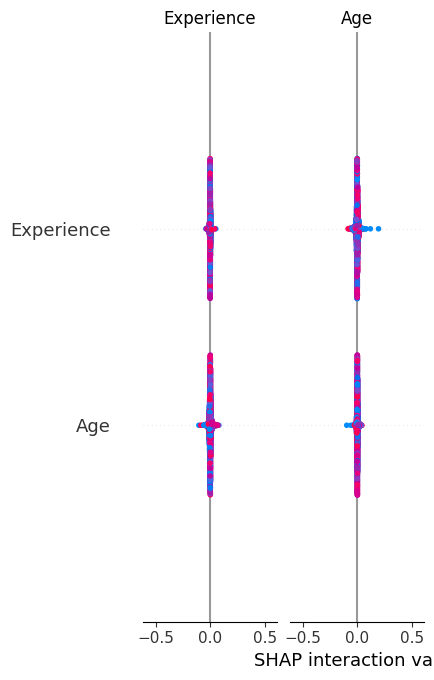

Analyzing SHAP values for XGBoost...


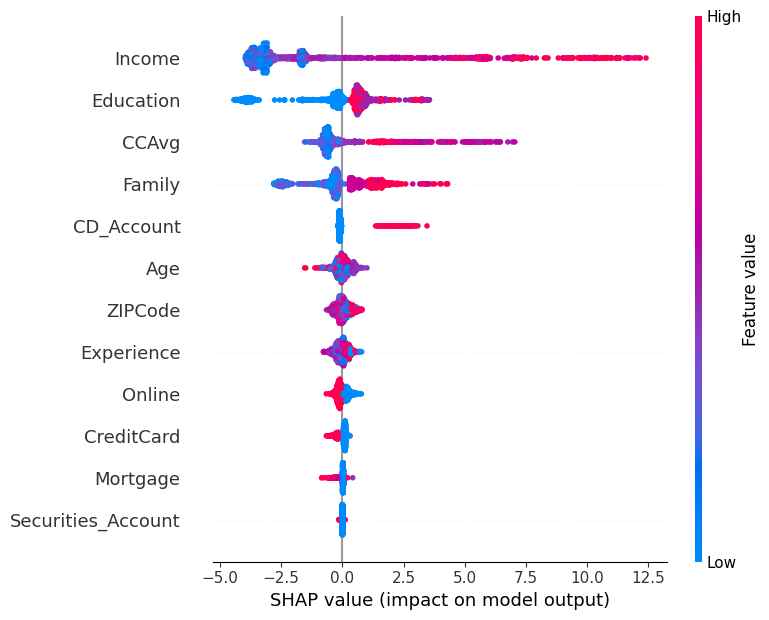

Analyzing SHAP values for Logistic Regression...
SHAP analysis is not supported for LogisticRegression
Analyzing SHAP values for SVM...
SHAP analysis is not supported for SVC
Analyzing SHAP values for Gradient Boosting...


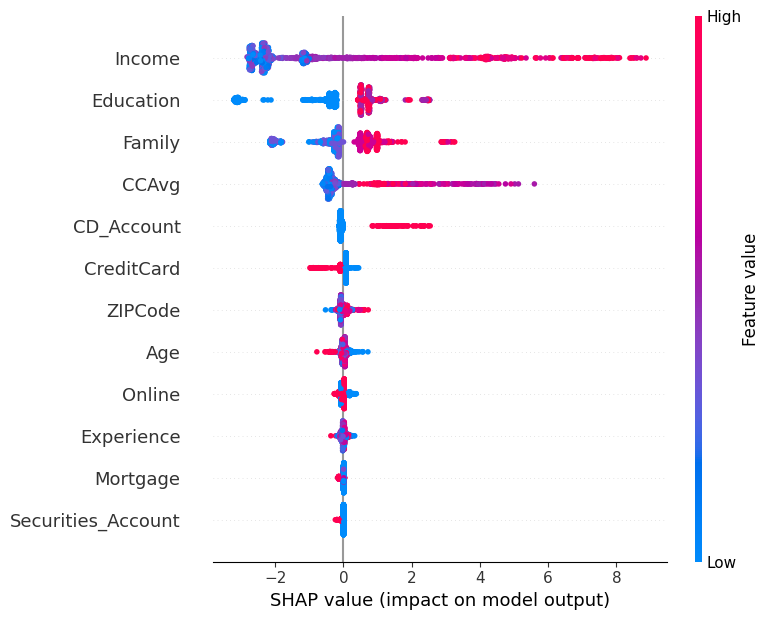

In [135]:
# Approach 2: Model with Outlier Treatment

# Steps:
# 1. Outlier Treatment: Apply techniques to handle outliers in the dataset.
# 2. Model Training: Train various models with the treated dataset.
# 3. Model Evaluation: Evaluate the models using accuracy, recall, precision, and F1-score.
# 4. Hyperparameter Tuning: Perform hyperparameter tuning for the best-performing model.
# 5. Cross-Validation: Perform cross-validation to ensure the model's performance.
# 6. Feature Importance Analysis: Analyze the importance of each feature in the model.
# 7. Model Interpretability: Use SHAP or other interpretability methods to explain the model's predictions.

df_original_cleaned.info()
# Load your cleaned data
df_with_outliers = df_original_cleaned2.copy()

# Remove outliers from the local DataFrame
df_outlier_removed = remove_outliers(df_with_outliers)

# Define target and features
X = df_outlier_removed.drop(columns=['Personal_Loan'])
y = df_outlier_removed['Personal_Loan']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Impute missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Decision Tree (No Weights)': DecisionTreeClassifier(random_state=42),
    'Decision Tree (Class Weight)': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Decision Tree (Pre-Pruning)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Decision Tree (Post-Pruning)': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),  # Added probability=True for probability estimates
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    return accuracy, recall, precision, f1, cv_scores.mean()

# Initialize results
model_results = {
    'Model': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1-Score': [],
    'Cross-Val F1-Score': []
}

# Evaluate all models
for name, model in models.items():
    acc, recall, prec, f1, cv_f1 = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    model_results['Model'].append(name)
    model_results['Accuracy'].append(f"{acc:.5f}")
    model_results['Recall'].append(f"{recall:.5f}")
    model_results['Precision'].append(f"{prec:.5f}")
    model_results['F1-Score'].append(f"{f1:.5f}")
    model_results['Cross-Val F1-Score'].append(f"{cv_f1:.5f}")

# Create a DataFrame to display the results
results_df = pd.DataFrame(model_results)

# Print the results
print("Model Performance Results:")
print(results_df)

# Feature Importance and SHAP Analysis
# Initialize the SHAP explainer and analysis for models that support it
def analyze_shap(model, X_train, X_test, feature_names):
    """
    Analyzes SHAP values for the given model and data.

    Parameters:
    - model: Trained model object
    - X_train: Training feature data
    - X_test: Test feature data
    - feature_names: List of feature names
    """
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier)):
        try:
            # Initialize the SHAP Explainer
            explainer = shap.Explainer(model, X_train)

            # Calculate SHAP values
            shap_values = explainer(X_test, check_additivity=False)  # Disable additivity check

            # Create summary plot
            shap.summary_plot(shap_values, X_test, feature_names=feature_names)

        except ImportError:
            print("SHAP library is not installed or is not compatible.")
        except TypeError as e:
            print(f"Error in SHAP interpretation: {e}")
    else:
        print(f"SHAP analysis is not supported for {model.__class__.__name__}")

# Perform SHAP analysis for models that support it
for name, model in models.items():
    print(f"Analyzing SHAP values for {name}...")
    analyze_shap(model, X_train_scaled, X_test_scaled, X.columns)



Training and tuning Decision Tree (No Weights)...

Training and tuning Decision Tree (Class Weight)...

Training and tuning Decision Tree (Pre-Pruning)...

Training and tuning Decision Tree (Post-Pruning)...

Training and tuning Random Forest...

Training and tuning XGBClassifier...

Training and tuning Logistic Regression...

Training and tuning SVM...

Training and tuning Gradient Boosting...

Model Evaluation Results for Approach 3:
                       Model  Accuracy  Recall  Precision  F1-Score  Cross-Val F1-Score
               XGBClassifier   0.98519 0.85271    0.97345   0.90909             0.93868
           Gradient Boosting   0.98316 0.87597    0.92623   0.90040             0.94565
               Random Forest   0.98316 0.84496    0.95614   0.89712             0.93698
                         SVM   0.98182 0.81395    0.97222   0.88608             0.88176
Decision Tree (Class Weight)   0.97845 0.84496    0.90083   0.87200             0.90780
  Decision Tree (No Weights)   

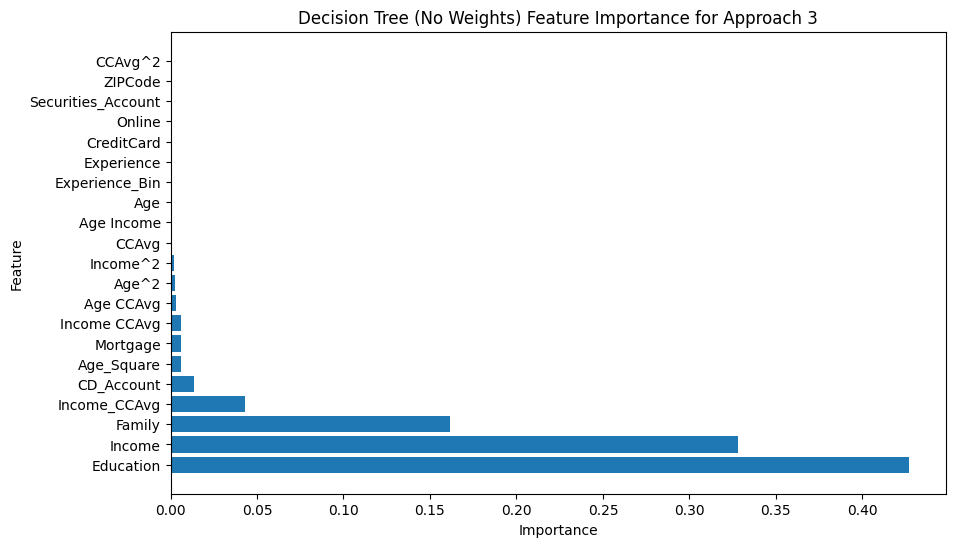


Decision Tree (Class Weight) Feature Importance for Approach 3:
         Feature  Importance
16        Income     0.59613
4         Family     0.12797
6      Education     0.08976
5          CCAvg     0.06432
22  Income CCAvg     0.02999


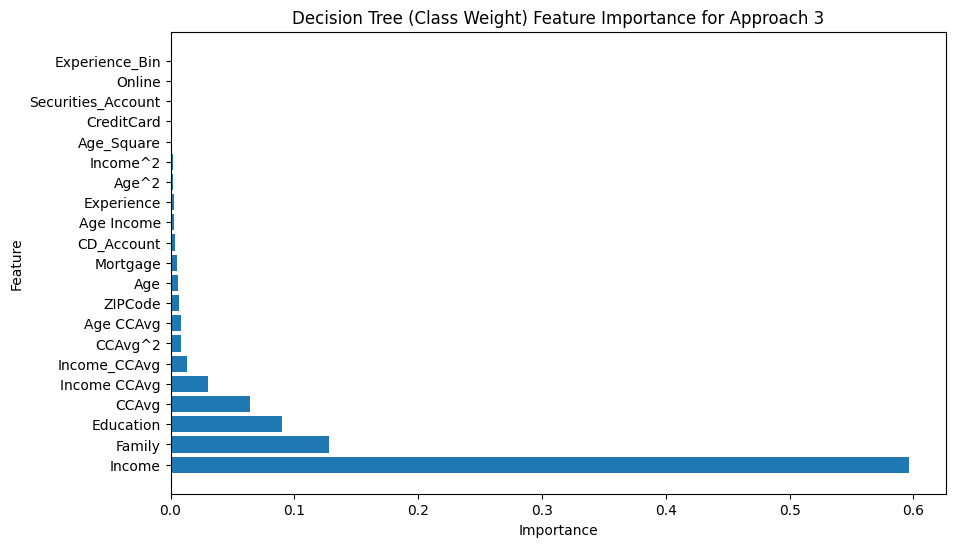


Decision Tree (Pre-Pruning) Feature Importance for Approach 3:
         Feature  Importance
6      Education     0.42673
16        Income     0.32793
4         Family     0.16151
12  Income_CCAvg     0.04290
9     CD_Account     0.01356


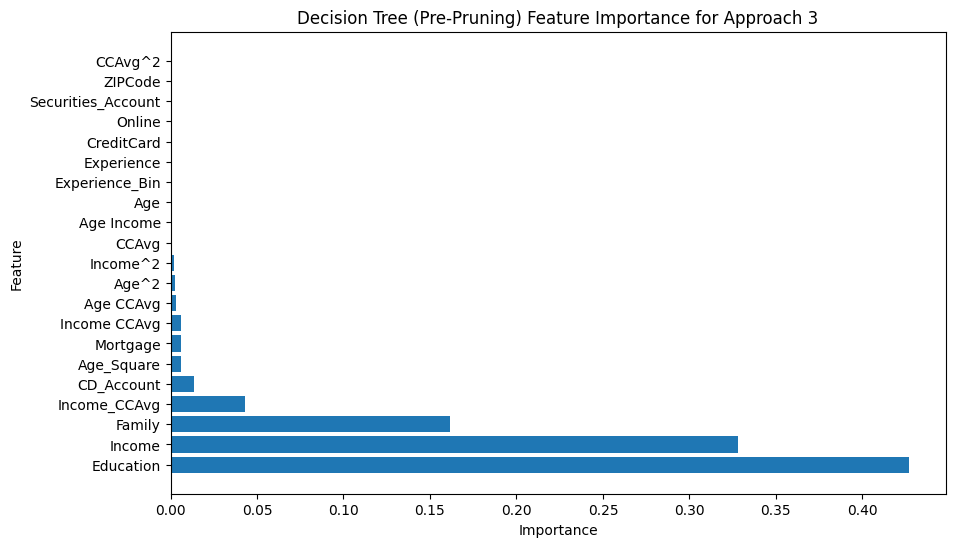


Decision Tree (Post-Pruning) Feature Importance for Approach 3:
         Feature  Importance
6      Education     0.42673
16        Income     0.32793
4         Family     0.16151
12  Income_CCAvg     0.04290
9     CD_Account     0.01356


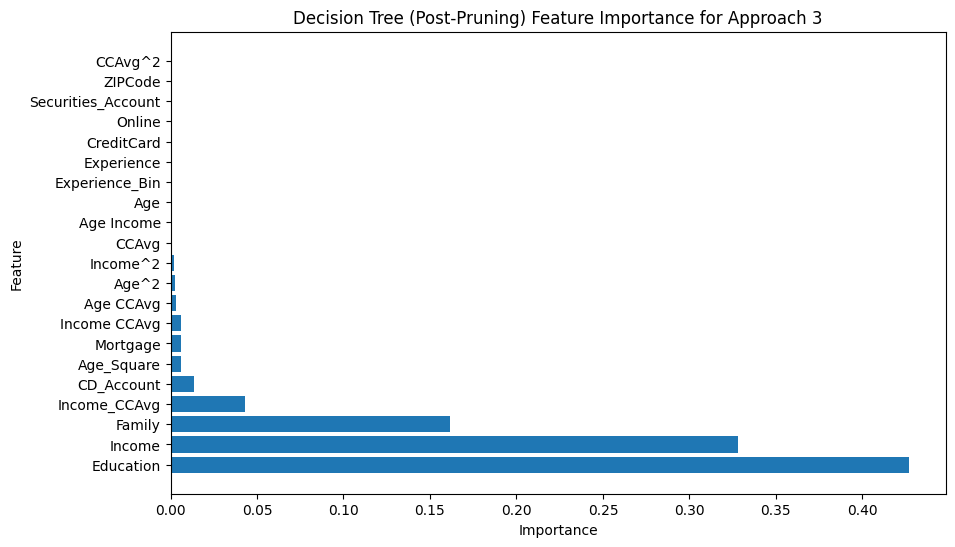


Random Forest Feature Importance for Approach 3:
      Feature  Importance
6   Education     0.21779
4      Family     0.12022
21   Income^2     0.11443
2      Income     0.10265
16     Income     0.07022


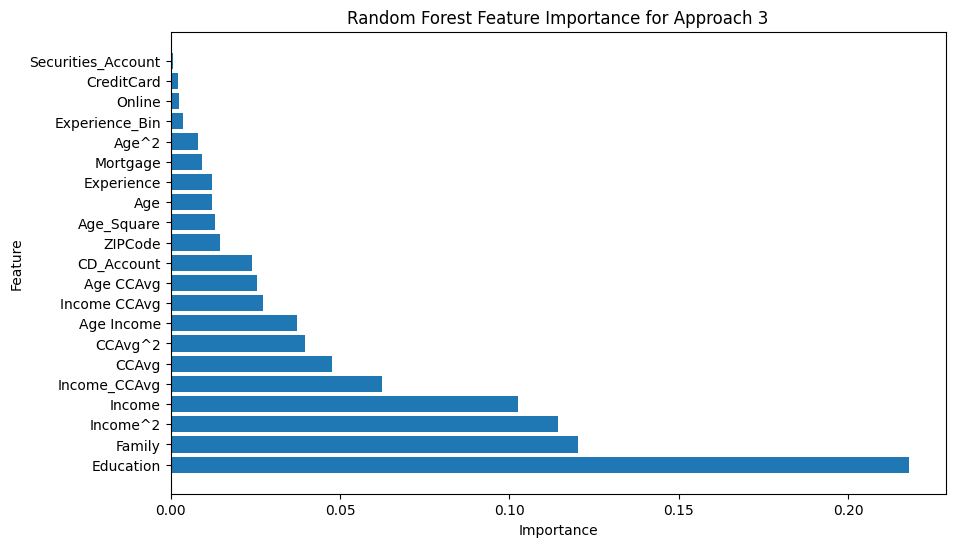


XGBClassifier Feature Importance for Approach 3:
         Feature  Importance
6      Education     0.37052
2         Income     0.24235
4         Family     0.15858
12  Income_CCAvg     0.06382
5          CCAvg     0.03783


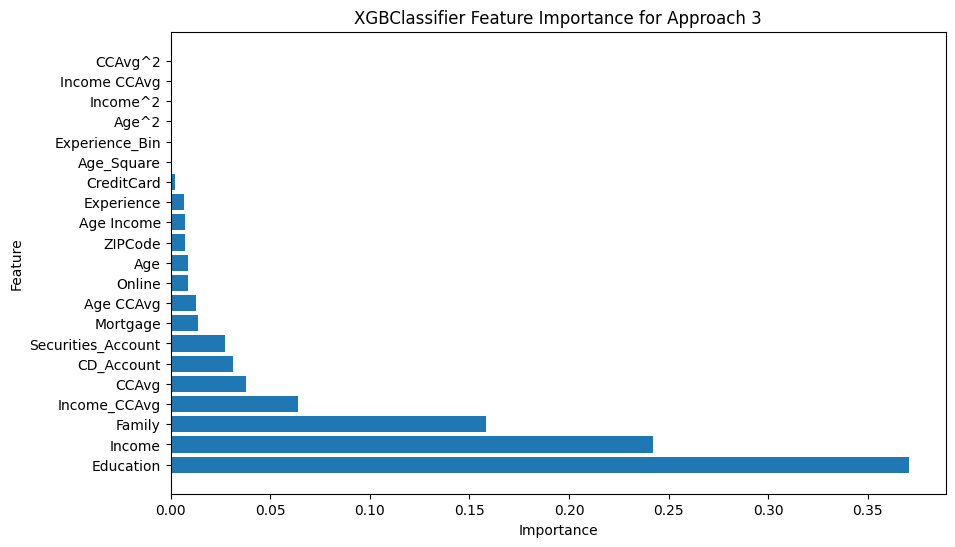


Logistic Regression does not support feature importance.

SVM does not support feature importance.

Gradient Boosting Feature Importance for Approach 3:
         Feature  Importance
6      Education     0.37440
16        Income     0.27948
4         Family     0.15305
12  Income_CCAvg     0.06141
21      Income^2     0.03412


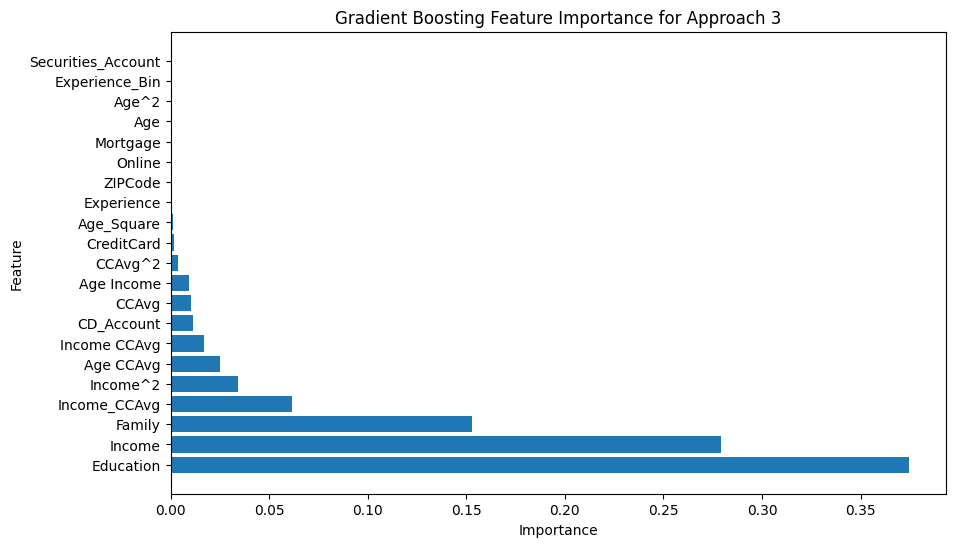


SHAP Analysis for Approach 3:

Analyzing SHAP values for Decision Tree (No Weights) in Approach 3...
SHAP analysis is not supported for DecisionTreeClassifier

Analyzing SHAP values for Decision Tree (Class Weight) in Approach 3...
SHAP analysis is not supported for DecisionTreeClassifier

Analyzing SHAP values for Decision Tree (Pre-Pruning) in Approach 3...
SHAP analysis is not supported for DecisionTreeClassifier

Analyzing SHAP values for Decision Tree (Post-Pruning) in Approach 3...
SHAP analysis is not supported for DecisionTreeClassifier

Analyzing SHAP values for Random Forest in Approach 3...
Error in SHAP interpretation: The passed model is not callable and cannot be analyzed directly with the given masker! Model: RandomForestClassifier(random_state=42)

Analyzing SHAP values for XGBClassifier in Approach 3...
Error in SHAP interpretation: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster=Non

In [136]:
# Approach 3: Model with Feature Engineering without treating outlier
# Steps to be covered:
# 1. Feature Engineering
# 2. Model Training
# 3. Model Evaluation
# 4. Hyperparameter Tuning
# 5. Cross-Validation
# 6. Feature Importance Analysis
# 7. Model Interpretability

# Make a local copy of the original DataFrame for Approach 3
df_original_cleaned_copy_approach3 = df_original_cleaned2.copy()

# Feature Engineering
def feature_engineering(df):
    df = df.copy()

    # Example of feature creation
    df['Income_CCAvg'] = df['Income'] * df['CCAvg']  # Interaction term
    df['Age_Square'] = df['Age'] ** 2  # Polynomial feature
    df['Experience_Bin'] = pd.cut(df['Experience'], bins=5, labels=False)  # Binning

    # Polynomial features (for numeric columns)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df[['Age', 'Income', 'CCAvg']])
    poly_feature_names = poly.get_feature_names_out(['Age', 'Income', 'CCAvg'])
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    # Concatenate original df with polynomial features
    df = pd.concat([df, poly_df], axis=1)

    # Ensure no NaNs in the feature-engineered DataFrame
    df = df.dropna()

    return df

# Apply feature engineering to the copied DataFrame
df_engineered_approach3 = feature_engineering(df_original_cleaned_copy_approach3)

# Define features and target
X_approach3 = df_engineered_approach3.drop(columns=['Personal_Loan'])
y_approach3 = df_engineered_approach3['Personal_Loan']

# Check for NaNs in target variable
if y_approach3.isna().any():
    print("Target variable contains NaNs. Handling NaNs...")
    y_approach3 = y_approach3.dropna()  # Drop NaNs in target variable
    X_approach3 = X_approach3.loc[y_approach3.index]  # Ensure features align with target

# Split Data
X_train_approach3, X_test_approach3, y_train_approach3, y_test_approach3 = train_test_split(X_approach3, y_approach3, test_size=0.3, random_state=42)

# Standardize Features
scaler_approach3 = StandardScaler()
X_train_scaled_approach3 = scaler_approach3.fit_transform(X_train_approach3)
X_test_scaled_approach3 = scaler_approach3.transform(X_test_approach3)

# Define Models for Approach 3
models_approach3 = {
    'Decision Tree (No Weights)': DecisionTreeClassifier(random_state=42),
    'Decision Tree (Class Weight)': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Decision Tree (Pre-Pruning)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Decision Tree (Post-Pruning)': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),  # Added probability=True for probability estimates
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Hyperparameter Tuning for Approach 3
param_grids_approach3 = {
    'Decision Tree (No Weights)': {'max_depth': [5, 10, 15]},
    'Decision Tree (Class Weight)': {'max_depth': [5, 10, 15]},
    'Decision Tree (Pre-Pruning)': {'max_depth': [5, 10, 15]},
    'Decision Tree (Post-Pruning)': {'max_depth': [5, 10, 15]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]},
    'XGBClassifier': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},  # Add hyperparameter grid for Logistic Regression
    'SVM': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}  # Add hyperparameter grid for SVM
}

results_approach3 = []

# Train and evaluate models for Approach 3
for model_name, model in models_approach3.items():
    print(f"\nTraining and tuning {model_name}...")

    # Hyperparameter tuning
    grid_search_approach3 = GridSearchCV(model, param_grids_approach3[model_name], cv=5, scoring='f1')
    grid_search_approach3.fit(X_train_scaled_approach3, y_train_approach3)

    # Best model
    best_model_approach3 = grid_search_approach3.best_estimator_

    # Model Evaluation
    y_pred_approach3 = best_model_approach3.predict(X_test_scaled_approach3)
    accuracy_approach3 = accuracy_score(y_test_approach3, y_pred_approach3)
    recall_approach3 = recall_score(y_test_approach3, y_pred_approach3)
    precision_approach3 = precision_score(y_test_approach3, y_pred_approach3)
    f1_approach3 = f1_score(y_test_approach3, y_pred_approach3)

    # Cross-Validation F1-Score
    cross_val_f1_approach3 = cross_val_score(best_model_approach3, X_train_scaled_approach3, y_train_approach3, cv=5, scoring='f1').mean()

    results_approach3.append({
        'Model': model_name,
        'Accuracy': accuracy_approach3,
        'Recall': recall_approach3,
        'Precision': precision_approach3,
        'F1-Score': f1_approach3,
        'Cross-Val F1-Score': cross_val_f1_approach3
    })

# Convert results to DataFrame for Approach 3
results_df_approach3 = pd.DataFrame(results_approach3).sort_values(by='F1-Score', ascending=False)

# Print results as a table for Approach 3
print("\nModel Evaluation Results for Approach 3:")
print(results_df_approach3.to_string(index=False))

# Feature Importance Analysis for best models for Approach 3
print("\nFeature Importance for Approach 3:")
for model_name, model in models_approach3.items():
    grid_search_approach3 = GridSearchCV(model, param_grids_approach3[model_name], cv=5, scoring='f1')
    best_model_approach3 = grid_search_approach3.fit(X_train_scaled_approach3, y_train_approach3).best_estimator_

    if hasattr(best_model_approach3, 'feature_importances_'):
        feature_importance_approach3 = pd.DataFrame({
            'Feature': X_approach3.columns,
            'Importance': best_model_approach3.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        print(f"\n{model_name} Feature Importance for Approach 3:")
        print(feature_importance_approach3.head())

        # Plot Feature Importance for Approach 3
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_approach3['Feature'], feature_importance_approach3['Importance'])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'{model_name} Feature Importance for Approach 3')
        plt.show()
    else:
        print(f"\n{model_name} does not support feature importance.")

# Model Interpretability for Approach 3
def analyze_shap(model, X_train, X_test, feature_names):
    """
    Analyzes SHAP values for the given model and data.

    Parameters:
    - model: Trained model object
    - X_train: Training feature data
    - X_test: Test feature data
    - feature_names: List of feature names
    """
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier)):
        try:
            # Initialize the SHAP Explainer
            explainer = shap.Explainer(model, X_train)

            # Calculate SHAP values
            shap_values = explainer(X_test, check_additivity=False)  # Disable additivity check

            # Create summary plot
            shap.summary_plot(shap_values, X_test, feature_names=feature_names)

        except ImportError:
            print("SHAP library is not installed or is not compatible.")
        except TypeError as e:
            print(f"Error in SHAP interpretation: {e}")
    else:
        print(f"SHAP analysis is not supported for {model.__class__.__name__}")

# Analyze SHAP values for the best model in Approach 3
print("\nSHAP Analysis for Approach 3:")
for name, model in models_approach3.items():
    print(f"\nAnalyzing SHAP values for {name} in Approach 3...")
    analyze_shap(model, X_train_scaled_approach3, X_test_scaled_approach3, X_approach3.columns)
